In [1]:
import pandas as pd
import xarray as xr
import geopandas as gpd
import numpy as np
import re
import datetime
import matplotlib.pyplot as plt
from rasterio.plot import show
from skimage.filters.rank import majority
import statsmodels.api as sm
import statsmodels.formula.api as smf
from tqdm.notebook import tqdm
from sklearn.neighbors import BallTree
import statsmodels.stats.api as sms
import re
import seaborn as sns

%config Completer.use_jedi = False
%matplotlib widget

from distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=5, threads_per_worker=2)
client = Client(cluster)

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\distributed\node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 61856 instead
  warnings.warn(


In [2]:
"""
Define input data and covariates for extraction
"""
gps_f = str('C:/Users/sean.kearney/OneDrive - USDA/Documents/Projects/GPS_v_hetgen/data/' +
            '2017_grazing_time_gridded_all.csv')

ts_covariates = {
    'Biomass': {
        'path': 'C:/SPK_local/data/rasters/HLS/HLS_CARM_biomass/CPER_biomass_pred_simp_2017_v3.tif'},
    'CP': {
        'path': 'C:/SPK_local/data/rasters/HLS/HLS_quality/CPER_CP_2017.tif'},
    'DOM': {
        'path': 'C:/SPK_local/data/rasters/HLS/HLS_quality/CPER_DOM_2017.tif'}
}
static_covariates = {
    'TPC': {
        'path': 'C:/SPK_local/data/rasters/DEM/TopoClass25m.tif'},
    'dFence': {
        'path': 'C:/SPK_local/data/rasters/Masks/CPER_dist_to_fence_2017.tif'},
    'dTank': {
        'path': 'C:/SPK_local/data/rasters/Masks/CPER_dist_to_tank_2017.tif'}
}

#veg_f = 'G:/neon_v18/neon_class_2017_v18.tif'
veg_f = 'T:/3-GIS/CPER/Layers/NEON/veg_maps_v18/neon_class_2017_v18.tif'

corners_f = 'C:/SPK_local/data/vectors/CPER_features/CPER_pasture_corners.shp'

In [3]:
df_wkly_grid = pd.read_csv(gps_f, engine='python')
df_wkly_grid.loc[df_wkly_grid['grazing_secs'] > 10000, 'grazing_secs'] = np.nan

In [4]:
df_wkly_grid['week'].unique()

array([19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36,
       37, 38, 39], dtype=int64)

In [7]:
"""
Add season to dataset based on week
"""
#season_dict = {
#    21: 'early',
#    22: 'early',
#    23: 'early',
#    28: 'mid',
#    30: 'mid',
#    31: 'mid',
#   37: 'late',
#    38: 'late'
#}

#df_wkly_grid['season'] = df_wkly_grid['week'].apply(lambda x: season_dict[x])
def season_func(wk):
    if wk <= 26:
        return 'early'
    elif wk <= 32:
        return 'mid'
    elif wk >= 33:
        return 'late'

df_wkly_grid['season'] = df_wkly_grid['week'].apply(lambda x: season_func(x))
df_wkly_grid['season'] = pd.Categorical(df_wkly_grid['season'], ['early', 'mid', 'late'])

In [8]:
"""
Get distance to nearest pasture corner for each pasture
"""
# read in shapefile of corners
gdf_corners = gpd.read_file(corners_f)

# loop through pastures and get the distance from each fix to the pasture corner
for past_i in tqdm(df_wkly_grid['Pasture'].unique()):
    #print(past_i)
    gdf_corners_p = gdf_corners[gdf_corners['Pasture'] == past_i]
    x_coords = [i[0][0] for i in gdf_corners_p.apply(lambda x: x.geometry.coords.xy, axis=1)]
    y_coords = [i[1][0] for i in gdf_corners_p.apply(lambda x: x.geometry.coords.xy, axis=1)]

    # Create a BallTree object
    # borrowed from: https://stackoverflow.com/questions/58893719/find-nearest-point-in-other-dataframe-with-a-lot-of-data
    tree = BallTree(np.array(list(zip(x_coords, y_coords))), leaf_size=2)

    #Query the BallTree on all GPS coordinates from collars deployed in the pasture to find the distance
    # to the nearest pixel within the pasture and its id
    dist_tmp, id_tmp= tree.query(
        df_wkly_grid.loc[df_wkly_grid['Pasture'] == past_i, ['UTM_X', 'UTM_Y']].values, # The input array for the query
        k=1, # The number of nearest neighbors
    )
    df_wkly_grid.loc[df_wkly_grid['Pasture'] == past_i, 'dCorner'] = dist_tmp

  0%|          | 0/10 [00:00<?, ?it/s]

In [9]:
"""
Convert gridded covariates to xarray datasets
"""
for i in ts_covariates:
    print(i)
    xr_tmp = xr.open_rasterio(ts_covariates[i]['path'])
    xr_tmp = xr_tmp.rename({'band': 'date'})
    xr_tmp['date'] = [datetime.datetime(2017, 1, 1) + 
                   datetime.timedelta(d-1) for d in xr_tmp['date'].astype('float').values]
    ts_covariates[i]['data'] = xr_tmp

for i in static_covariates:
    print(i)
    xr_tmp = xr.open_rasterio(static_covariates[i]['path']).squeeze('band')
    if i == 'TPC':
        xr_tmp = xr_tmp.astype('int')
    static_covariates[i]['data'] = xr_tmp

Biomass
CP
DOM
TPC
dFence
dTank


In [10]:
"""
Prepare plant community (veg) covariates to be added to static covariates
"""
xr_veg = xr.open_rasterio(veg_f).squeeze('band')#.chunk({'y': 300, 'x': 300})
xr_veg.name = 'VEG_FG'
veg_dict = {'C4': [0],
            'Annual': [1],
            'Bare_veg': [2, 3], # combines Bare_veg with FORB
            'C3': [4, 5], # combines HECO and PASM
            'C3_C4_mix': [6, 7],
            'Saltgrass': [8],
            'Shrub': [9],
            'Bare': [10],
            'UNK': [11, 255]
            }
print('Running majority filters')
print('1 of 3')
img_maj1 = majority(xr_veg.values, np.ones((3, 3)))
xr_veg1 = xr_veg.where(xr_veg != 255, other=img_maj1)
print('2 of 3')
img_maj2 = majority(xr_veg1.values, np.ones((3, 3)))
xr_veg2 = xr_veg1.where(xr_veg1 != 255, other=img_maj2)
print('3 of 3')
img_maj3 = majority(xr_veg2.values, np.ones((3, 3)))
xr_veg3 = xr_veg2.where(xr_veg2 != 255, other=img_maj3)
print('Majority filters finished!')

Running majority filters
1 of 3
2 of 3
3 of 3
Majority filters finished!


In [11]:
from matplotlib.colors import ListedColormap, BoundaryNorm
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(6, 6), sharex=True, sharey=True)
cmap_veg = ListedColormap(['blue', 'orange', 'red', 'green', 'lightseagreen', 'pink', 'yellow', 'brown', 'black'])
norm = BoundaryNorm([0, 1, 2, 4, 6, 8, 9, 10, 11], cmap_veg.N, clip=True)
show(xr_veg, cmap=cmap_veg, norm=norm, ax=axs.flatten()[0])
show(xr_veg1, cmap=cmap_veg, norm=norm, ax=axs.flatten()[1])
show(xr_veg2, cmap=cmap_veg, norm=norm, ax=axs.flatten()[2])
show(xr_veg3, cmap=cmap_veg, norm=norm, ax=axs.flatten()[3])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:>

In [12]:
from rasterio.crs import CRS
import rasterio as rio
out_profile = {'driver': 'GTiff',
                       'dtype': 'int16',
                       'nodata': -999,
                       'width': len(xr_veg.x),
                       'height': len(xr_veg.y),
                       'count': 1,
                       'crs': CRS.from_dict(init='epsg:32613'),
                       'transform': rio.Affine(1.0, 0.0, np.min(xr_veg.x - 0.5).data,
                                               0.0, -1.0, np.max(xr_veg.y + 0.5).data),
                       'tiled': False}
#with rio.open('G:/neon_v18/neon_class_2017_v18_maj1.tif',
#              'w', **out_profile) as dst:
#    dst.write(xr_veg1.data[np.newaxis, :, :])
#with rio.open('G:/neon_v18/neon_class_2017_v18_maj2.tif',
#          'w', **out_profile) as dst:
#    dst.write(xr_veg2.data[np.newaxis, :, :])
#with rio.open('G:/neon_v18/neon_class_2017_v18_maj3.tif',
#          'w', **out_profile) as dst:
#    dst.write(xr_veg3.data[np.newaxis, :, :])

In [13]:
xr_veg = xr_veg3

In [14]:
xr_veg_30m = xr_veg.coarsen(dim=dict(x=30, y=30), boundary='trim').count()
xr_veg_30m = xr_veg_30m.to_dataset()

for k in veg_dict:
    print(k)
    xr_veg_30m = xr_veg_30m.assign(TMP=(['y', 'x'],
                                  xr_veg.where(xr_veg.isin(veg_dict[k])).coarsen(dim=dict(x=30, y=30),
                                                                           boundary='trim').count()))
    xr_veg_30m['TMP'] = xr_veg_30m['TMP'] / xr_veg_30m['VEG_FG']
    xr_veg_30m = xr_veg_30m.rename({'TMP': k})
xr_veg_30m

C4
Annual
Bare_veg
C3
C3_C4_mix
Saltgrass
Shrub
Bare
UNK


<xarray.Dataset>
Dimensions:    (x: 401, y: 436)
Coordinates:
    band       int32 1
  * y          (y) float64 4.526e+06 4.526e+06 4.526e+06 ... 4.513e+06 4.513e+06
  * x          (x) float64 5.166e+05 5.167e+05 5.167e+05 ... 5.286e+05 5.286e+05
Data variables:
    VEG_FG     (y, x) int32 900 900 900 900 900 900 ... 900 900 900 900 900 900
    C4         (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Annual     (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Bare_veg   (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    C3         (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    C3_C4_mix  (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Saltgrass  (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Shrub      (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Bare       (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    UNK        (y, x) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0

In [15]:
xr_veg_30m = xr_veg_30m.sel(y=static_covariates['dFence']['data']['y'],
                            x=static_covariates['dFence']['data']['x'],
                            method='nearest').reindex_like(static_covariates['dFence']['data'], 
                                                           method='nearest')
xr_veg_30m = xr_veg_30m.fillna(0)

In [16]:
static_covariates['PC_dmt'] = {'data':
                               xr_veg_30m[[i for i in veg_dict]].to_array().idxmax('variable')}
static_covariates['PC_pct'] = {'data':
                               xr_veg_30m[[i for i in veg_dict]].to_array().max('variable')}
static_covariates['PC_div'] = {'data':
                              (xr_veg_30m[[i for i in veg_dict]].to_array() * 
                               xr.ufuncs.log(xr_veg_30m[[i for i in veg_dict]].to_array().where(
                                   xr_veg_30m[[i for i in veg_dict]].to_array() != 0))).sum('variable') * -1.0}

In [17]:
xr_PC_dmt_int = static_covariates['PC_dmt']['data'].copy()
xr_PC_dmt_int.values = np.array([veg_dict[i][0] for i in static_covariates['PC_dmt']['data'].values.flatten()]).reshape(xr_PC_dmt_int.shape)

In [18]:
fig, axs = plt.subplots(ncols=3, figsize=(9, 4), sharex=True, sharey=True)
show(xr_PC_dmt_int, cmap='tab10', ax=axs[0])
show(static_covariates['PC_pct']['data'], cmap='viridis', ax=axs[1])
show(static_covariates['PC_div']['data'], cmap='magma', ax=axs[2])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:>

In [19]:
"""
Loop through static and time series co-variates and extract for each data point
"""
for g in df_wkly_grid.groupby('week'):
    print(g[0])
    target_lon = xr.DataArray(g[1]['UTM_X'], dims="points")
    target_lat = xr.DataArray(g[1]['UTM_Y'], dims="points")
    # loop through static covariates and get values
    for var in static_covariates:
        print(var)
        xr_tmp = static_covariates[var]['data']
        df_wkly_grid.loc[df_wkly_grid['week'] == g[0], var] = xr_tmp.sel(
            x=target_lon, y=target_lat, method='nearest').values
    # loop through time series covariates and get weekly average
    for var in ts_covariates:
        print(var)
        xr_tmp = ts_covariates[var]['data']
        df_wkly_grid.loc[df_wkly_grid['week'] == g[0], var] = xr_tmp[xr_tmp.date.dt.isocalendar().week == g[0]].mean('date').sel(
            x=target_lon, y=target_lat, method='nearest').values

19
TPC
dFence
dTank
PC_dmt
PC_pct
PC_div
Biomass
CP
DOM
20
TPC
dFence
dTank
PC_dmt
PC_pct
PC_div
Biomass
CP
DOM
21
TPC
dFence
dTank
PC_dmt
PC_pct
PC_div
Biomass
CP
DOM
22
TPC
dFence
dTank
PC_dmt
PC_pct
PC_div
Biomass
CP
DOM
23
TPC
dFence
dTank
PC_dmt
PC_pct
PC_div
Biomass
CP
DOM
24
TPC
dFence
dTank
PC_dmt
PC_pct
PC_div
Biomass
CP
DOM
25
TPC
dFence
dTank
PC_dmt
PC_pct
PC_div
Biomass
CP
DOM
26
TPC
dFence
dTank
PC_dmt
PC_pct
PC_div
Biomass
CP
DOM
27
TPC
dFence
dTank
PC_dmt
PC_pct
PC_div
Biomass
CP
DOM
28
TPC
dFence
dTank
PC_dmt
PC_pct
PC_div
Biomass
CP
DOM
29
TPC
dFence
dTank
PC_dmt
PC_pct
PC_div
Biomass
CP
DOM
30
TPC
dFence
dTank
PC_dmt
PC_pct
PC_div
Biomass
CP
DOM
31
TPC
dFence
dTank
PC_dmt
PC_pct
PC_div
Biomass
CP
DOM
32
TPC
dFence
dTank
PC_dmt
PC_pct
PC_div
Biomass
CP
DOM
33
TPC
dFence
dTank
PC_dmt
PC_pct
PC_div
Biomass
CP
DOM
34
TPC
dFence
dTank
PC_dmt
PC_pct
PC_div
Biomass
CP
DOM
36
TPC
dFence
dTank
PC_dmt
PC_pct
PC_div
Biomass
CP
DOM
37
TPC
dFence
dTank
PC_dmt
PC_pct
PC_div
Biomass

In [20]:
"""
Make sure all variables are in the correct datatype format
"""
# create TPC class mapping
TPC_dict = {
    1.0: 'Lowlands', 2.0: 'Lowlands', 3.0: 'Lowlands',
    4.0: 'Other',
    5.0: 'Flat Plains',
    6.0: 'Open Slopes', 
    7.0: 'Other', 
    8.0: 'Highlands', 9.0: 'Highlands', 10.0: 'Highlands'
}
df_wkly_grid['TPC_c'] = [TPC_dict[c] for c in df_wkly_grid['TPC']]
print(df_wkly_grid['TPC_c'].value_counts())

Flat Plains    102796
Lowlands        72383
Open Slopes     66335
Highlands       40304
Other            1701
Name: TPC_c, dtype: int64


In [39]:
for g in df_wkly_grid.groupby(['Pasture', 'Steer_ID']):
    print(g[0])
    display(g[1].groupby('week')['PC_dmt'].value_counts())

('15E', '3772_D1_2017')


week  PC_dmt   
19    C4           1063
      C3_C4_mix     371
      Bare_veg        8
20    C4           1063
      C3_C4_mix     371
      Bare_veg        8
21    C4           1063
      C3_C4_mix     371
      Bare_veg        8
22    C4           1063
      C3_C4_mix     371
      Bare_veg        8
23    C4           1063
      C3_C4_mix     371
      Bare_veg        8
24    C4           1063
      C3_C4_mix     371
      Bare_veg        8
26    C4           1063
      C3_C4_mix     371
      Bare_veg        8
Name: PC_dmt, dtype: int64

('15E', '3772_D2_2017')


week  PC_dmt   
28    C4           1063
      C3_C4_mix     371
      Bare_veg        8
29    C4           1063
      C3_C4_mix     371
      Bare_veg        8
30    C4           1063
      C3_C4_mix     371
      Bare_veg        8
31    C4           1063
      C3_C4_mix     371
      Bare_veg        8
32    C4           1063
      C3_C4_mix     371
      Bare_veg        8
33    C4           1063
      C3_C4_mix     371
      Bare_veg        8
34    C4           1063
      C3_C4_mix     371
      Bare_veg        8
Name: PC_dmt, dtype: int64

('15E', '3772_D3_2017')


week  PC_dmt   
36    C4           1063
      C3_C4_mix     371
      Bare_veg        8
37    C4           1063
      C3_C4_mix     371
      Bare_veg        8
38    C4           1063
      C3_C4_mix     371
      Bare_veg        8
39    C4           1063
      C3_C4_mix     371
      Bare_veg        8
Name: PC_dmt, dtype: int64

('15E', '3773_D1_2017')


week  PC_dmt   
19    C4           1063
      C3_C4_mix     371
      Bare_veg        8
20    C4           1063
      C3_C4_mix     371
      Bare_veg        8
21    C4           1063
      C3_C4_mix     371
      Bare_veg        8
22    C4           1063
      C3_C4_mix     371
      Bare_veg        8
23    C4           1063
      C3_C4_mix     371
      Bare_veg        8
24    C4           1063
      C3_C4_mix     371
      Bare_veg        8
26    C4           1063
      C3_C4_mix     371
      Bare_veg        8
Name: PC_dmt, dtype: int64

('15E', '3773_D2_2017')


week  PC_dmt   
28    C4           1063
      C3_C4_mix     371
      Bare_veg        8
29    C4           1063
      C3_C4_mix     371
      Bare_veg        8
30    C4           1063
      C3_C4_mix     371
      Bare_veg        8
31    C4           1063
      C3_C4_mix     371
      Bare_veg        8
32    C4           1063
      C3_C4_mix     371
      Bare_veg        8
33    C4           1063
      C3_C4_mix     371
      Bare_veg        8
34    C4           1063
      C3_C4_mix     371
      Bare_veg        8
Name: PC_dmt, dtype: int64

('15E', '3773_D3_2017')


week  PC_dmt   
36    C4           1063
      C3_C4_mix     371
      Bare_veg        8
37    C4           1063
      C3_C4_mix     371
      Bare_veg        8
38    C4           1063
      C3_C4_mix     371
      Bare_veg        8
39    C4           1063
      C3_C4_mix     371
      Bare_veg        8
Name: PC_dmt, dtype: int64

('17N', '2289_D1_2017')


week  PC_dmt   
20    C3_C4_mix    535
      Saltgrass    441
      C4           378
      C3            27
      UNK           10
      Bare_veg       5
      Shrub          2
21    C3_C4_mix    535
      Saltgrass    441
      C4           378
      C3            27
      UNK           10
      Bare_veg       5
      Shrub          2
22    C3_C4_mix    535
      Saltgrass    441
      C4           378
      C3            27
      UNK           10
      Bare_veg       5
      Shrub          2
23    C3_C4_mix    535
      Saltgrass    441
      C4           378
      C3            27
      UNK           10
      Bare_veg       5
      Shrub          2
24    C3_C4_mix    535
      Saltgrass    441
      C4           378
      C3            27
      UNK           10
      Bare_veg       5
      Shrub          2
25    C3_C4_mix    535
      Saltgrass    441
      C4           378
      C3            27
      UNK           10
      Bare_veg       5
      Shrub          2
Name: PC_dmt, dtyp

('17N', '2289_D2_2017')


week  PC_dmt   
27    C3_C4_mix    535
      Saltgrass    441
      C4           378
      C3            27
      UNK           10
      Bare_veg       5
      Shrub          2
28    C3_C4_mix    535
      Saltgrass    441
      C4           378
      C3            27
      UNK           10
      Bare_veg       5
      Shrub          2
Name: PC_dmt, dtype: int64

('17N', '2289_D3_2017')


week  PC_dmt   
36    C3_C4_mix    535
      Saltgrass    441
      C4           378
      C3            27
      UNK           10
      Bare_veg       5
      Shrub          2
37    C3_C4_mix    535
      Saltgrass    441
      C4           378
      C3            27
      UNK           10
      Bare_veg       5
      Shrub          2
38    C3_C4_mix    535
      Saltgrass    441
      C4           378
      C3            27
      UNK           10
      Bare_veg       5
      Shrub          2
39    C3_C4_mix    535
      Saltgrass    441
      C4           378
      C3            27
      UNK           10
      Bare_veg       5
      Shrub          2
Name: PC_dmt, dtype: int64

('17N', '2290_D1_2017')


week  PC_dmt   
21    C3_C4_mix    535
      Saltgrass    441
      C4           378
      C3            27
      UNK           10
      Bare_veg       5
      Shrub          2
22    C3_C4_mix    535
      Saltgrass    441
      C4           378
      C3            27
      UNK           10
      Bare_veg       5
      Shrub          2
23    C3_C4_mix    535
      Saltgrass    441
      C4           378
      C3            27
      UNK           10
      Bare_veg       5
      Shrub          2
24    C3_C4_mix    535
      Saltgrass    441
      C4           378
      C3            27
      UNK           10
      Bare_veg       5
      Shrub          2
Name: PC_dmt, dtype: int64

('17N', '2290_D2_2017')


week  PC_dmt   
27    C3_C4_mix    535
      Saltgrass    441
      C4           378
      C3            27
      UNK           10
      Bare_veg       5
      Shrub          2
28    C3_C4_mix    535
      Saltgrass    441
      C4           378
      C3            27
      UNK           10
      Bare_veg       5
      Shrub          2
30    C3_C4_mix    535
      Saltgrass    441
      C4           378
      C3            27
      UNK           10
      Bare_veg       5
      Shrub          2
31    C3_C4_mix    535
      Saltgrass    441
      C4           378
      C3            27
      UNK           10
      Bare_veg       5
      Shrub          2
32    C3_C4_mix    535
      Saltgrass    441
      C4           378
      C3            27
      UNK           10
      Bare_veg       5
      Shrub          2
Name: PC_dmt, dtype: int64

('17N', '2290_D3_2017')


week  PC_dmt   
36    C3_C4_mix    535
      Saltgrass    441
      C4           378
      C3            27
      UNK           10
      Bare_veg       5
      Shrub          2
37    C3_C4_mix    535
      Saltgrass    441
      C4           378
      C3            27
      UNK           10
      Bare_veg       5
      Shrub          2
38    C3_C4_mix    535
      Saltgrass    441
      C4           378
      C3            27
      UNK           10
      Bare_veg       5
      Shrub          2
39    C3_C4_mix    535
      Saltgrass    441
      C4           378
      C3            27
      UNK           10
      Bare_veg       5
      Shrub          2
Name: PC_dmt, dtype: int64

('19N', '2291_D1_2017')


week  PC_dmt   
20    C3_C4_mix    751
      C3           505
      C4            70
      UNK           29
      Shrub         28
      Bare_veg      26
Name: PC_dmt, dtype: int64

('19N', '2291_D2_2017')


week  PC_dmt   
27    C3_C4_mix    751
      C3           505
      C4            70
      UNK           29
      Shrub         28
      Bare_veg      26
31    C3_C4_mix    751
      C3           505
      C4            70
      UNK           29
      Shrub         28
      Bare_veg      26
32    C3_C4_mix    751
      C3           505
      C4            70
      UNK           29
      Shrub         28
      Bare_veg      26
33    C3_C4_mix    751
      C3           505
      C4            70
      UNK           29
      Shrub         28
      Bare_veg      26
34    C3_C4_mix    751
      C3           505
      C4            70
      UNK           29
      Shrub         28
      Bare_veg      26
Name: PC_dmt, dtype: int64

('19N', '2291_D3_2017')


week  PC_dmt   
36    C3_C4_mix    751
      C3           505
      C4            70
      UNK           29
      Shrub         28
      Bare_veg      26
37    C3_C4_mix    751
      C3           505
      C4            70
      UNK           29
      Shrub         28
      Bare_veg      26
38    C3_C4_mix    751
      C3           505
      C4            70
      UNK           29
      Shrub         28
      Bare_veg      26
39    C3_C4_mix    751
      C3           505
      C4            70
      UNK           29
      Shrub         28
      Bare_veg      26
Name: PC_dmt, dtype: int64

('19N', '4597_D1_2017')


week  PC_dmt   
21    C3_C4_mix    751
      C3           505
      C4            70
      UNK           29
      Shrub         28
      Bare_veg      26
22    C3_C4_mix    751
      C3           505
      C4            70
      UNK           29
      Shrub         28
      Bare_veg      26
24    C3_C4_mix    751
      C3           505
      C4            70
      UNK           29
      Shrub         28
      Bare_veg      26
25    C3_C4_mix    751
      C3           505
      C4            70
      UNK           29
      Shrub         28
      Bare_veg      26
Name: PC_dmt, dtype: int64

('20SE', '2293_D1_2017')


week  PC_dmt   
20    C3           475
      C3_C4_mix    339
      Saltgrass    318
      C4           244
      Bare_veg      32
      Shrub         14
      UNK            9
21    C3           475
      C3_C4_mix    339
      Saltgrass    318
      C4           244
      Bare_veg      32
      Shrub         14
      UNK            9
22    C3           475
      C3_C4_mix    339
      Saltgrass    318
      C4           244
      Bare_veg      32
      Shrub         14
      UNK            9
23    C3           475
      C3_C4_mix    339
      Saltgrass    318
      C4           244
      Bare_veg      32
      Shrub         14
      UNK            9
Name: PC_dmt, dtype: int64

('20SE', '2293_D3_2017')


week  PC_dmt   
36    C3           475
      C3_C4_mix    339
      Saltgrass    318
      C4           244
      Bare_veg      32
      Shrub         14
      UNK            9
37    C3           475
      C3_C4_mix    339
      Saltgrass    318
      C4           244
      Bare_veg      32
      Shrub         14
      UNK            9
38    C3           475
      C3_C4_mix    339
      Saltgrass    318
      C4           244
      Bare_veg      32
      Shrub         14
      UNK            9
39    C3           475
      C3_C4_mix    339
      Saltgrass    318
      C4           244
      Bare_veg      32
      Shrub         14
      UNK            9
Name: PC_dmt, dtype: int64

('20SE', '2294_D1_2017')


week  PC_dmt   
20    C3           475
      C3_C4_mix    339
      Saltgrass    318
      C4           244
      Bare_veg      32
      Shrub         14
      UNK            9
21    C3           475
      C3_C4_mix    339
      Saltgrass    318
      C4           244
      Bare_veg      32
      Shrub         14
      UNK            9
22    C3           475
      C3_C4_mix    339
      Saltgrass    318
      C4           244
      Bare_veg      32
      Shrub         14
      UNK            9
23    C3           475
      C3_C4_mix    339
      Saltgrass    318
      C4           244
      Bare_veg      32
      Shrub         14
      UNK            9
Name: PC_dmt, dtype: int64

('20SE', '2294_D2_2017')


week  PC_dmt   
27    C3           475
      C3_C4_mix    339
      Saltgrass    318
      C4           244
      Bare_veg      32
      Shrub         14
      UNK            9
28    C3           475
      C3_C4_mix    339
      Saltgrass    318
      C4           244
      Bare_veg      32
      Shrub         14
      UNK            9
29    C3           475
      C3_C4_mix    339
      Saltgrass    318
      C4           244
      Bare_veg      32
      Shrub         14
      UNK            9
30    C3           475
      C3_C4_mix    339
      Saltgrass    318
      C4           244
      Bare_veg      32
      Shrub         14
      UNK            9
31    C3           475
      C3_C4_mix    339
      Saltgrass    318
      C4           244
      Bare_veg      32
      Shrub         14
      UNK            9
32    C3           475
      C3_C4_mix    339
      Saltgrass    318
      C4           244
      Bare_veg      32
      Shrub         14
      UNK            9
33    C3          

('20SE', '2294_D3_2017')


week  PC_dmt   
36    C3           475
      C3_C4_mix    339
      Saltgrass    318
      C4           244
      Bare_veg      32
      Shrub         14
      UNK            9
37    C3           475
      C3_C4_mix    339
      Saltgrass    318
      C4           244
      Bare_veg      32
      Shrub         14
      UNK            9
38    C3           475
      C3_C4_mix    339
      Saltgrass    318
      C4           244
      Bare_veg      32
      Shrub         14
      UNK            9
39    C3           475
      C3_C4_mix    339
      Saltgrass    318
      C4           244
      Bare_veg      32
      Shrub         14
      UNK            9
Name: PC_dmt, dtype: int64

('24W', '3770_D1_2017')


week  PC_dmt   
19    C4           1215
      C3_C4_mix     164
      Bare_veg       11
      Bare            1
20    C4           1215
      C3_C4_mix     164
      Bare_veg       11
      Bare            1
21    C4           1215
      C3_C4_mix     164
      Bare_veg       11
      Bare            1
22    C4           1215
      C3_C4_mix     164
      Bare_veg       11
      Bare            1
23    C4           1215
      C3_C4_mix     164
      Bare_veg       11
      Bare            1
24    C4           1215
      C3_C4_mix     164
      Bare_veg       11
      Bare            1
25    C4           1215
      C3_C4_mix     164
      Bare_veg       11
      Bare            1
Name: PC_dmt, dtype: int64

('24W', '3770_D3_2017')


week  PC_dmt   
37    C4           1215
      C3_C4_mix     164
      Bare_veg       11
      Bare            1
38    C4           1215
      C3_C4_mix     164
      Bare_veg       11
      Bare            1
39    C4           1215
      C3_C4_mix     164
      Bare_veg       11
      Bare            1
Name: PC_dmt, dtype: int64

('25SE', '3776_D1_2017')


week  PC_dmt   
19    C4           1049
      C3_C4_mix     335
      Bare_veg        9
      UNK             9
      Bare            4
20    C4           1049
      C3_C4_mix     335
      Bare_veg        9
      UNK             9
      Bare            4
21    C4           1049
      C3_C4_mix     335
      Bare_veg        9
      UNK             9
      Bare            4
22    C4           1049
      C3_C4_mix     335
      Bare_veg        9
      UNK             9
      Bare            4
23    C4           1049
      C3_C4_mix     335
      Bare_veg        9
      UNK             9
      Bare            4
24    C4           1049
      C3_C4_mix     335
      Bare_veg        9
      UNK             9
      Bare            4
25    C4           1049
      C3_C4_mix     335
      Bare_veg        9
      UNK             9
      Bare            4
Name: PC_dmt, dtype: int64

('25SE', '3776_D2_2017')


week  PC_dmt   
27    C4           1049
      C3_C4_mix     335
      Bare_veg        9
      UNK             9
      Bare            4
28    C4           1049
      C3_C4_mix     335
      Bare_veg        9
      UNK             9
      Bare            4
29    C4           1049
      C3_C4_mix     335
      Bare_veg        9
      UNK             9
      Bare            4
32    C4           1049
      C3_C4_mix     335
      Bare_veg        9
      UNK             9
      Bare            4
34    C4           1049
      C3_C4_mix     335
      Bare_veg        9
      UNK             9
      Bare            4
Name: PC_dmt, dtype: int64

('25SE', '3778_D1_2017')


week  PC_dmt   
19    C4           1049
      C3_C4_mix     335
      Bare_veg        9
      UNK             9
      Bare            4
20    C4           1049
      C3_C4_mix     335
      Bare_veg        9
      UNK             9
      Bare            4
21    C4           1049
      C3_C4_mix     335
      Bare_veg        9
      UNK             9
      Bare            4
22    C4           1049
      C3_C4_mix     335
      Bare_veg        9
      UNK             9
      Bare            4
23    C4           1049
      C3_C4_mix     335
      Bare_veg        9
      UNK             9
      Bare            4
24    C4           1049
      C3_C4_mix     335
      Bare_veg        9
      UNK             9
      Bare            4
25    C4           1049
      C3_C4_mix     335
      Bare_veg        9
      UNK             9
      Bare            4
Name: PC_dmt, dtype: int64

('25SE', '3778_D2_2017')


week  PC_dmt   
27    C4           1049
      C3_C4_mix     335
      Bare_veg        9
      UNK             9
      Bare            4
28    C4           1049
      C3_C4_mix     335
      Bare_veg        9
      UNK             9
      Bare            4
Name: PC_dmt, dtype: int64

('25SE', '3778_D3_2017')


week  PC_dmt   
36    C4           1049
      C3_C4_mix     335
      Bare_veg        9
      UNK             9
      Bare            4
37    C4           1049
      C3_C4_mix     335
      Bare_veg        9
      UNK             9
      Bare            4
38    C4           1049
      C3_C4_mix     335
      Bare_veg        9
      UNK             9
      Bare            4
Name: PC_dmt, dtype: int64

('26E', '3775_D1_2017')


week  PC_dmt   
19    C4           1277
      C3_C4_mix      92
      UNK            17
      Bare_veg       11
      C3              3
21    C4           1277
      C3_C4_mix      92
      UNK            17
      Bare_veg       11
      C3              3
22    C4           1277
      C3_C4_mix      92
      UNK            17
      Bare_veg       11
      C3              3
23    C4           1277
      C3_C4_mix      92
      UNK            17
      Bare_veg       11
      C3              3
24    C4           1277
      C3_C4_mix      92
      UNK            17
      Bare_veg       11
      C3              3
25    C4           1277
      C3_C4_mix      92
      UNK            17
      Bare_veg       11
      C3              3
Name: PC_dmt, dtype: int64

('26E', '3775_D2_2017')


week  PC_dmt   
27    C4           1277
      C3_C4_mix      92
      UNK            17
      Bare_veg       11
      C3              3
28    C4           1277
      C3_C4_mix      92
      UNK            17
      Bare_veg       11
      C3              3
29    C4           1277
      C3_C4_mix      92
      UNK            17
      Bare_veg       11
      C3              3
30    C4           1277
      C3_C4_mix      92
      UNK            17
      Bare_veg       11
      C3              3
31    C4           1277
      C3_C4_mix      92
      UNK            17
      Bare_veg       11
      C3              3
32    C4           1277
      C3_C4_mix      92
      UNK            17
      Bare_veg       11
      C3              3
33    C4           1277
      C3_C4_mix      92
      UNK            17
      Bare_veg       11
      C3              3
34    C4           1277
      C3_C4_mix      92
      UNK            17
      Bare_veg       11
      C3              3
Name: PC_dmt, dtype: int

('26E', '3775_D3_2017')


week  PC_dmt   
36    C4           1277
      C3_C4_mix      92
      UNK            17
      Bare_veg       11
      C3              3
37    C4           1277
      C3_C4_mix      92
      UNK            17
      Bare_veg       11
      C3              3
38    C4           1277
      C3_C4_mix      92
      UNK            17
      Bare_veg       11
      C3              3
Name: PC_dmt, dtype: int64

('31E', '4598_D1_2017')


week  PC_dmt   
20    C4           848
      C3_C4_mix    737
      Bare_veg      29
      C3            13
      UNK           11
      Saltgrass      5
21    C4           848
      C3_C4_mix    737
      Bare_veg      29
      C3            13
      UNK           11
      Saltgrass      5
22    C4           848
      C3_C4_mix    737
      Bare_veg      29
      C3            13
      UNK           11
      Saltgrass      5
23    C4           848
      C3_C4_mix    737
      Bare_veg      29
      C3            13
      UNK           11
      Saltgrass      5
24    C4           848
      C3_C4_mix    737
      Bare_veg      29
      C3            13
      UNK           11
      Saltgrass      5
Name: PC_dmt, dtype: int64

('31E', '4598_D2_2017')


week  PC_dmt   
27    C4           848
      C3_C4_mix    737
      Bare_veg      29
      C3            13
      UNK           11
      Saltgrass      5
28    C4           848
      C3_C4_mix    737
      Bare_veg      29
      C3            13
      UNK           11
      Saltgrass      5
29    C4           848
      C3_C4_mix    737
      Bare_veg      29
      C3            13
      UNK           11
      Saltgrass      5
30    C4           848
      C3_C4_mix    737
      Bare_veg      29
      C3            13
      UNK           11
      Saltgrass      5
31    C4           848
      C3_C4_mix    737
      Bare_veg      29
      C3            13
      UNK           11
      Saltgrass      5
32    C4           848
      C3_C4_mix    737
      Bare_veg      29
      C3            13
      UNK           11
      Saltgrass      5
33    C4           848
      C3_C4_mix    737
      Bare_veg      29
      C3            13
      UNK           11
      Saltgrass      5
34    C4          

('31E', '4598_D3_2017')


week  PC_dmt   
36    C4           848
      C3_C4_mix    737
      Bare_veg      29
      C3            13
      UNK           11
      Saltgrass      5
37    C4           848
      C3_C4_mix    737
      Bare_veg      29
      C3            13
      UNK           11
      Saltgrass      5
38    C4           848
      C3_C4_mix    737
      Bare_veg      29
      C3            13
      UNK           11
      Saltgrass      5
39    C4           848
      C3_C4_mix    737
      Bare_veg      29
      C3            13
      UNK           11
      Saltgrass      5
Name: PC_dmt, dtype: int64

('5E', '2285_D1_2017')


week  PC_dmt   
20    C3_C4_mix    560
      C4           483
      Saltgrass    264
      Shrub         37
      UNK           22
      Bare_veg       8
21    C3_C4_mix    560
      C4           483
      Saltgrass    264
      Shrub         37
      UNK           22
      Bare_veg       8
Name: PC_dmt, dtype: int64

('5E', '2285_D2_2017')


week  PC_dmt   
28    C3_C4_mix    560
      C4           483
      Saltgrass    264
      Shrub         37
      UNK           22
      Bare_veg       8
29    C3_C4_mix    560
      C4           483
      Saltgrass    264
      Shrub         37
      UNK           22
      Bare_veg       8
30    C3_C4_mix    560
      C4           483
      Saltgrass    264
      Shrub         37
      UNK           22
      Bare_veg       8
Name: PC_dmt, dtype: int64

('5E', '2286_D1_2017')


week  PC_dmt   
20    C3_C4_mix    560
      C4           483
      Saltgrass    264
      Shrub         37
      UNK           22
      Bare_veg       8
21    C3_C4_mix    560
      C4           483
      Saltgrass    264
      Shrub         37
      UNK           22
      Bare_veg       8
22    C3_C4_mix    560
      C4           483
      Saltgrass    264
      Shrub         37
      UNK           22
      Bare_veg       8
23    C3_C4_mix    560
      C4           483
      Saltgrass    264
      Shrub         37
      UNK           22
      Bare_veg       8
24    C3_C4_mix    560
      C4           483
      Saltgrass    264
      Shrub         37
      UNK           22
      Bare_veg       8
25    C3_C4_mix    560
      C4           483
      Saltgrass    264
      Shrub         37
      UNK           22
      Bare_veg       8
Name: PC_dmt, dtype: int64

('5E', '2286_D2_2017')


week  PC_dmt   
27    C3_C4_mix    560
      C4           483
      Saltgrass    264
      Shrub         37
      UNK           22
      Bare_veg       8
Name: PC_dmt, dtype: int64

('7NW', '2287_D1_2017')


week  PC_dmt   
21    C3_C4_mix    952
      C4           357
      Saltgrass     72
      Bare_veg      11
      Shrub         11
      UNK            2
      C3             1
22    C3_C4_mix    952
      C4           357
      Saltgrass     72
      Bare_veg      11
      Shrub         11
      UNK            2
      C3             1
23    C3_C4_mix    952
      C4           357
      Saltgrass     72
      Bare_veg      11
      Shrub         11
      UNK            2
      C3             1
24    C3_C4_mix    952
      C4           357
      Saltgrass     72
      Bare_veg      11
      Shrub         11
      UNK            2
      C3             1
25    C3_C4_mix    952
      C4           357
      Saltgrass     72
      Bare_veg      11
      Shrub         11
      UNK            2
      C3             1
Name: PC_dmt, dtype: int64

('7NW', '2287_D3_2017')


week  PC_dmt   
37    C3_C4_mix    952
      C4           357
      Saltgrass     72
      Bare_veg      11
      Shrub         11
      UNK            2
      C3             1
38    C3_C4_mix    952
      C4           357
      Saltgrass     72
      Bare_veg      11
      Shrub         11
      UNK            2
      C3             1
39    C3_C4_mix    952
      C4           357
      Saltgrass     72
      Bare_veg      11
      Shrub         11
      UNK            2
      C3             1
Name: PC_dmt, dtype: int64

('7NW', '2288_D1_2017')


week  PC_dmt   
21    C3_C4_mix    952
      C4           357
      Saltgrass     72
      Bare_veg      11
      Shrub         11
      UNK            2
      C3             1
22    C3_C4_mix    952
      C4           357
      Saltgrass     72
      Bare_veg      11
      Shrub         11
      UNK            2
      C3             1
23    C3_C4_mix    952
      C4           357
      Saltgrass     72
      Bare_veg      11
      Shrub         11
      UNK            2
      C3             1
Name: PC_dmt, dtype: int64

('7NW', '2288_D2_2017')


week  PC_dmt   
28    C3_C4_mix    952
      C4           357
      Saltgrass     72
      Bare_veg      11
      Shrub         11
      UNK            2
      C3             1
29    C3_C4_mix    952
      C4           357
      Saltgrass     72
      Bare_veg      11
      Shrub         11
      UNK            2
      C3             1
30    C3_C4_mix    952
      C4           357
      Saltgrass     72
      Bare_veg      11
      Shrub         11
      UNK            2
      C3             1
31    C3_C4_mix    952
      C4           357
      Saltgrass     72
      Bare_veg      11
      Shrub         11
      UNK            2
      C3             1
33    C3_C4_mix    952
      C4           357
      Saltgrass     72
      Bare_veg      11
      Shrub         11
      UNK            2
      C3             1
34    C3_C4_mix    952
      C4           357
      Saltgrass     72
      Bare_veg      11
      Shrub         11
      UNK            2
      C3             1
Name: PC_dmt, dtyp

('7NW', '2288_D3_2017')


week  PC_dmt   
37    C3_C4_mix    952
      C4           357
      Saltgrass     72
      Bare_veg      11
      Shrub         11
      UNK            2
      C3             1
39    C3_C4_mix    952
      C4           357
      Saltgrass     72
      Bare_veg      11
      Shrub         11
      UNK            2
      C3             1
Name: PC_dmt, dtype: int64

In [40]:
plt.figure(figsize=(12, 10))
import seaborn as sns
corrmask = np.triu(np.ones_like(df_wkly_grid.corr(), dtype=bool))
heatmap = sns.heatmap(df_wkly_grid.corr().round(2), annot=True, mask=corrmask)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 1.0, 'Correlation Heatmap')

In [41]:
# drop rows with NAN and convert grazing seconds to integer
df_wkly_grid = df_wkly_grid.dropna(axis=0)
df_wkly_grid['grazing_secs'] = df_wkly_grid['grazing_secs'].round(0).astype('int')
df_wkly_grid['grazing_secs_scl'] = df_wkly_grid['grazing_secs'].apply(lambda x: int(np.ceil(x/60)))
df_wkly_grid['grazing_secs_log'] = 0.0
df_wkly_grid.loc[df_wkly_grid['grazing_secs'] > 0, 'grazing_secs_log'] = df_wkly_grid.loc[df_wkly_grid['grazing_secs'] > 0, 
                                                                                          'grazing_secs'].transform(lambda x: np.log(1+x))

In [240]:
print(df_wkly_grid['TPC_c'].value_counts())
print('\n')
print(df_wkly_grid['PC_dmt'].value_counts())

Flat Plains    36043
Lowlands       26859
Open Slopes    23087
Highlands      14971
Name: TPC_c, dtype: int64


C4           46536
C3_C4_mix    35567
Saltgrass    11112
C3            6679
Bare_veg      1066
Name: PC_dmt, dtype: int64


In [43]:
"""
Drop rare classes
"""
df_wkly_grid = df_wkly_grid[~df_wkly_grid['TPC_c'].isin(['Other'])]
df_wkly_grid = df_wkly_grid[~df_wkly_grid['PC_dmt'].isin(['UNK', 'Shrub', 'Bare'])]

In [44]:
print(df_wkly_grid['TPC_c'].value_counts())
print('\n')
print(df_wkly_grid['PC_dmt'].value_counts())

Flat Plains    101721
Lowlands        70701
Open Slopes     65924
Highlands       40014
Name: TPC_c, dtype: int64


C4           139945
C3_C4_mix     93098
Saltgrass     23052
C3            19411
Bare_veg       2854
Name: PC_dmt, dtype: int64


In [403]:
#df_wkly_grid.groupby(['TPC_c', 'season'])['PC_dmt'].value_counts()
#df_wkly_grid = df_wkly_grid_full.copy()

In [45]:
df_wkly_grid['grazing_wkly_sum'] = df_wkly_grid.groupby(['Pasture', 'Steer_ID', 'week'])['grazing_secs'].transform('sum')
df_wkly_grid['grazing_wkly_prop'] = df_wkly_grid['grazing_secs'] / df_wkly_grid['grazing_wkly_sum']
df_wkly_grid['grazing_wkly_mins'] = df_wkly_grid['grazing_wkly_prop'] * (60*24*7)

In [47]:
#plt.figure()
#sns.boxplot(x='week', y='grazing_wkly_mins', hue='Pasture', data=df_wkly_grid, showfliers=False)

In [48]:
"""
Organize dataset into training and testing data
"""
df_wkly_grid_test = df_wkly_grid[df_wkly_grid['mod_data'] == 'test']
df_wkly_grid_full = df_wkly_grid.copy(deep=True)
df_wkly_grid = df_wkly_grid_full[df_wkly_grid_full['mod_data'] == 'train']

In [49]:
for g in df_wkly_grid.groupby(['Pasture', 'Steer_ID']):
    print(g[0])
    display(g[1].groupby('week')['PC_dmt'].value_counts())

('15E', '3772_D1_2017')


week  PC_dmt   
21    C4           1060
      C3_C4_mix     369
      Bare_veg        8
22    C4           1060
      C3_C4_mix     369
      Bare_veg        8
23    C4           1060
      C3_C4_mix     369
      Bare_veg        8
Name: PC_dmt, dtype: int64

('15E', '3772_D2_2017')


week  PC_dmt   
28    C4           1060
      C3_C4_mix     369
      Bare_veg        8
30    C4           1060
      C3_C4_mix     369
      Bare_veg        8
31    C4           1060
      C3_C4_mix     369
      Bare_veg        8
Name: PC_dmt, dtype: int64

('15E', '3772_D3_2017')


week  PC_dmt   
37    C4           1060
      C3_C4_mix     369
      Bare_veg        8
38    C4           1060
      C3_C4_mix     369
      Bare_veg        8
Name: PC_dmt, dtype: int64

('15E', '3773_D1_2017')


week  PC_dmt   
21    C4           1060
      C3_C4_mix     369
      Bare_veg        8
22    C4           1060
      C3_C4_mix     369
      Bare_veg        8
23    C4           1060
      C3_C4_mix     369
      Bare_veg        8
Name: PC_dmt, dtype: int64

('15E', '3773_D2_2017')


week  PC_dmt   
28    C4           1060
      C3_C4_mix     369
      Bare_veg        8
30    C4           1060
      C3_C4_mix     369
      Bare_veg        8
31    C4           1060
      C3_C4_mix     369
      Bare_veg        8
Name: PC_dmt, dtype: int64

('15E', '3773_D3_2017')


week  PC_dmt   
37    C4           1060
      C3_C4_mix     369
      Bare_veg        8
38    C4           1060
      C3_C4_mix     369
      Bare_veg        8
Name: PC_dmt, dtype: int64

('17N', '2289_D1_2017')


week  PC_dmt   
21    C3_C4_mix    519
      Saltgrass    433
      C4           372
      C3            26
      Bare_veg       5
22    C3_C4_mix    520
      Saltgrass    434
      C4           372
      C3            26
      Bare_veg       5
23    C3_C4_mix    520
      Saltgrass    434
      C4           372
      C3            26
      Bare_veg       5
Name: PC_dmt, dtype: int64

('17N', '2289_D2_2017')


week  PC_dmt   
28    C3_C4_mix    520
      Saltgrass    434
      C4           372
      C3            26
      Bare_veg       5
Name: PC_dmt, dtype: int64

('17N', '2289_D3_2017')


week  PC_dmt   
37    C3_C4_mix    520
      Saltgrass    434
      C4           372
      C3            26
      Bare_veg       5
38    C3_C4_mix    520
      Saltgrass    434
      C4           372
      C3            26
      Bare_veg       5
Name: PC_dmt, dtype: int64

('17N', '2290_D1_2017')


week  PC_dmt   
21    C3_C4_mix    518
      Saltgrass    433
      C4           372
      C3            26
      Bare_veg       5
22    C3_C4_mix    520
      Saltgrass    434
      C4           372
      C3            26
      Bare_veg       5
23    C3_C4_mix    520
      Saltgrass    434
      C4           372
      C3            26
      Bare_veg       5
Name: PC_dmt, dtype: int64

('17N', '2290_D2_2017')


week  PC_dmt   
28    C3_C4_mix    520
      Saltgrass    434
      C4           372
      C3            26
      Bare_veg       5
30    C3_C4_mix    520
      Saltgrass    434
      C4           372
      C3            26
      Bare_veg       5
31    C3_C4_mix    520
      Saltgrass    434
      C4           372
      C3            26
      Bare_veg       5
Name: PC_dmt, dtype: int64

('17N', '2290_D3_2017')


week  PC_dmt   
37    C3_C4_mix    520
      Saltgrass    434
      C4           372
      C3            26
      Bare_veg       5
38    C3_C4_mix    520
      Saltgrass    434
      C4           372
      C3            26
      Bare_veg       5
Name: PC_dmt, dtype: int64

('20SE', '2293_D1_2017')


week  PC_dmt   
21    C3           475
      C3_C4_mix    339
      Saltgrass    318
      C4           244
      Bare_veg      32
22    C3           475
      C3_C4_mix    339
      Saltgrass    318
      C4           244
      Bare_veg      32
23    C3           475
      C3_C4_mix    339
      Saltgrass    318
      C4           244
      Bare_veg      32
Name: PC_dmt, dtype: int64

('20SE', '2293_D3_2017')


week  PC_dmt   
37    C3           475
      C3_C4_mix    339
      Saltgrass    318
      C4           244
      Bare_veg      32
38    C3           475
      C3_C4_mix    339
      Saltgrass    318
      C4           244
      Bare_veg      32
Name: PC_dmt, dtype: int64

('20SE', '2294_D1_2017')


week  PC_dmt   
21    C3           475
      C3_C4_mix    339
      Saltgrass    318
      C4           244
      Bare_veg      32
22    C3           475
      C3_C4_mix    339
      Saltgrass    318
      C4           244
      Bare_veg      32
23    C3           475
      C3_C4_mix    339
      Saltgrass    318
      C4           244
      Bare_veg      32
Name: PC_dmt, dtype: int64

('20SE', '2294_D2_2017')


week  PC_dmt   
28    C3           475
      C3_C4_mix    339
      Saltgrass    318
      C4           244
      Bare_veg      32
30    C3           475
      C3_C4_mix    339
      Saltgrass    318
      C4           244
      Bare_veg      32
31    C3           475
      C3_C4_mix    339
      Saltgrass    318
      C4           244
      Bare_veg      32
Name: PC_dmt, dtype: int64

('20SE', '2294_D3_2017')


week  PC_dmt   
37    C3           475
      C3_C4_mix    339
      Saltgrass    318
      C4           244
      Bare_veg      32
38    C3           475
      C3_C4_mix    339
      Saltgrass    318
      C4           244
      Bare_veg      32
Name: PC_dmt, dtype: int64

('26E', '3775_D1_2017')


week  PC_dmt   
21    C4           1276
      C3_C4_mix      92
      Bare_veg       11
      C3              3
22    C4           1276
      C3_C4_mix      92
      Bare_veg       11
      C3              3
23    C4           1276
      C3_C4_mix      92
      Bare_veg       11
      C3              3
Name: PC_dmt, dtype: int64

('26E', '3775_D2_2017')


week  PC_dmt   
28    C4           1276
      C3_C4_mix      92
      Bare_veg       11
      C3              3
30    C4           1276
      C3_C4_mix      92
      Bare_veg       11
      C3              3
31    C4           1276
      C3_C4_mix      92
      Bare_veg       11
      C3              3
Name: PC_dmt, dtype: int64

('26E', '3775_D3_2017')


week  PC_dmt   
37    C4           1276
      C3_C4_mix      92
      Bare_veg       11
      C3              3
38    C4           1276
      C3_C4_mix      92
      Bare_veg       11
      C3              3
Name: PC_dmt, dtype: int64

('31E', '4598_D1_2017')


week  PC_dmt   
21    C4           831
      C3_C4_mix    717
      Bare_veg      29
      C3            13
      Saltgrass      5
22    C4           839
      C3_C4_mix    728
      Bare_veg      29
      C3            13
      Saltgrass      5
23    C4           839
      C3_C4_mix    729
      Bare_veg      29
      C3            13
      Saltgrass      5
Name: PC_dmt, dtype: int64

('31E', '4598_D2_2017')


week  PC_dmt   
28    C4           839
      C3_C4_mix    729
      Bare_veg      29
      C3            13
      Saltgrass      5
30    C4           839
      C3_C4_mix    729
      Bare_veg      29
      C3            13
      Saltgrass      5
31    C4           839
      C3_C4_mix    729
      Bare_veg      29
      C3            13
      Saltgrass      5
Name: PC_dmt, dtype: int64

('31E', '4598_D3_2017')


week  PC_dmt   
37    C4           839
      C3_C4_mix    729
      Bare_veg      29
      C3            13
      Saltgrass      5
38    C4           839
      C3_C4_mix    729
      Bare_veg      29
      C3            13
      Saltgrass      5
Name: PC_dmt, dtype: int64

('7NW', '2287_D1_2017')


week  PC_dmt   
21    C3_C4_mix    952
      C4           357
      Saltgrass     72
      Bare_veg      11
      C3             1
22    C3_C4_mix    952
      C4           357
      Saltgrass     72
      Bare_veg      11
      C3             1
23    C3_C4_mix    952
      C4           357
      Saltgrass     72
      Bare_veg      11
      C3             1
Name: PC_dmt, dtype: int64

('7NW', '2287_D3_2017')


week  PC_dmt   
37    C3_C4_mix    952
      C4           357
      Saltgrass     72
      Bare_veg      11
      C3             1
38    C3_C4_mix    952
      C4           357
      Saltgrass     72
      Bare_veg      11
      C3             1
Name: PC_dmt, dtype: int64

('7NW', '2288_D1_2017')


week  PC_dmt   
21    C3_C4_mix    952
      C4           357
      Saltgrass     72
      Bare_veg      11
      C3             1
22    C3_C4_mix    952
      C4           357
      Saltgrass     72
      Bare_veg      11
      C3             1
23    C3_C4_mix    952
      C4           357
      Saltgrass     72
      Bare_veg      11
      C3             1
Name: PC_dmt, dtype: int64

('7NW', '2288_D2_2017')


week  PC_dmt   
28    C3_C4_mix    952
      C4           357
      Saltgrass     72
      Bare_veg      11
      C3             1
30    C3_C4_mix    952
      C4           357
      Saltgrass     72
      Bare_veg      11
      C3             1
31    C3_C4_mix    952
      C4           357
      Saltgrass     72
      Bare_veg      11
      C3             1
Name: PC_dmt, dtype: int64

('7NW', '2288_D3_2017')


week  PC_dmt   
37    C3_C4_mix    952
      C4           357
      Saltgrass     72
      Bare_veg      11
      C3             1
Name: PC_dmt, dtype: int64

In [102]:
from patsy.contrasts import Treatment
from sklearn.preprocessing import StandardScaler
scale_vars = False
scaler = StandardScaler()
for c in ['dFence', 'dTank', 'Biomass', 'CP', 'PC_div']:
    df_wkly_grid.loc[:, c + '_scl'] = df_wkly_grid.groupby(['season'])[c].transform(
        lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())

aicw_func = lambda x: np.exp(-0.5 * (x - x.min())) / np.sum(np.exp(-0.5 * (x - x.min())))
aicd_func = lambda x: x - x.min()
if scale_vars:
    m0 = 'grazing_secs ~ dFence_scl + dTank_scl'
    m1 = m0 + ' + C(TPC_c, Treatment(reference="Flat Plains"))'
    m2a = m0 + ' + Biomass_scl'
    m2b = m0 + ' + Biomass_scl + I(Biomass_scl**2)'
    m2c = m0 + ' + CP_scl'
    m3a = m0 + ' + C(PC_dmt, Treatment(reference="C3_C4_mix"))'
    m3b = m0 + ' + PC_div_scl'
    m3c = m0 + ' + C(PC_dmt, Treatment(reference="C3_C4_mix")) + PC_div_scl'
    m3d = m0 + ' + C(PC_dmt, Treatment(reference="C3_C4_mix")) * PC_div_scl'
else:
    m0 = 'grazing_secs ~ dFence + dTank'
    m1 = m0 + ' + C(TPC_c, Treatment(reference="Flat Plains"))'
    m2a = m0 + ' + Biomass'
    m2b = m0 + ' + Biomass + I(Biomass**2)'
    m2c = m0 + ' + CP'
    m3a = m0 + ' + C(PC_dmt, Treatment(reference="C3_C4_mix"))'
    m3b = m0 + ' + PC_div'
    m3c = m0 + ' + C(PC_dmt, Treatment(reference="C3_C4_mix")) + PC_div'
    m3d = m0 + ' + C(PC_dmt, Treatment(reference="C3_C4_mix")) * PC_div'

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying 

In [103]:
model_dict = {
    'M0': m0,
    'M1': m1,
    'M2a': m2a,
    'M2b': m2b,
    'M2c': m2c,
    'M3a': m3a,
    'M3b': m3b,
    'M3c': m3c,
    'M3d': m3d
}

In [104]:
"""
Run the initial candidate models
"""
df_results = pd.DataFrame(columns=['week', 'Pasture', 'Steer_ID', 'model', 'formula', 'AIC'])
idx = 0
for group in tqdm(df_wkly_grid.groupby(['week', 'Pasture', 'Steer_ID'])):
    # drop NANs and any pixels within 30m of water tank
    data = group[1].dropna(axis=0, how='any')
    data = data[data['dTank'] > 75]
    data = data[data['dCorner'] > 60]
    # remove any outliers beyond last 5-sec bin with only one pixel
    bins = np.arange(-5, 10000, 30)
    groups = data.groupby(pd.cut(data['grazing_secs'], bins, include_lowest=False))
    one_bins = bins[:-1][(groups.grazing_secs.count() == 1).values] 
    gt_one_bins = bins[:-1][(groups.grazing_secs.count() > 1).values] 
    last_one_bin = np.min([np.max(gt_one_bins) + 10, np.max([np.min(one_bins), np.max(gt_one_bins)])])
    #print('\n')
    #print(group[0])
    #print('Truncating at ' + str(last_one_bin))
    #print('Removed ' + str(sum(data['grazing_secs'] >= last_one_bin)) + ' pixels')
    data = data[data['grazing_secs'] < last_one_bin]
    
    # remove any locations related to a class with fewer than N observations
    data = data[~data['PC_dmt'].isin(
        data['PC_dmt'].value_counts().index[data['PC_dmt'].value_counts() < 20])]
    data = data[~data['TPC_c'].isin(
        data['TPC_c'].value_counts().index[data['TPC_c'].value_counts() < 20])]
       
    df_results_tmp = pd.DataFrame(columns=['week', 'Pasture', 'Steer_ID', 'model', 'formula', 'AIC'])
    
    # run initial models for negative binomial
    for i in model_dict:
        form = model_dict[i]
        #print('NB: ' + form)
        try:
            md_tmp = smf.glm(form, data, family=sm.families.NegativeBinomial(),
                             offset=np.log(data['grazing_wkly_sum']))
            mdf_tmp = md_tmp.fit()
            aic_tmp = round(mdf_tmp.aic, 2)
        except (ValueError, np.linalg.LinAlgError):
            aic_tmp = np.nan
        df_tmp = pd.DataFrame({
            'week': group[0][0],
            'season': season_func(group[0][0]),
            'Pasture': group[0][1],
            'Steer_ID': group[0][2],
            'model': i,
            'formula': form,
            'AIC': aic_tmp
        }, index=[idx])
        df_results_tmp = df_results_tmp.append(df_tmp)
        idx += 1
        
    df_results = df_results.append(df_results_tmp)
df_results['season'] = pd.Categorical(df_results['season'], ['early', 'mid', 'late'])

  0%|          | 0/71 [00:00<?, ?it/s]

In [105]:
"""
Analyze the top plant community models
"""
# calculate AIC weights and delta for the plant community models
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M3'])), 
               'AICw_PC'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M3']))].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicw_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M3'])), 
               'AICd_PC'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M3']))].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicd_func)
df_results['top_model_PC'] = df_results.groupby(['week', 'Pasture', 'Steer_ID'])['AICw_PC'].transform(
    lambda x: [int(i) for i in x == x.max()])
df_results['candidate_model_PC'] = df_results.groupby(['week', 'Pasture', 'Steer_ID'])['AICd_PC'].transform(
    lambda x: [int(i) for i in x <= 2.0])

# print the results by season
display(df_results.loc[df_results['model'].str.contains(
    '|'.join(['M3']))].groupby(['season', 'model'])[['top_model_PC', 'candidate_model_PC', 'AICw_PC', 'AICd_PC']].aggregate(
    func={'AICd_PC': [np.median, np.std], 'AICw_PC': [np.mean, np.std], 'top_model_PC': np.sum, 'candidate_model_PC': np.sum}, axis=1))
display(df_results.loc[df_results['model'].str.contains(
    '|'.join(['M3']))].groupby(['model'])[['top_model_PC', 'candidate_model_PC', 'AICw_PC', 'AICd_PC']].aggregate(
    func={'AICd_PC': [np.median, np.std], 'AICw_PC': [np.mean, np.std], 'top_model_PC': np.sum, 'candidate_model_PC': np.sum}, axis=1))

AICd_PC              AICw_PC           top_model_PC  \
              median        std      mean       std          sum   
season model                                                       
early  M3a    52.265  44.813883  0.022602  0.079444            0   
       M3b    56.415  50.728196  0.072371  0.160092            3   
       M3c    20.170  24.342223  0.118989  0.192107            4   
       M3d     0.000   0.741105  0.786038  0.328445           23   
mid    M3a    15.145  36.606013  0.107827  0.171821            3   
       M3b    21.225  51.304174  0.044950  0.119521            1   
       M3c     5.510  21.744271  0.157999  0.199153            2   
       M3d     0.000   1.103011  0.689224  0.354435           16   
late   M3a     8.690  49.897720  0.142669  0.214769            4   
       M3b    25.110  49.126386  0.095174  0.201439            3   
       M3c     4.590  15.647487  0.140766  0.154622            0   
       M3d     0.000   1.500314  0.621392  0.398023           12   

             candidate_model_PC  
                            sum  
season model                     
early  M3a                    2  
       M3b                    5  
       M3c                    9  
       M3d                   29  
mid    M3a                    6  
       M3b                    2  
       M3c                    9  
       M3d                   20  
late   M3a                    5  
       M3b                    3  
       M3c                    7  
       M3d                   13

AICd_PC              AICw_PC           top_model_PC candidate_model_PC
       median        std      mean       std          sum                sum
model                                                                       
M3a     24.70  46.225280  0.081140  0.161407            7                 13
M3b     27.21  50.522813  0.069977  0.160341            7                 10
M3c      9.55  21.932094  0.136904  0.183350            6                 25
M3d      0.00   1.117017  0.711979  0.357570           51                 62

In [106]:
"""
Define the top intial models
"""
# set the top diet quality variable
dq_top = 'CP'

# define additional forage condition models
if scale_vars:
    m2d = m2a + ' + ' + dq_top
    m2e = m2a + ' + ' + dq_top + ' + Biomass_scl:' + dq_top
    m2f = m2b + ' + ' + dq_top
    m2g = m2b + ' + ' + dq_top + ' + Biomass_scl:' + dq_top
else:
    m2d = m2a + ' + ' + dq_top
    m2e = m2a + ' + ' + dq_top + ' + Biomass:' + dq_top
    m2f = m2b + ' + ' + dq_top
    m2g = m2b + ' + ' + dq_top + ' + Biomass:' + dq_top

model_dict_fc = {
    'M2d': m2d,
    'M2e': m2e,
    'M2f': m2f,
    'M2g': m2g,
}

# set the top plant community model
m3_top = m3d

In [107]:
"""
Run additional forage condition models
"""
for group in tqdm(df_wkly_grid.groupby(['week', 'Pasture', 'Steer_ID'])):
    # drop NANs and any pixels within 30m of water tank
    data = group[1].dropna(axis=0, how='any')
    data = data[data['dTank'] > 75]
    data = data[data['dCorner'] > 60]
    # remove any outliers beyond last 5-sec bin with only one pixel
    bins = np.arange(-5, 10000, 30)
    groups = data.groupby(pd.cut(data['grazing_secs'], bins, include_lowest=False))
    one_bins = bins[:-1][(groups.grazing_secs.count() == 1).values] 
    gt_one_bins = bins[:-1][(groups.grazing_secs.count() > 1).values] 
    last_one_bin = np.min([np.max(gt_one_bins) + 10, np.max([np.min(one_bins), np.max(gt_one_bins)])])
    #print('\n')
    #print(group[0])
    #print('Truncating at ' + str(last_one_bin))
    #print('Removed ' + str(sum(data['grazing_secs'] >= last_one_bin)) + ' pixels')
    data = data[data['grazing_secs'] < last_one_bin]
    
    # remove any locations related to a class with fewer than N observations
    data = data[~data['PC_dmt'].isin(
        data['PC_dmt'].value_counts().index[data['PC_dmt'].value_counts() < 20])]
    data = data[~data['TPC_c'].isin(
        data['TPC_c'].value_counts().index[data['TPC_c'].value_counts() < 20])]
       
    df_results_tmp = pd.DataFrame(columns=['week', 'Pasture', 'Steer_ID', 'model', 'formula', 'AIC'])
    
    # run forage condition models for negative binomial
    for i in model_dict_fc:
        form = model_dict_fc[i]
        #print('NB: ' + form)
        try:
            md_tmp = smf.glm(form, data, family=sm.families.NegativeBinomial(),
                             offset=np.log(data['grazing_wkly_sum']))
            mdf_tmp = md_tmp.fit()
            aic_tmp = round(mdf_tmp.aic, 2)
        except (ValueError, np.linalg.LinAlgError):
            aic_tmp = np.nan
        df_tmp = pd.DataFrame({
            'week': group[0][0],
            'season': season_func(group[0][0]),
            'Pasture': group[0][1],
            'Steer_ID': group[0][2],
            'model': i,
            'formula': form,
            'AIC': aic_tmp
        }, index=[idx])
        df_results_tmp = df_results_tmp.append(df_tmp)
        idx += 1
        
    df_results = df_results.append(df_results_tmp)
df_results['season'] = pd.Categorical(df_results['season'], ['early', 'mid', 'late'])

  0%|          | 0/71 [00:00<?, ?it/s]

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\genmod\families\links.py:517: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\genmod\families\family.py:1227: RuntimeWarning: divide by zero encountered in true_divide
  endog_mu = self._clean(endog / mu)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\genmod\families\family.py:1231: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\genmod\families\varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\genmod\families\family.py:134: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\s

In [108]:
"""
Analyze the top forage condition models
"""
# calculate AIC weights for the forage condition models
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2'])), 
               'AICw_FC'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2']))].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicw_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2'])), 
               'AICd_FC'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2']))].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicd_func)
df_results['top_model_FC'] = df_results.groupby(['week', 'Pasture', 'Steer_ID'])['AICw_FC'].transform(
    lambda x: [int(i) for i in x == x.max()])
df_results['candidate_model_FC'] = df_results.groupby(['week', 'Pasture', 'Steer_ID'])['AICd_FC'].transform(
    lambda x: [int(i) for i in x <= 2.0])

# print the results by season
display(df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2']))].groupby(['season', 'model'])[['top_model_FC', 'candidate_model_FC', 'AICw_FC', 'AICd_FC']].aggregate(
    func={'AICd_FC': [np.median, np.std], 'AICw_FC': [np.mean, np.std], 'top_model_FC': np.sum, 'candidate_model_FC': np.sum}, axis=1))
display(df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2']))].groupby(['model'])[['top_model_FC', 'candidate_model_FC', 'AICw_FC', 'AICd_FC']].aggregate(
    func={'AICd_FC': [np.median, np.std], 'AICw_FC': [np.mean, np.std], 'top_model_FC': np.sum, 'candidate_model_FC': np.sum}, axis=1))

AICd_FC              AICw_FC           top_model_FC  \
              median        std      mean       std          sum   
season model                                                       
early  M2a    43.300  56.864516  0.020054  0.063142            1   
       M2b    29.790  37.693758  0.044726  0.112541            1   
       M2c    41.185  74.213886  0.031857  0.111853            2   
       M2d    13.245  45.950588  0.052416  0.086006            1   
       M2e     3.600  12.703328  0.166513  0.217309            4   
       M2f     2.730  13.077389  0.197451  0.212234            7   
       M2g     0.165   1.234737  0.492533  0.305852           14   
mid    M2a    70.910  57.092347  0.022342  0.089010            1   
       M2b    37.220  54.769434  0.034905  0.118002            1   
       M2c    73.100  79.274258  0.009506  0.038544            0   
       M2d    27.840  34.812621  0.068260  0.145186            3   
       M2e    12.455  31.117324  0.115298  0.192524            3   
       M2f     3.990  27.393853  0.163757  0.219575            3   
       M2g     0.100   1.342504  0.585933  0.374037           11   
late   M2a    11.440  25.446550  0.098345  0.155280            5   
       M2b     4.000  20.268828  0.089792  0.110478            0   
       M2c    21.110  63.933169  0.030656  0.072121            1   
       M2d     8.730  13.966782  0.076959  0.099620            0   
       M2e     5.050  10.155258  0.102912  0.168829            2   
       M2f     2.250   7.081053  0.209998  0.226224            3   
       M2g     1.650   1.785360  0.391338  0.347091            8   

             candidate_model_FC  
                            sum  
season model                     
early  M2a                    2  
       M2b                    4  
       M2c                    2  
       M2d                    6  
       M2e                   11  
       M2f                   12  
       M2g                   27  
mid    M2a                    1  
       M2b                    2  
       M2c                    1  
       M2d                    4  
       M2e                    6  
       M2f                    8  
       M2g                   17  
late   M2a                    6  
       M2b                    7  
       M2c                    2  
       M2d                    7  
       M2e                    5  
       M2f                    6  
       M2g                   14

AICd_FC              AICw_FC           top_model_FC candidate_model_FC
       median        std      mean       std          sum                sum
model                                                                       
M2a    42.530  54.860374  0.041714  0.106856            7                  9
M2b    25.730  43.616102  0.053743  0.114289            2                 13
M2c    44.280  74.954161  0.024610  0.084086            3                  5
M2d    13.110  37.105858  0.063893  0.109767            4                 17
M2e     6.515  20.905615  0.133153  0.196725            9                 22
M2f     2.910  18.632120  0.190368  0.215948           13                 26
M2g     0.200   1.448337  0.494394  0.342377           33                 58

In [109]:
"""
Define the top vegetation models
"""
m2_top = m2g

m4a = m2_top + re.sub(re.escape(m0), '', m3_top)
if scale_vars:
    m4b = m4a + ' + C(PC_dmt, Treatment(reference="C3_C4_mix")):Biomass_scl'
    m4c = m4a + ' + C(PC_dmt, Treatment(reference="C3_C4_mix")):CP_scl'
    m4d = m4a + ' + PC_div_scl:Biomass_scl'
    m4e = m4a + ' + PC_div_scl:CP_scl'
    m4f = m4b + ' + C(PC_dmt, Treatment(reference="C3_C4_mix")):CP_scl'
    m4g = m4d + ' + PC_div_scl:CP_scl'
    m4h = m4d + ' + C(PC_dmt, Treatment(reference="C3_C4_mix")):CP_scl + PC_div:CP_scl'

else:
    m4b = m4a + ' + C(PC_dmt, Treatment(reference="C3_C4_mix")):Biomass'
    m4c = m4a + ' + C(PC_dmt, Treatment(reference="C3_C4_mix")):CP'
    m4d = m4a + ' + PC_div:Biomass'
    m4e = m4a + ' + PC_div:CP'
    m4f = m4b + ' + C(PC_dmt, Treatment(reference="C3_C4_mix")):CP'
    m4g = m4d + ' + PC_div:CP'
    m4h = m4b + ' + PC_div:Biomass + C(PC_dmt, Treatment(reference="C3_C4_mix")):CP + PC_div:CP'


model_dict_veg = {
    'M4a': m4a,
    'M4b': m4b,
    'M4c': m4c,
    'M4d': m4d,
    'M4e': m4e,
    'M4f': m4f,
    'M4g': m4g,
    'M4h': m4h
}

In [110]:
#df_results = df_results.loc[~df_results['model'].str.contains('|'.join(['M4']))]

In [111]:
"""
Run additional vegetation models
"""
for group in tqdm(df_wkly_grid.groupby(['week', 'Pasture', 'Steer_ID'])):
    # drop NANs and any pixels within 30m of water tank
    data = group[1].dropna(axis=0, how='any')
    data = data[data['dTank'] > 75]
    data = data[data['dCorner'] > 60]
    # remove any outliers beyond last 5-sec bin with only one pixel
    bins = np.arange(-5, 10000, 30)
    groups = data.groupby(pd.cut(data['grazing_secs'], bins, include_lowest=False))
    one_bins = bins[:-1][(groups.grazing_secs.count() == 1).values] 
    gt_one_bins = bins[:-1][(groups.grazing_secs.count() > 1).values] 
    last_one_bin = np.min([np.max(gt_one_bins) + 10, np.max([np.min(one_bins), np.max(gt_one_bins)])])
    #print('\n')
    #print(group[0])
    #print('Truncating at ' + str(last_one_bin))
    #print('Removed ' + str(sum(data['grazing_secs'] >= last_one_bin)) + ' pixels')
    data = data[data['grazing_secs'] < last_one_bin]
    
    # remove any locations related to a class with fewer than N observations
    data = data[~data['PC_dmt'].isin(
        data['PC_dmt'].value_counts().index[data['PC_dmt'].value_counts() < 20])]
    data = data[~data['TPC_c'].isin(
        data['TPC_c'].value_counts().index[data['TPC_c'].value_counts() < 20])]
       
    df_results_tmp = pd.DataFrame(columns=['week', 'Pasture', 'Steer_ID', 'model', 'formula', 'AIC'])
    
    # run forage condition models for negative binomial
    for i in model_dict_veg:
        form = model_dict_veg[i]
        #print('NB: ' + form)
        try:
            md_tmp = smf.glm(form, data, family=sm.families.NegativeBinomial(),
                             offset=np.log(data['grazing_wkly_sum']))
            mdf_tmp = md_tmp.fit()
            aic_tmp = round(mdf_tmp.aic, 2)
        except (ValueError, np.linalg.LinAlgError):
            aic_tmp = np.nan
        df_tmp = pd.DataFrame({
            'week': group[0][0],
            'season': season_func(group[0][0]),
            'Pasture': group[0][1],
            'Steer_ID': group[0][2],
            'model': i,
            'formula': form,
            'AIC': aic_tmp
        }, index=[idx])
        df_results_tmp = df_results_tmp.append(df_tmp)
        idx += 1
        
    df_results = df_results.append(df_results_tmp)
df_results['season'] = pd.Categorical(df_results['season'], ['early', 'mid', 'late'])

  0%|          | 0/71 [00:00<?, ?it/s]

In [112]:
"""
Analyze the top vegetation models
"""
# calculate AIC weights for the forage condition models
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M4'])), 
               'AICw_VEG'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M4']))].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicw_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M4'])), 
               'AICd_VEG'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M4']))].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicd_func)
df_results['top_model_VEG'] = df_results.groupby(['week', 'Pasture', 'Steer_ID'])['AICw_VEG'].transform(
    lambda x: [int(i) for i in x == x.max()])
df_results['candidate_model_VEG'] = df_results.groupby(['week', 'Pasture', 'Steer_ID'])['AICd_VEG'].transform(
    lambda x: [int(i) for i in x <= 2.0])

# print the results by season
display(df_results.loc[df_results['model'].str.contains(
    '|'.join(['M4']))].groupby(['season', 'model'])[['top_model_VEG', 'candidate_model_VEG', 'AICw_VEG', 'AICd_VEG']].aggregate(
    func={'AICd_VEG': [np.median, np.std], 'AICw_VEG': [np.mean, np.std], 'top_model_VEG': np.sum, 'candidate_model_VEG': np.sum}, axis=1))
display(df_results.loc[df_results['model'].str.contains(
    '|'.join(['M4']))].groupby(['model'])[['top_model_VEG', 'candidate_model_VEG', 'AICw_VEG', 'AICd_VEG']].aggregate(
    func={'AICd_VEG': [np.median, np.std], 'AICw_VEG': [np.mean, np.std], 'top_model_VEG': np.sum, 'candidate_model_VEG': np.sum}, axis=1))

AICd_VEG             AICw_VEG           top_model_VEG  \
               median        std      mean       std           sum   
season model                                                         
early  M4a     23.780  20.141159  0.018847  0.043842             0   
       M4b     13.325  17.425310  0.022231  0.051612             0   
       M4c     13.700  17.205864  0.101725  0.220403             5   
       M4d     15.245  20.466877  0.081848  0.151984             3   
       M4e     15.095  20.278322  0.034766  0.076720             1   
       M4f      8.535  13.668860  0.091401  0.176873             2   
       M4g      6.940  19.878806  0.101555  0.143404             3   
       M4h      0.000   1.724265  0.547628  0.380462            16   
mid    M4a     17.155  30.352047  0.054558  0.100504             2   
       M4b      9.220  28.748085  0.060015  0.105927             1   
       M4c     14.420  22.641130  0.047755  0.084237             0   
       M4d      6.895  25.161941  0.112666  0.201130             4   
       M4e      8.535  18.940590  0.072972  0.134753             2   
       M4f      6.620  20.676216  0.064348  0.101970             1   
       M4g      3.240  11.326294  0.169629  0.238348             2   
       M4h      0.965   2.672719  0.418056  0.395075            10   
late   M4a      8.800  24.664308  0.098575  0.148984             4   
       M4b      6.240  13.375783  0.122753  0.231658             3   
       M4c      5.560  15.601163  0.088056  0.125515             2   
       M4d      8.990  24.674557  0.081432  0.132687             1   
       M4e      8.360  23.198680  0.089050  0.131968             2   
       M4f      5.870   9.962783  0.143462  0.232088             2   
       M4g      6.410  22.885834  0.048594  0.062796             0   
       M4h      2.440   3.590430  0.328079  0.409933             5   

             candidate_model_VEG  
                             sum  
season model                      
early  M4a                     2  
       M4b                     2  
       M4c                     5  
       M4d                     5  
       M4e                     3  
       M4f                     5  
       M4g                     8  
       M4h                    21  
mid    M4a                     5  
       M4b                     4  
       M4c                     3  
       M4d                     6  
       M4e                     6  
       M4f                     4  
       M4g                    10  
       M4h                    13  
late   M4a                     5  
       M4b                     4  
       M4c                     5  
       M4d                     6  
       M4e                     6  
       M4f                     6  
       M4g                     3  
       M4h                     7

AICd_VEG             AICw_VEG           top_model_VEG  \
        median        std      mean       std           sum   
model                                                         
M4a      17.35  24.681075  0.051248  0.102935             6   
M4b      10.51  20.855135  0.060839  0.141241             4   
M4c      12.58  18.582750  0.081344  0.163858             7   
M4d       8.88  22.884721  0.091286  0.162607             8   
M4e      10.74  20.705628  0.061131  0.113657             5   
M4f       7.24  15.450878  0.096950  0.175685             5   
M4g       6.20  18.723219  0.108476  0.169546             5   
M4h       0.71   2.765363  0.448726  0.398050            31   

      candidate_model_VEG  
                      sum  
model                      
M4a                    12  
M4b                    10  
M4c                    13  
M4d                    17  
M4e                    15  
M4f                    15  
M4g                    21  
M4h                    41

In [113]:
"""
Define the top full models
"""
m4_top = m4h

m5a = m4_top + re.sub(re.escape(m0), '', m1)

model_dict_topo = {
    'M5a': m5a
}

In [114]:
plt.figure()
sns.boxplot(y='AICd_VEG', x='model', data=df_results.loc[df_results['model'].str.contains('|'.join(['M4']))])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:xlabel='model', ylabel='AICd_VEG'>

In [115]:
"""
Run full models
"""
for group in tqdm(df_wkly_grid.groupby(['week', 'Pasture', 'Steer_ID'])):
    # drop NANs and any pixels within 30m of water tank
    data = group[1].dropna(axis=0, how='any')
    data = data[data['dTank'] > 75]
    data = data[data['dCorner'] > 60]
    # remove any outliers beyond last 5-sec bin with only one pixel
    bins = np.arange(-5, 10000, 30)
    groups = data.groupby(pd.cut(data['grazing_secs'], bins, include_lowest=False))
    one_bins = bins[:-1][(groups.grazing_secs.count() == 1).values] 
    gt_one_bins = bins[:-1][(groups.grazing_secs.count() > 1).values] 
    last_one_bin = np.min([np.max(gt_one_bins) + 10, np.max([np.min(one_bins), np.max(gt_one_bins)])])
    #print('\n')
    #print(group[0])
    #print('Truncating at ' + str(last_one_bin))
    #print('Removed ' + str(sum(data['grazing_secs'] >= last_one_bin)) + ' pixels')
    data = data[data['grazing_secs'] < last_one_bin]
    
    # remove any locations related to a class with fewer than N observations
    data = data[~data['PC_dmt'].isin(
        data['PC_dmt'].value_counts().index[data['PC_dmt'].value_counts() < 20])]
    data = data[~data['TPC_c'].isin(
        data['TPC_c'].value_counts().index[data['TPC_c'].value_counts() < 20])]
       
    df_results_tmp = pd.DataFrame(columns=['week', 'Pasture', 'Steer_ID', 'model', 'formula', 'AIC'])
    
    # run forage condition models for negative binomial
    for i in model_dict_topo:
        form = model_dict_topo[i]
        #print('NB: ' + form)
        try:
            md_tmp = smf.glm(form, data, family=sm.families.NegativeBinomial(),
                             offset=np.log(data['grazing_wkly_sum']))
            mdf_tmp = md_tmp.fit()
            aic_tmp = round(mdf_tmp.aic, 2)
        except (ValueError, np.linalg.LinAlgError):
            aic_tmp = np.nan
        df_tmp = pd.DataFrame({
            'week': group[0][0],
            'season': season_func(group[0][0]),
            'Pasture': group[0][1],
            'Steer_ID': group[0][2],
            'model': i,
            'formula': form,
            'AIC': aic_tmp
        }, index=[idx])
        df_results_tmp = df_results_tmp.append(df_tmp)
        idx += 1
        
    df_results = df_results.append(df_results_tmp)
df_results['season'] = pd.Categorical(df_results['season'], ['early', 'mid', 'late'])

  0%|          | 0/71 [00:00<?, ?it/s]

In [116]:
"""
Analyze best results for full models
"""
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M5'])), 
               'AICw_TPC_all'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M5']))].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicw_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M5'])), 
               'AICd_TPC_all'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M5']))].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicd_func)
df_results['top_model_TPC_all'] = df_results.groupby(['week', 'Pasture', 'Steer_ID'])['AICw_TPC_all'].transform(
    lambda x: [int(i) for i in x == x.max()])
df_results['candidate_model_TPC_all'] = df_results.groupby(['week', 'Pasture', 'Steer_ID'])['AICd_TPC_all'].transform(
    lambda x: [int(i) for i in x <= 2.0])

In [182]:
# print the results by season
display(df_results.loc[df_results['model'].str.contains(
    '|'.join(['M5']))].groupby(['model'])[['top_model_TPC_all', 'candidate_model_TPC_all', 'AICw_TPC_all', 'AICd_TPC_all']].aggregate(
    func={'AICd_TPC_all': [np.median, np.std], 'AICw_TPC_all': [np.mean, np.std], 
          'top_model_TPC_all': np.sum, 'candidate_model_TPC_all': np.sum}, axis=1))

AICd_TPC_all      AICw_TPC_all      top_model_TPC_all  \
            median  std         mean  std               sum   
model                                                         
M5a            0.0  0.0          1.0  0.0              71.0   

      candidate_model_TPC_all  
                          sum  
model                          
M5a                      71.0

In [118]:
"""
Analyze the additional contribution of TPC
"""
m2_tpc = m2_top + re.sub(re.escape(m0), '', m1)
m3_tpc = m3_top + re.sub(re.escape(m0), '', m1)
m4_tpc = m4_top + re.sub(re.escape(m0), '', m1)

model_dict_tpc_add = {
    'M_tpc2': m2_tpc,
    'M_tpc3': m3_tpc
}

for group in tqdm(df_wkly_grid.groupby(['week', 'Pasture', 'Steer_ID'])):
    # drop NANs and any pixels within 30m of water tank
    data = group[1].dropna(axis=0, how='any')
    data = data[data['dTank'] > 75]
    data = data[data['dCorner'] > 60]
    # remove any outliers beyond last 5-sec bin with only one pixel
    bins = np.arange(-5, 10000, 30)
    groups = data.groupby(pd.cut(data['grazing_secs'], bins, include_lowest=False))
    one_bins = bins[:-1][(groups.grazing_secs.count() == 1).values] 
    gt_one_bins = bins[:-1][(groups.grazing_secs.count() > 1).values] 
    last_one_bin = np.min([np.max(gt_one_bins) + 10, np.max([np.min(one_bins), np.max(gt_one_bins)])])
    #print('\n')
    #print(group[0])
    #print('Truncating at ' + str(last_one_bin))
    #print('Removed ' + str(sum(data['grazing_secs'] >= last_one_bin)) + ' pixels')
    data = data[data['grazing_secs'] < last_one_bin]
    
    # remove any locations related to a class with fewer than N observations
    data = data[~data['PC_dmt'].isin(
        data['PC_dmt'].value_counts().index[data['PC_dmt'].value_counts() < 20])]
    data = data[~data['TPC_c'].isin(
        data['TPC_c'].value_counts().index[data['TPC_c'].value_counts() < 20])]
       
    df_results_tmp = pd.DataFrame(columns=['week', 'Pasture', 'Steer_ID', 'model', 'formula', 'AIC'])
    
    # run forage condition models for negative binomial
    for i in model_dict_tpc_add:
        form = model_dict_tpc_add[i]
        #print('NB: ' + form)
        try:
            md_tmp = smf.glm(form, data, family=sm.families.NegativeBinomial(),
                             offset=np.log(data['grazing_wkly_sum']))
            mdf_tmp = md_tmp.fit()
            aic_tmp = round(mdf_tmp.aic, 2)
        except (ValueError, np.linalg.LinAlgError):
            aic_tmp = np.nan
        df_tmp = pd.DataFrame({
            'week': group[0][0],
            'season': season_func(group[0][0]),
            'Pasture': group[0][1],
            'Steer_ID': group[0][2],
            'model': i,
            'formula': form,
            'AIC': aic_tmp
        }, index=[idx])
        df_results_tmp = df_results_tmp.append(df_tmp)
        idx += 1
        
    df_results = df_results.append(df_results_tmp)
df_results['season'] = pd.Categorical(df_results['season'], ['early', 'mid', 'late'])

  0%|          | 0/71 [00:00<?, ?it/s]

In [119]:
# calculate AIC weights for the topography interaction models
df_results.loc[(df_results['formula'] == m2_top) | 
               (df_results['formula'] == m2_tpc), 
               'AICw_TPC2'] = df_results.loc[(df_results['formula'] == m2_top) | 
                                             (df_results['formula'] == m2_tpc)].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicw_func)
df_results.loc[(df_results['formula'] == m2_top) | 
               (df_results['formula'] == m2_tpc), 
               'AICd_TPC2'] = df_results.loc[(df_results['formula'] == m2_top) | 
                                             (df_results['formula'] == m2_tpc)].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicd_func)
df_results['top_model_TPC2'] = df_results.groupby(['week', 'Pasture', 'Steer_ID'])['AICw_TPC2'].transform(
    lambda x: [int(i) for i in x == x.max()])
df_results['candidate_model_TPC2'] = df_results.groupby(['week', 'Pasture', 'Steer_ID'])['AICd_TPC2'].transform(
    lambda x: [int(i) for i in x <= 2.0])

df_results.loc[(df_results['formula'] == m3_top) | 
               (df_results['formula'] == m3_tpc), 
               'AICw_TPC3'] = df_results.loc[(df_results['formula'] == m3_top) | 
                                             (df_results['formula'] == m3_tpc)].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicw_func)
df_results.loc[(df_results['formula'] == m3_top) | 
               (df_results['formula'] == m3_tpc), 
               'AICd_TPC3'] = df_results.loc[(df_results['formula'] == m3_top) | 
                                             (df_results['formula'] == m3_tpc)].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicd_func)
df_results['top_model_TPC3'] = df_results.groupby(['week', 'Pasture', 'Steer_ID'])['AICw_TPC3'].transform(
    lambda x: [int(i) for i in x == x.max()])
df_results['candidate_model_TPC3'] = df_results.groupby(['week', 'Pasture', 'Steer_ID'])['AICd_TPC3'].transform(
    lambda x: [int(i) for i in x <= 2.0])

df_results.loc[(df_results['formula'] == m4_top) | 
               (df_results['formula'] == m5a), 
               'AICw_TPC4'] = df_results.loc[(df_results['formula'] == m4_top) | 
                                             (df_results['formula'] == m5a)].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicw_func)
df_results.loc[(df_results['formula'] == m4_top) | 
               (df_results['formula'] == m5a), 
               'AICd_TPC4'] = df_results.loc[(df_results['formula'] == m4_top) | 
                                             (df_results['formula'] == m5a)].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicd_func)
df_results['top_model_TPC4'] = df_results.groupby(['week', 'Pasture', 'Steer_ID'])['AICw_TPC4'].transform(
    lambda x: [int(i) for i in x == x.max()])
df_results['candidate_model_TPC4'] = df_results.groupby(['week', 'Pasture', 'Steer_ID'])['AICd_TPC4'].transform(
    lambda x: [int(i) for i in x <= 2.0])

In [185]:
# print the results by season compared to forage quality
display(df_results.loc[(df_results['formula'] == m2_top) | 
               (df_results['formula'] == m2_tpc)].groupby(['season', 'model'])[['top_model_TPC2', 'candidate_model_TPC2',
                                                                                'AICw_TPC2', 'AICd_TPC2']].aggregate(
    func={'top_model_TPC2': np.sum, 'candidate_model_TPC2': np.sum, 'AICw_TPC2': np.mean, 'AICd_TPC2': np.mean}, axis=1))
display(df_results.loc[(df_results['formula'] == m2_top) | 
               (df_results['formula'] == m2_tpc)].groupby(['model'])[['top_model_TPC2', 'candidate_model_TPC2', 
                                                                      'AICw_TPC2', 'AICd_TPC2']].aggregate(
    func={'AICd_TPC2': [np.median, np.std], 'AICw_TPC2': [np.mean, np.std], 
          'top_model_TPC2': np.sum, 'candidate_model_TPC2': np.sum}, axis=1))

top_model_TPC2  candidate_model_TPC2  AICw_TPC2  AICd_TPC2
season model                                                             
early  M2g                  0                     0   0.004337  44.587000
       M_tpc2              30                    30   0.995663   0.000000
mid    M2g                  3                     3   0.128843  34.360455
       M_tpc2              19                    21   0.871157   0.267727
late   M2g                  2                     5   0.180720  23.822105
       M_tpc2              17                    17   0.819280   0.501579

AICd_TPC2            AICw_TPC2           top_model_TPC2  \
          median        std      mean       std            sum   
model                                                            
M2g        26.77  33.720752  0.090117  0.221017              5   
M_tpc2      0.00   0.903954  0.909883  0.221017             66   

       candidate_model_TPC2  
                        sum  
model                        
M2g                       8  
M_tpc2                   68

In [186]:
# print the results by season compared to plant community
display(df_results.loc[(df_results['formula'] == m3_top) | 
               (df_results['formula'] == m3_tpc)].groupby(['season', 'model'])[['top_model_TPC3', 'candidate_model_TPC3', 
                                                                                'AICw_TPC3', 'AICd_TPC3']].aggregate(
    func={'top_model_TPC3': np.sum, 'candidate_model_TPC3': np.sum, 'AICw_TPC3': np.mean, 'AICd_TPC3': np.mean}, axis=1))
display(df_results.loc[(df_results['formula'] == m3_top) | 
               (df_results['formula'] == m3_tpc)].groupby(['model'])[['top_model_TPC3', 'candidate_model_TPC3', 
                                                                      'AICw_TPC3', 'AICd_TPC3']].aggregate(
    func={'AICd_TPC3': [np.median, np.std], 'AICw_TPC3': [np.mean, np.std], 
          'top_model_TPC3': np.sum, 'candidate_model_TPC3': np.sum}, axis=1))

top_model_TPC3  candidate_model_TPC3  AICw_TPC3  AICd_TPC3
season model                                                             
early  M3d                  1                     1   0.022798  38.762333
       M_tpc3              29                    30   0.977202   0.007667
mid    M3d                  2                     3   0.107020  48.105000
       M_tpc3              20                    20   0.892980   0.341818
late   M3d                  2                     3   0.137725  21.586842
       M_tpc3              17                    18   0.862275   0.221579

AICd_TPC3            AICw_TPC3           top_model_TPC3  \
          median        std      mean       std            sum   
model                                                            
M3d        28.45  37.343142   0.07965  0.202575              5   
M_tpc3      0.00   0.749778   0.92035  0.202575             66   

       candidate_model_TPC3  
                        sum  
model                        
M3d                       7  
M_tpc3                   68

In [187]:
# print the results by season compared to vegetation
display(df_results.loc[(df_results['formula'] == m4_top) | 
               (df_results['formula'] == m4_tpc)].groupby(['season', 'model'])[['top_model_TPC4', 'candidate_model_TPC4', 
                                                                                'AICw_TPC4', 'AICd_TPC4']].aggregate(
    func={'top_model_TPC4': np.sum, 'candidate_model_TPC4': np.sum, 'AICw_TPC4': np.mean, 'AICd_TPC4': np.mean}, axis=1))
display(df_results.loc[(df_results['formula'] == m4_top) | 
               (df_results['formula'] == m4_tpc)].groupby(['model'])[['top_model_TPC4', 'candidate_model_TPC4', 
                                                                      'AICw_TPC4', 'AICd_TPC4']].aggregate(
    func={'AICd_TPC4': [np.median, np.std], 'AICw_TPC4': [np.mean, np.std], 
          'top_model_TPC4': np.sum, 'candidate_model_TPC4': np.sum}, axis=1))

top_model_TPC4  candidate_model_TPC4  AICw_TPC4  AICd_TPC4
season model                                                            
early  M4h                 1                     3   0.051529  28.663333
       M5a                29                    30   0.948471   0.060000
mid    M4h                 4                     7   0.189636  34.660455
       M5a                18                    19   0.810364   0.470909
late   M4h                 3                     4   0.181385  17.191579
       M5a                16                    16   0.818615   0.573158

AICd_TPC4           AICw_TPC4           top_model_TPC4  \
         median       std      mean       std            sum   
model                                                          
M4h       19.97  29.53413  0.129073  0.264529              8   
M5a        0.00   0.99474  0.870927  0.264529             63   

      candidate_model_TPC4  
                       sum  
model                       
M4h                     14  
M5a                     65

In [188]:
"""
Calculate results for final models
"""
m5_top = m5a

# calculate AIC weights for the topography interaction models
df_results.loc[(df_results['formula'] == m0) |
                       (df_results['formula'] == m1) |
                       (df_results['formula'] == m2_top) |
                       (df_results['formula'] == m3_top) | 
                       (df_results['formula'] == m4_top) |
                       (df_results['formula'] == m5_top), 
               'AICw_ALL'] = df_results.loc[(df_results['formula'] == m0) |
                       (df_results['formula'] == m1) |
                       (df_results['formula'] == m2_top) |
                       (df_results['formula'] == m3_top) | 
                       (df_results['formula'] == m4_top) |
                       (df_results['formula'] == m5_top)].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicw_func)
df_results.loc[(df_results['formula'] == m0) |
                       (df_results['formula'] == m1) |
                       (df_results['formula'] == m2_top) |
                       (df_results['formula'] == m3_top) | 
                       (df_results['formula'] == m4_top) |
                       (df_results['formula'] == m5_top), 
               'AICd_ALL'] = df_results.loc[(df_results['formula'] == m0) |
                       (df_results['formula'] == m1) |
                       (df_results['formula'] == m2_top) |
                       (df_results['formula'] == m3_top) | 
                       (df_results['formula'] == m4_top) |
                       (df_results['formula'] == m5_top)].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicd_func)
df_results['top_model_ALL'] = df_results.groupby(['week', 'Pasture', 'Steer_ID'])['AICw_ALL'].transform(
    lambda x: [int(i) for i in x == x.max()])
df_results['candidate_model_ALL'] = df_results.groupby(['week', 'Pasture', 'Steer_ID'])['AICd_ALL'].transform(
    lambda x: [int(i) for i in x <= 2.0])

display(df_results.loc[(df_results['formula'] == m0) |
                       (df_results['formula'] == m1) |
                       (df_results['formula'] == m2_top) |
                       (df_results['formula'] == m3_top) | 
                       (df_results['formula'] == m4_top) |
                       (df_results['formula'] == m5_top)].groupby(['model'])[['top_model_ALL', 'candidate_model_ALL', 
                                                                              'AICw_ALL', 'AICd_ALL']].aggregate(
    func={'AICd_ALL': [np.median, np.std], 'AICw_ALL': [np.mean, np.std], 
          'top_model_ALL': np.sum, 'candidate_model_ALL': np.sum}, axis=1))

AICd_ALL              AICw_ALL           top_model_ALL  \
        median         std      mean       std           sum   
model                                                          
M0      192.21  111.783976  0.007784  0.060807             1   
M1      132.20   91.297557  0.004744  0.029218             0   
M2g      96.31   72.316969  0.022330  0.116618             1   
M3d     103.57   84.548344  0.003311  0.024718             0   
M4h      19.97   29.338172  0.103874  0.228266             7   
M5a       0.00    2.168703  0.857958  0.291274            62   

      candidate_model_ALL  
                      sum  
model                      
M0                      1  
M1                      1  
M2g                     3  
M3d                     1  
M4h                    12  
M5a                    64

In [194]:
# calculate AIC weights for within-driver hypotheses for negative binomial 
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M1', 'M5'])), 
               'AICw_Hw1'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M1', 'M5']))].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicw_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2'])), 
               'AICw_Hw2_3_5_6'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2']))].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicw_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2a', 'M2b'])), 
               'AICw_Hw4a'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2a', 'M2b']))].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicw_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2f', 'M2g'])), 
               'AICw_Hw4b'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2f', 'M2g']))].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicw_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M3'])), 
               'AICw_Hw7_8_9'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M3']))].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicw_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M0', 'M1', 'M2', 'M3'])), 
               'AICw_Ha1'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M0', 'M1', 'M2', 'M3']))].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicw_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M0', 'M1', 'M2', 'M3', 'M4'])), 
               'AICw_Ha2_3_4'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M0', 'M1', 'M2', 'M3', 'M4']))].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicw_func)

In [195]:
# calculate AIC differences for within-driver hypotheses for negative binomial 
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M1', 'M5'])), 
               'AICd_Hw1'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M1', 'M5']))].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicd_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2'])), 
               'AICd_Hw2_3_5_6'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2']))].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicd_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2a', 'M2b'])), 
               'AICd_Hw4a'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2a', 'M2b']))].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicd_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2f', 'M2g'])), 
               'AICd_Hw4b'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2f', 'M2g']))].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicd_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M3'])), 
               'AICd_Hw7_8_9'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M3']))].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicd_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M0', 'M1', 'M2', 'M3'])), 
               'AICd_Ha1'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M0', 'M1', 'M2', 'M3']))].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicd_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M0', 'M1', 'M2', 'M3', 'M4'])), 
               'AICd_Ha2_3_4'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M0', 'M1', 'M2', 'M3', 'M4']))].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicd_func)

In [196]:
df_results['top_model_Hw1'] = df_results.groupby(['week', 'Pasture', 'Steer_ID'])['AICw_Hw1'].transform(
    lambda x: [int(i) for i in x == x.max()])
df_results['candidate_model_Hw1'] = df_results.groupby(['week', 'Pasture', 'Steer_ID'])['AICd_Hw1'].transform(
    lambda x: [int(i) for i in x <= 2.0])

df_results['top_model_Hw2_3_5_6'] = df_results.groupby(['week', 'Pasture', 'Steer_ID'])['AICw_Hw2_3_5_6'].transform(
    lambda x: [int(i) for i in x == x.max()])
df_results['candidate_model_Hw2_3_5_6'] = df_results.groupby(['week', 'Pasture', 'Steer_ID'])['AICd_Hw2_3_5_6'].transform(
    lambda x: [int(i) for i in x <= 2.0])

df_results['top_model_Hw4a'] = df_results.groupby(['week', 'Pasture', 'Steer_ID'])['AICw_Hw4a'].transform(
    lambda x: [int(i) for i in x == x.max()])
df_results['candidate_model_Hw4a'] = df_results.groupby(['week', 'Pasture', 'Steer_ID'])['AICd_Hw4a'].transform(
    lambda x: [int(i) for i in x <= 2.0])

df_results['top_model_Hw4b'] = df_results.groupby(['week', 'Pasture', 'Steer_ID'])['AICw_Hw4b'].transform(
    lambda x: [int(i) for i in x == x.max()])
df_results['candidate_model_Hw4b'] = df_results.groupby(['week', 'Pasture', 'Steer_ID'])['AICd_Hw4b'].transform(
    lambda x: [int(i) for i in x <= 2.0])

df_results['top_model_Hw7_8_9'] = df_results.groupby(['week', 'Pasture', 'Steer_ID'])['AICw_Hw7_8_9'].transform(
    lambda x: [int(i) for i in x == x.max()])
df_results['candidate_model_Hw7_8_9'] = df_results.groupby(['week', 'Pasture', 'Steer_ID'])['AICd_Hw7_8_9'].transform(
    lambda x: [int(i) for i in x <= 2.0])

df_results['top_model_Ha1'] = df_results.groupby(['week', 'Pasture', 'Steer_ID'])['AICw_Ha1'].transform(
    lambda x: [int(i) for i in x == x.max()])
df_results['candidate_model_Ha1'] = df_results.groupby(['week', 'Pasture', 'Steer_ID'])['AICd_Ha1'].transform(
    lambda x: [int(i) for i in x <= 2.0])

df_results['top_model_Ha2_3_4'] = df_results.groupby(['week', 'Pasture', 'Steer_ID'])['AICw_Ha2_3_4'].transform(
    lambda x: [int(i) for i in x == x.max()])
df_results['candidate_model_Ha2_3_4'] = df_results.groupby(['week', 'Pasture', 'Steer_ID'])['AICd_Ha2_3_4'].transform(
    lambda x: [int(i) for i in x <= 2.0])


In [203]:
display(df_results.groupby(['model'])[['top_model_Hw1', 'candidate_model_Hw1', 
                                                                              'AICw_Hw1', 'AICd_Hw1']].aggregate(
    func={'AICd_Hw1': [np.median, np.std], 'AICw_Hw1': [np.mean, np.std], 
          'top_model_Hw1': np.sum, 'candidate_model_Hw1': np.sum}, axis=1).dropna())

AICd_Hw1             AICw_Hw1           top_model_Hw1  \
        median        std      mean       std           sum   
model                                                         
M1       132.2  91.549416  0.025367  0.149616             2   
M5a        0.0   1.507195  0.974633  0.149616            69   

      candidate_model_Hw1  
                      sum  
model                      
M1                      2  
M5a                    69

In [205]:
display(df_results.groupby(['model'])[['top_model_Hw2_3_5_6', 'candidate_model_Hw2_3_5_6', 
                                                                              'AICw_Hw2_3_5_6', 'AICd_Hw2_3_5_6']].aggregate(
    func={'AICd_Hw2_3_5_6': [np.median, np.std], 'AICw_Hw2_3_5_6': [np.mean, np.std], 
          'top_model_Hw2_3_5_6': np.sum, 'candidate_model_Hw2_3_5_6': np.sum}, axis=1).dropna())

AICd_Hw2_3_5_6            AICw_Hw2_3_5_6           top_model_Hw2_3_5_6  \
              median        std           mean       std                 sum   
model                                                                          
M2a           42.530  54.860374       0.041714  0.106856                   7   
M2b           25.730  43.616102       0.053743  0.114289                   2   
M2c           44.280  74.954161       0.024610  0.084086                   3   
M2d           13.110  37.105858       0.063893  0.109767                   4   
M2e            6.515  20.905615       0.133153  0.196725                   9   
M2f            2.910  18.632120       0.190368  0.215948                  13   
M2g            0.200   1.448337       0.494394  0.342377                  33   

      candidate_model_Hw2_3_5_6  
                            sum  
model                            
M2a                           9  
M2b                          13  
M2c                           5  
M2d                          17  
M2e                          22  
M2f                          26  
M2g                          58

In [206]:
display(df_results.groupby(['model'])[['top_model_Hw4a', 'candidate_model_Hw4a', 
                                                                              'AICw_Hw4a', 'AICd_Hw4a']].aggregate(
    func={'AICd_Hw4a': [np.median, np.std], 'AICw_Hw4a': [np.mean, np.std], 
          'top_model_Hw4a': np.sum, 'candidate_model_Hw4a': np.sum}, axis=1).dropna())

AICd_Hw4a            AICw_Hw4a          top_model_Hw4a  \
         median        std      mean      std            sum   
model                                                          
M2a        3.52  29.753429  0.261326  0.27799             20   
M2b        0.00   0.633703  0.738674  0.27799             51   

      candidate_model_Hw4a  
                       sum  
model                       
M2a                     30  
M2b                     71

In [207]:
display(df_results.groupby(['model'])[['top_model_Hw4b', 'candidate_model_Hw4b', 
                                                                              'AICw_Hw4b', 'AICd_Hw4b']].aggregate(
    func={'AICd_Hw4b': [np.median, np.std], 'AICw_Hw4b': [np.mean, np.std], 
          'top_model_Hw4b': np.sum, 'candidate_model_Hw4b': np.sum}, axis=1).dropna())

AICd_Hw4b            AICw_Hw4b           top_model_Hw4b  \
         median        std      mean       std            sum   
model                                                           
M2f        2.01  18.855064  0.329821  0.295457             27   
M2g        0.00   0.766432  0.670179  0.295457             44   

      candidate_model_Hw4b  
                       sum  
model                       
M2f                     35  
M2g                     71

In [208]:
display(df_results.groupby(['model'])[['top_model_Hw7_8_9', 'candidate_model_Hw7_8_9', 
                                                                              'AICw_Hw7_8_9', 'AICd_Hw7_8_9']].aggregate(
    func={'AICd_Hw7_8_9': [np.median, np.std], 'AICw_Hw7_8_9': [np.mean, np.std], 
          'top_model_Hw7_8_9': np.sum, 'candidate_model_Hw7_8_9': np.sum}, axis=1).dropna())

AICd_Hw7_8_9            AICw_Hw7_8_9           top_model_Hw7_8_9  \
            median        std         mean       std               sum   
model                                                                    
M3a          24.70  46.225280     0.081140  0.161407                 7   
M3b          27.21  50.522813     0.069977  0.160341                 7   
M3c           9.55  21.932094     0.136904  0.183350                 6   
M3d           0.00   1.117017     0.711979  0.357570                51   

      candidate_model_Hw7_8_9  
                          sum  
model                          
M3a                        13  
M3b                        10  
M3c                        25  
M3d                        62

In [124]:
"""
Extract coefficients for each Steer-week for all top models
"""
top_mod_dict = {
    'M0': m0,
    'M1': m1,
    'M2_bm': m2b,
    'M2_top': m2_top,
    'M3_pc': m3a,
    'M3_top': m3_top,
    'M4_top': m4_top,
    'M5_top': m5_top
}
idx = 0
for mod in tqdm(top_mod_dict):
    form = top_mod_dict[mod]
    for seas in df_wkly_grid['season'].unique():
        for group in df_wkly_grid[df_wkly_grid['season'] == seas].groupby(['week', 'Pasture', 'Steer_ID']):
            # remove any locations related to a class with fewer than N observations
            data = group[1]
            data['Model'] = mod
            data['Formula'] = form
            data = data[~data['PC_dmt'].isin(
                data['PC_dmt'].value_counts().index[data['PC_dmt'].value_counts() < 20])]
            data = data[~data['TPC_c'].isin(
                data['TPC_c'].value_counts().index[data['TPC_c'].value_counts() < 20])]
            md_tmp = smf.glm(form, data=data,
                         family=sm.families.NegativeBinomial(),
                             offset=np.log(data['grazing_wkly_sum']))
            try:
                mdf_tmp = md_tmp.fit()
                if idx == 0:
                    coefs = pd.DataFrame(dict(coef=mdf_tmp.params, 
                                              week=group[0][0],
                                              Pasture=group[0][1],
                                              Steer_ID=group[0][2],
                                              Season=seas,
                                              Model=mod,
                                              Formula=form))
                    idx += 1
                    df_mods_tmp = data
                else:
                    coefs = coefs.append(pd.DataFrame(dict(coef=mdf_tmp.params, 
                                                           week=group[0][0], 
                                                           Pasture=group[0][1], 
                                                           Steer_ID=group[0][2],
                                                           Season=seas,
                                                           Model=mod,
                                                           Formula=form)))
                    idx += 1
                    df_mods_tmp = df_mods_tmp.append(data)            
                #print(group[0])
            except ValueError:
                pass
coefs = coefs.rename_axis('Param').reset_index()
coefs['Season'] = pd.Categorical(coefs['Season'], ['early', 'mid', 'late'])

  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\genmod\families\family.py:1227: RuntimeWarning: invalid value encountered in true_divide
  endog_mu = self._clean(endog / mu)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\genmod\families\varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\genmod\families\family.py:134: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\genmod\families\family.py:1227: RuntimeWarning: divide by zero encountered in true_divide
  endog_mu = self._clean(endog / mu)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\genmod\families\links.py:517: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
C:\Users\sean.kearney\.con

In [125]:
"""
Build top models for each season
"""
seas_mod_dict = {}
for seas in coefs['Season'].unique():
    print(seas)
    seas_mod_dict[seas] = {}
    for mod in tqdm(top_mod_dict):
        form = top_mod_dict[mod]
        df_tmp = df_mods_tmp[(df_mods_tmp['season'] == seas) & (df_mods_tmp['Model'] == mod)]
        coefs_tmp = coefs[(coefs['Season'] == seas) & (coefs['Model'] == mod)][['Param', 'coef']]
        md_tmp = smf.glm(form, data=df_tmp,
                         family=sm.families.NegativeBinomial(),
                             offset=np.log(df_tmp['grazing_wkly_sum']))
        try:
            mdf_tmp = md_tmp.fit()
        except ValueError:
            mdf_tmp = md_tmp.fit(method="lbfgs")
        #mdf_tmp.params = coefs_tmp.groupby('Param').mean().reindex(mdf_tmp.params.index)
        for idx, i in enumerate(mdf_tmp.params.index):
            mdf_tmp.params[idx] = coefs_tmp.groupby('Param').mean().loc[i]['coef']
        coefs_ci = coefs_tmp.groupby('Param')['coef'].apply(lambda x: sms.DescrStatsW(x).tconfint_mean()).reindex(mdf_tmp.conf_int().index)
        mdf_tmp.conf_int()[0] = coefs_ci.apply(lambda x: x[0])
        mdf_tmp.conf_int()[1] = coefs_ci.apply(lambda x: x[1])
        seas_mod_dict[seas][mod] = mdf_tmp        

early


  0%|          | 0/8 [00:00<?, ?it/s]

mid


  0%|          | 0/8 [00:00<?, ?it/s]

late


  0%|          | 0/8 [00:00<?, ?it/s]

In [126]:
"""
Build top models for each pasture
"""
past_mod_dict = {}
for past in coefs['Pasture'].unique():
    print(past)
    past_mod_dict[past] = {}
    for mod in tqdm(top_mod_dict):
        form = top_mod_dict[mod]
        df_tmp = df_mods_tmp[(df_mods_tmp['Pasture'] == past) & (df_mods_tmp['Model'] == mod)]
        coefs_tmp = coefs[(coefs['Pasture'] == past) & (coefs['Model'] == mod)][['Param', 'coef']]
        md_tmp = smf.glm(form, data=df_tmp,
                         family=sm.families.NegativeBinomial(),
                             offset=np.log(df_tmp['grazing_wkly_sum']))
        try:
            mdf_tmp = md_tmp.fit()
        except ValueError:
            mdf_tmp = md_tmp.fit(method="lbfgs")
        #mdf_tmp.params = coefs_tmp.groupby('Param').mean().reindex(mdf_tmp.params.index)
        for idx, i in enumerate(mdf_tmp.params.index):
            mdf_tmp.params[idx] = coefs_tmp.groupby('Param').mean().loc[i]['coef']
        coefs_ci = coefs_tmp.groupby('Param')['coef'].apply(lambda x: sms.DescrStatsW(x).tconfint_mean()).reindex(mdf_tmp.conf_int().index)
        mdf_tmp.conf_int()[0] = coefs_ci.apply(lambda x: x[0])
        mdf_tmp.conf_int()[1] = coefs_ci.apply(lambda x: x[1])
        past_mod_dict[past][mod] = mdf_tmp        

15E


  0%|          | 0/8 [00:00<?, ?it/s]

17N


  0%|          | 0/8 [00:00<?, ?it/s]

20SE


  0%|          | 0/8 [00:00<?, ?it/s]

26E


  0%|          | 0/8 [00:00<?, ?it/s]

31E


  0%|          | 0/8 [00:00<?, ?it/s]

7NW


  0%|          | 0/8 [00:00<?, ?it/s]

In [127]:
"""
Build overall top models
"""
fnl_mod_dict = {}
for mod in tqdm(top_mod_dict):
    form = top_mod_dict[mod]
    df_tmp = df_mods_tmp[df_mods_tmp['Model'] == mod]
    coefs_tmp = coefs[coefs['Model'] == mod][['Param', 'coef']]
    md_tmp = smf.glm(form, data=df_tmp,
                     family=sm.families.NegativeBinomial(),
                             offset=np.log(df_tmp['grazing_wkly_sum']))
    try:
        mdf_tmp = md_tmp.fit()
    except ValueError:
        mdf_tmp = md_tmp.fit(method="lbfgs")
    #mdf_tmp.params = coefs_tmp.groupby('Param').mean().reindex(mdf_tmp.params.index)
    for idx, i in enumerate(mdf_tmp.params.index):
        mdf_tmp.params[idx] = coefs_tmp.groupby('Param').mean().loc[i]['coef']
    coefs_ci = coefs_tmp.groupby('Param')['coef'].apply(lambda x: sms.DescrStatsW(x).tconfint_mean()).reindex(mdf_tmp.conf_int().index)
    mdf_tmp.conf_int()[0] = coefs_ci.apply(lambda x: x[0])
    mdf_tmp.conf_int()[1] = coefs_ci.apply(lambda x: x[1])
    fnl_mod_dict[mod] = mdf_tmp        

  0%|          | 0/8 [00:00<?, ?it/s]

In [128]:
df_wkly_grid_full['pred_overall'] = fnl_mod_dict['M5_top'].predict(df_wkly_grid_full)
for seas, df_sub in df_wkly_grid_full.groupby('season'):
    df_wkly_grid_full.loc[df_wkly_grid_full['season'] == seas, 'pred_seas'] = seas_mod_dict[seas]['M5_top'].predict(df_sub)
df_wkly_grid_full.loc[(df_wkly_grid_full['pred_overall'] > 1.0), 'pred_overall'] = 1.0
df_wkly_grid_full.loc[(df_wkly_grid_full['pred_seas'] > 1.0), 'pred_seas'] = 1.0

In [129]:
df_wkly_grid_full['pred_overall_grp'] = pd.cut(df_wkly_grid_full['pred_overall'], 
                                          bins=np.quantile(df_wkly_grid_full['pred_overall'],
                                                          [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]), 
                                          labels=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'],
                                          include_lowest=True)
df_wkly_grid_full['pred_seas_grp'] = pd.cut(df_wkly_grid_full['pred_seas'], 
                                          bins=np.quantile(df_wkly_grid_full['pred_seas'],
                                                          [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]), 
                                          labels=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'],
                                          include_lowest=True)
plt.figure()
ax = plt.subplot()
#sns.scatterplot(x='grazing_secs', y='pred', data=df_sub, s=5, alpha=0.05, color='black')
sns.pointplot(x='pred_overall_grp', y='grazing_wkly_mins', data=df_wkly_grid_full, ax=ax, hue='mod_data')
sns.pointplot(x='pred_seas_grp', y='grazing_wkly_mins', data=df_wkly_grid_full, ax=ax, hue='mod_data', linestyles='dashed')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:xlabel='pred_seas_grp', ylabel='grazing_wkly_mins'>

In [225]:
"""
Display final coefficients from top model
"""
from scipy.stats import ttest_1samp
pd.set_option('display.max_rows', 100)
coefs_top_agg = coefs[coefs['Model'] == 'M5_top'].groupby(['Season', 'Param'])['coef'].agg(
    [('coef_mean', np.mean),
     ('coef_lwr95', lambda x: sms.DescrStatsW(x).zconfint_mean()[0]),
     ('coef_upr95', lambda x: sms.DescrStatsW(x).zconfint_mean()[1]),
     ('pval', lambda x: np.round(ttest_1samp(x, 0.0)[1], 4))])#.reset_index()
#coefs_PC_seas_agg
display(coefs_top_agg[coefs_top_agg['pval'] < 0.10])

coef_mean  \
Season Param                                                           
early  C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.B...  36.937915   
       C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.B...   0.006346   
       C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.B...  -3.624571   
       C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.B...  -1.151811   
       C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.C...  -0.001972   
       C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.C...   0.738976   
       C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.S...   0.001476   
       C(TPC_c, Treatment(reference="Flat Plains"))[T....   0.422464   
       I(Biomass ** 2)                                      0.000004   
       PC_div:Biomass                                      -0.003014   
       dTank                                               -0.000628   
mid    Biomass:CP                                           0.003209   
       C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.C4]    4.483303   
       C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.C...  -0.469775   
       C(TPC_c, Treatment(reference="Flat Plains"))[T....  -0.268293   
       I(Biomass ** 2)                                     -0.000008   
late   Biomass                                             -0.027967   
       Biomass:CP                                           0.005875   
       C(TPC_c, Treatment(reference="Flat Plains"))[T....   0.205131   
       CP                                                  -6.100059   
       I(Biomass ** 2)                                     -0.000007   
       Intercept                                           28.640661   
       PC_div                                             -12.200643   
       PC_div:CP                                            1.883845   
       dFence                                               0.000787   

                                                             coef_lwr95  \
Season Param                                                              
early  C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.B...  1.440198e+01   
       C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.B...  5.572599e-04   
       C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.B... -5.717692e+00   
       C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.B... -1.916703e+00   
       C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.C... -3.452249e-03   
       C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.C...  3.111393e-01   
       C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.S...  1.881133e-04   
       C(TPC_c, Treatment(reference="Flat Plains"))[T....  2.881809e-01   
       I(Biomass ** 2)                                     7.699771e-07   
       PC_div:Biomass                                     -5.113649e-03   
       dTank                                              -8.451440e-04   
mid    Biomass:CP                                          4.129256e-06   
       C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.C4]   3.005503e-01   
       C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.C... -9.310591e-01   
       C(TPC_c, Treatment(reference="Flat Plains"))[T.... -4.883051e-01   
       I(Biomass ** 2)                                    -1.163696e-05   
late   Biomass                                            -5.401615e-02   
       Biomass:CP                                          1.535840e-03   
       C(TPC_c, Treatment(reference="Flat Plains"))[T....  1.779248e-02   
       CP                                                 -9.966247e+00   
       I(Biomass ** 2)                                    -1.096906e-05   
       Intercept                                           3.795997e+00   
       PC_div                                             -2.279084e+01   
       PC_div:CP                                           3.721686e-01   
       dFence                                             -4.135994e-05   

                                                           coef_upr95    pval  
Season P

In [308]:
"""
Compare top model by plant community: how does selection change with biomass and CP across plant communities?
"""
ref_TPC = 'Flat Plains'
ref_pc = 'C3_C4_mix'
df_pred = pd.DataFrame(columns=['season', 'Pasture', 'dFence', 'dTank', 'Biomass', 'CP', 'PC_dmt', 'PC_pct', 'PC_div', 'TPC_c'])
df_tmp = df_wkly_grid[(df_wkly_grid['TPC_c'] == ref_TPC) & (df_wkly_grid['PC_dmt'] == ref_pc)]
for seas in df_tmp['season'].unique():
    for past in df_tmp['Pasture'].unique():
        for cp_v in np.arange(6.0, 12.0, 0.5):
            try:
                df_pred = df_pred.append(pd.DataFrame({
                    'season': seas,
                    'Pasture': past,
                    'dFence': df_tmp['dFence'].median(),
                    'dTank': df_tmp['dTank'].median(),
                    'Biomass': np.arange(df_tmp['Biomass'][np.abs(df_tmp['CP'] - cp_v) < 0.1].min(), 
                         df_tmp['Biomass'][np.abs(df_tmp['CP'] - cp_v) < 0.1].max(),  10),
                    'CP': cp_v,
                    'PC_dmt': ref_pc,
                    'PC_pct': df_tmp['PC_pct'][df_tmp['PC_dmt'] == ref_pc].median(),
                    'PC_div': df_tmp['PC_div'].median(),
                    'TPC_c': ref_TPC
                }))
            except ValueError:
                continue

for c in ['dFence', 'dTank', 'Biomass', 'CP', 'PC_div']:
    for seas in df_tmp['season'].unique():
        for past in df_tmp['Pasture'].unique():
            scaler.fit(df_wkly_grid[(df_wkly_grid['season']==seas) & (df_wkly_grid['Pasture']==past)][c].values.reshape(-1, 1))
            df_pred.loc[(df_pred['season']==seas) & (df_pred['Pasture']==past), c + '_scl'] = scaler.transform(
                df_pred.loc[(df_pred['season']==seas) & (df_pred['Pasture']==past), c].values.reshape(-1, 1))
        
df_pred['mod_pred'] = fnl_mod_dict['M5_top'].predict(df_pred)

In [87]:
"""
Plot marginal effects of biomass and CP by plant community and season
"""
#if scale_vars:
#    x_var = 'Biomass_scl'
#    hue_var = 'CP_scl'
#else:
x_var = 'Biomass'
hue_var = 'CP'

g = sns.FacetGrid(df_pred, col='PC_dmt', col_wrap=3, hue=hue_var, 
                  legend_out=True, sharey=True, palette='viridis')
g.map_dataframe(sns.lineplot, x=x_var, y='mod_pred').add_legend()
g.fig.subplots_adjust(top=0.925)
g.fig.suptitle('Marginal effects of Biomass and CP by Plant Community and season (model=M5)')
#g.set(ylim=(0.0, 0.1))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\numpy\lib\function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\numpy\lib\function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\numpy\lib\function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\numpy\lib\function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\numpy\lib\function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\numpy\lib\function_base.py:4009: RuntimeWarning

Text(0.5, 0.98, 'Marginal effects of Biomass and CP by Plant Community and season (model=M5)')

In [241]:
"""
Compare models by season: how does selection change with biomass and relative CP (within season)
"""
cp_q_dict = {
    'Lowest': 0.10,
    'Below avg': 0.25,
    'Average': 0.5,
    'Above avg': 0.75,
    'Highest': 0.90
}
ref_TPC = 'Flat Plains'
ref_pc = 'C3_C4_mix'
df_pred = pd.DataFrame(columns=['season','dFence', 'dTank', 'Biomass', 'CP', 'PC_dmt', 'PC_pct', 'PC_div', 'TPC_c', 'Model'])
for mod in tqdm(['M2_bm', 'M2_top', 'M4_top', 'M5_top']):
    for seas, df_sub in df_wkly_grid.groupby('season'):
        if len(df_sub[(df_sub['PC_dmt'] == ref_pc) & (df_sub['TPC_c'] == ref_TPC)]) < 100:
            #print(len(df_tmp[(df_tmp['PC_dmt'] == ref_pc) & (df_tmp['TPC_c'] == ref_TPC)]))
            continue
        else:
            df_tmp = df_sub[(df_sub['TPC_c'] == ref_TPC) & (df_sub['PC_dmt'] == ref_pc)]
            #seas = seas_group[0]
            #df_tmp = seas_group[1]
            for cp_q in cp_q_dict:
                df_pred = df_pred.append(pd.DataFrame({
                    'season': seas,
                    'Relative CP': cp_q,
                    'dFence': df_tmp['dFence'].median(),
                    'dTank': df_tmp['dTank'].median(),
                    'Biomass': np.arange(df_tmp['Biomass'][np.abs(df_tmp['CP'] - df_tmp['CP'].quantile(cp_q_dict[cp_q])) < 0.25].min(), 
                         df_tmp['Biomass'][np.abs(df_tmp['CP'] - df_tmp['CP'].quantile(cp_q_dict[cp_q])) < 0.25].max(),  10),
                    'CP': df_tmp['CP'].quantile(cp_q_dict[cp_q]),
                    'PC_dmt': ref_pc,
                    'PC_pct': df_tmp['PC_pct'][df_tmp['PC_dmt'] == ref_pc].median(),
                    'PC_div': df_tmp['PC_div'].median(),
                    'TPC_c': ref_TPC,
                    'Model': mod
                }))
        for c in ['dFence', 'dTank', 'Biomass', 'CP', 'PC_div']:
            for seas in df_tmp['season'].unique():
                scaler.fit(df_wkly_grid[(df_wkly_grid['season']==seas)][c].values.reshape(-1, 1))
                df_pred.loc[(df_pred['season']==seas) & (df_pred['Model'] == mod), c + '_scl'] = scaler.transform(
                    df_pred.loc[(df_pred['season']==seas) & (df_pred['Model'] == mod), c].values.reshape(-1, 1))
                    
        df_pred.loc[(df_pred['season'] == seas) & (df_pred['Model'] == mod), 
                    'mod_pred'] = seas_mod_dict[seas][mod].predict(df_pred.loc[(df_pred['season'] == seas) & (df_pred['Model'] == mod)])
df_pred['season'] = pd.Categorical(df_pred['season'], ['early', 'mid', 'late'])
df_pred['pred_mins'] = df_pred['mod_pred']*(60*24*7)
#df_pred['pred_AUM'] = 0.0222395 / (6*(df_pred['pred_mins']/(60*24*30)))

  0%|          | 0/4 [00:00<?, ?it/s]

In [178]:
"""
Plot marginal effects of biomass and relative CP by model and season
"""
x_var = 'Biomass'
g = sns.FacetGrid(df_pred[df_pred['Model'] != 'M2_bm'], col='season', row='Model', hue='Relative CP', col_order=['early', 'mid', 'late'], 
                  legend_out=True, sharey=True, palette='viridis')
#plt.figure()
g.map_dataframe(sns.lineplot, x=x_var, y='pred_mins').add_legend()
axes = g.fig.axes
for idx, seas in enumerate(np.repeat(np.array([['early', 'mid', 'late']]), 3, axis=0).flatten()):
    sns.lineplot(x=x_var, y='pred_mins', data=df_pred[(df_pred['Model'] == 'M2_bm') & (df_pred['season'] == seas)], 
                 linestyle='dotted', color='black', ax=axes[idx], legend=False)
    #axes[idx].set_yscale('log')
g.set(yscale='log')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Marginal effects of Biomass and Relative CP by Model and Season')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0.98, 'Marginal effects of Biomass and Relative CP by Model and Season')

In [238]:
"""
Compare models by pasture: how does selection change with biomass across pastures?
"""
cp_q_dict = {
    'Lowest': 0.10,
    'Below avg': 0.25,
    'Average': 0.5,
    'Above avg': 0.75,
    'Highest': 0.90
}
ref_TPC = 'Flat Plains'
ref_pc = 'C4'
df_pred_past = pd.DataFrame(columns=['season','dFence', 'dTank', 'Biomass', 'CP', 'PC_dmt', 'PC_pct', 'PC_div', 'TPC_c', 'Model'])
for mod in tqdm(['M2_bm', 'M2_top', 'M4_top', 'M5_top']):
    for past, df_sub in df_wkly_grid.groupby('Pasture'):
        if len(df_sub[(df_sub['PC_dmt'] == ref_pc) & (df_sub['TPC_c'] == ref_TPC)]) < 50:
            #print(len(df_tmp[(df_tmp['PC_dmt'] == ref_pc) & (df_tmp['TPC_c'] == ref_TPC)]))
            print(past)
            continue
        else:
            df_tmp = df_sub[(df_sub['TPC_c'] == ref_TPC) & (df_sub['PC_dmt'] == ref_pc)]
            #seas = seas_group[0]
            #df_tmp = seas_group[1]
            for cp_q in cp_q_dict:
                try:
                    df_pred_past = df_pred_past.append(pd.DataFrame({
                        'Pasture': past,
                        'Relative CP': cp_q,
                        'dFence': df_tmp['dFence'].median(),
                        'dTank': df_tmp['dTank'].median(),
                        'Biomass': np.arange(df_tmp['Biomass'][np.abs(df_tmp['CP'] - df_tmp['CP'].quantile(cp_q_dict[cp_q])) < 0.25].min(), 
                             df_tmp['Biomass'][np.abs(df_tmp['CP'] - df_tmp['CP'].quantile(cp_q_dict[cp_q])) < 0.25].max(),  10),
                        'CP': df_tmp['CP'].quantile(cp_q_dict[cp_q]),
                        'PC_dmt': ref_pc,
                        'PC_pct': df_tmp['PC_pct'][df_tmp['PC_dmt'] == ref_pc].median(),
                        'PC_div': df_tmp['PC_div'].median(),
                        'TPC_c': ref_TPC,
                        'Model': mod
                    }))
                except ValueError:
                    continue
        #df_pred_past[['dFence_scl', 
        #          'dTank_scl',
        #          'Biomass_scl', 
        #          'CP_scl',
        #          'PC_div_scl']] = scl_fit.transform(df_pred_past[['dFence', 
        #                                            'dTank',
        #                                            'Biomass',
        #                                            'CP',
        #                                            'PC_div']])
        df_pred_past.loc[(df_pred_past['Pasture'] == past) & (df_pred_past['Model'] == mod), 
                    'mod_pred'] = past_mod_dict[past][mod].predict(df_pred_past.loc[(df_pred_past['Pasture'] == past) & (df_pred_past['Model'] == mod)])
    df_pred_past['pred_mins'] = df_pred_past['mod_pred']*(60*24*7)


  0%|          | 0/4 [00:00<?, ?it/s]

In [243]:
"""
Plot marginal effects of biomass from biomass-only model across seasons and pastures
"""
x_var = 'Biomass'
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(11, 5))
#p1 = sns.lineplot(x=x_var, y='pred_mins', data=df_pred[df_pred['Model'] == 'M2_bm'], hue='season', ax=axs[0])
#p2 = sns.lineplot(x=x_var, y='pred_mins', data=df_pred_past[df_pred_past['Model'] == 'M2_bm'], hue='Pasture', ax=axs[1])

p1 = sns.lineplot(x=x_var, y='pred_mins', data=df_pred_past[(df_pred_past['Model'] == 'M2_bm') & (df_pred_past['season'] == 'early')], hue='Pasture', ax=axs[0])
p2 = sns.lineplot(x=x_var, y='pred_mins', data=df_pred_past[df_pred_past['Model'] == 'M2_bm'], hue='Pasture', ax=axs[1])
#plt.figure()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [57]:
plt.figure()
#sns.kdeplot(x='grazing_secs', hue='Pasture', data=df_wkly_grid[(df_wkly_grid['grazing_secs'] > 0) & (df_wkly_grid['grazing_secs'] < 750)])
sns.kdeplot(x='PC_div', hue='PC_dmt', data=df_wkly_grid)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:xlabel='PC_div', ylabel='Density'>

In [245]:
"""
Compare top model by plant community: how does selection change with biomass and CP across plant communities?
"""
cp_q_dict = {
    'Lowest': 0.10,
    'Below avg': 0.25,
    'Average': 0.5,
    'Above avg': 0.75,
    'Highest': 0.90
}
ref_TPC = 'Flat Plains'
#ref_pc = 'C4'
df_pred = pd.DataFrame(columns=['season','dFence', 'dTank', 'Biomass', 'CP', 'PC_dmt', 'PC_pct', 'PC_div', 'TPC_c'])
for seas, df_sub in df_wkly_grid.groupby('season'):
    print(seas)
    for ref_pc in tqdm(df_sub['PC_dmt'].unique()[:-1]):
        if len(df_sub[(df_sub['PC_dmt'] == ref_pc) & (df_sub['TPC_c'] == ref_TPC)]) < 50:
            #print(len(df_tmp[(df_tmp['PC_dmt'] == ref_pc) & (df_tmp['TPC_c'] == ref_TPC)]))
            continue
        else:
            df_tmp = df_sub[(df_sub['TPC_c'] == ref_TPC) & (df_sub['PC_dmt'] == ref_pc)]
            #seas = seas_group[0]
            #df_tmp = seas_group[1]
            for cp_q in cp_q_dict:
                try:
                    df_pred = df_pred.append(pd.DataFrame({
                        'season': seas,
                        'Relative CP': cp_q,
                        'dFence': df_tmp['dFence'].median(),
                        'dTank': df_tmp['dTank'].median(),
                        'Biomass': np.arange(df_tmp['Biomass'][np.abs(df_tmp['CP'] - df_tmp['CP'].quantile(cp_q_dict[cp_q])) < 0.25].min(), 
                             df_tmp['Biomass'][np.abs(df_tmp['CP'] - df_tmp['CP'].quantile(cp_q_dict[cp_q])) < 0.25].max(),  10),
                        'CP': df_tmp['CP'].quantile(cp_q_dict[cp_q]),
                        'PC_dmt': ref_pc,
                        'PC_pct': df_tmp['PC_pct'][df_tmp['PC_dmt'] == ref_pc].median(),
                        'PC_div': df_tmp['PC_div'].median(),
                        'TPC_c': ref_TPC
                    }))
                except ValueError:
                    continue
                
    #df_pred[['dFence_scl', 
    #          'dTank_scl',
    #          'Biomass_scl', 
    #          'CP_scl',
    #          'PC_div_scl']] = scl_fit.transform(df_pred[['dFence', 
    #                                            'dTank',
    #                                            'Biomass',
    #                                            'CP',
    #                                            'PC_div']])
    df_pred.loc[df_pred['season'] == seas, 'mod_pred'] = seas_mod_dict[seas]['M5_top'].predict(df_pred.loc[df_pred['season'] == seas])
df_pred['season'] = pd.Categorical(df_pred['season'], ['early', 'mid', 'late'])
df_pred['pred_mins'] = df_pred['mod_pred']*(60*24*7)

early


  0%|          | 0/4 [00:00<?, ?it/s]

mid


  0%|          | 0/4 [00:00<?, ?it/s]

late


  0%|          | 0/4 [00:00<?, ?it/s]

In [246]:
"""
Plot marginal effects of biomass and CP by plant community and season
"""
x_var = 'Biomass'
g = sns.FacetGrid(df_pred, col='season', row='PC_dmt', hue='Relative CP', 
                  legend_out=True, sharey=True, palette='viridis')
g.map_dataframe(sns.lineplot, x=x_var, y='pred_mins').add_legend()
g.fig.subplots_adjust(top=0.925)
g.fig.suptitle('Marginal effects of Biomass and CP by Plant Community and season (model=M5)')
g.set(yscale='log')
#g.set(ylim=(0.0, 0.1))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [221]:
"""
Display plant community coefficients by model and season
"""
from scipy.stats import ttest_1samp
pd.set_option('display.max_rows', 100)
coefs_PC_seas = coefs[coefs['Param'].str.contains('C\(PC_dmt\, Treatment\(reference\="C3_C4_mix"\)\)\[.*\]$', regex=True)]
coefs_PC_seas['Param'] = coefs_PC_seas['Param'].apply(lambda x: re.sub('C\(PC_dmt, Treatment\(reference\="C3_C4_mix"\)\)\[T\.', '', x))
coefs_PC_seas['Param'] = coefs_PC_seas['Param'].apply(lambda x: re.sub('\]', '', x))
coefs_PC_seas_agg = coefs_PC_seas.groupby(['Model', 'Season', 'Param'])['coef'].agg(
    [('coef_mean', np.mean),
     ('coef_lwr95', lambda x: sms.DescrStatsW(x).zconfint_mean()[0]),
     ('coef_upr95', lambda x: sms.DescrStatsW(x).zconfint_mean()[1]),
     ('pval', lambda x: np.round(ttest_1samp(x, 0.0)[1], 4))])#.reset_index()
#coefs_PC_seas_agg
coefs_PC_seas_agg[coefs_PC_seas_agg.index.isin(['M3_pc', 'M5_top'], level='Model')]


C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


coef_mean  coef_lwr95  coef_upr95    pval
Model  Season Param                                               
M3_pc  early  Bare_veg    0.895447    0.139888    1.651007  0.0487
              C3          0.074053   -0.085599    0.233705  0.3828
              C4         -0.216953   -0.390782   -0.043124  0.0207
              Saltgrass   0.143826   -0.016284    0.303937  0.0963
       mid    Bare_veg    0.529201    0.226756    0.831646  0.0186
              C3         -0.099224   -0.627781    0.429334  0.7256
              C4          0.243879    0.072937    0.414820  0.0108
              Saltgrass  -0.114363   -0.541950    0.313223  0.6128
       late   Bare_veg    0.622206   -0.010694    1.255107  0.1119
              C3         -0.332174   -0.785309    0.120961  0.1939
              C4          0.130003   -0.054584    0.314591  0.1844
              Saltgrass  -0.004822   -0.568061    0.558417  0.9869
M5_top early  Bare_veg   36.937915   14.401984   59.473845  0.0124
              C3        -46.148192 -149.753954   57.457571  0.4013
              C4          8.478441   -2.671945   19.628827  0.1469
              Saltgrass -14.805091  -31.544689    1.934508  0.1011
       mid    Bare_veg    8.140026  -19.157530   35.437581  0.5843
              C3         -8.698534  -31.158583   13.761515  0.4766
              C4          4.483303    0.300550    8.666055  0.0479
              Saltgrass   1.863670   -6.109936    9.837277  0.6577
       late   Bare_veg   76.868664  -47.620285  201.357612  0.2803
              C3        -76.838040 -198.251914   44.575835  0.2548
              C4         -5.159654  -15.038260    4.718951  0.3195
              Saltgrass   9.418186  -27.566460   46.402832  0.6285

In [222]:
"""
Display plant community coefficients by model and Pasture
"""
pd.set_option('display.max_rows', 100)
coefs_PC_past = coefs[coefs['Param'].str.contains('C\(PC_dmt\, Treatment\(reference\="C3_C4_mix"\)\)\[.*\]$', regex=True)]
coefs_PC_past['Param'] = coefs_PC_past['Param'].apply(lambda x: re.sub('C\(PC_dmt, Treatment\(reference\="C3_C4_mix"\)\)\[T\.', '', x))
coefs_PC_past['Param'] = coefs_PC_past['Param'].apply(lambda x: re.sub('\]', '', x))
coefs_PC_past_agg = coefs_PC_past.groupby(['Model', 'Pasture', 'Param'])['coef'].agg(
    [('coef_mean', np.mean),
     ('coef_lwr95', lambda x: sms.DescrStatsW(x).zconfint_mean()[0]),
     ('coef_upr95', lambda x: sms.DescrStatsW(x).zconfint_mean()[1]),
     ('pval', lambda x: np.round(ttest_1samp(x, 0.0)[1], 4))])#.reset_index()
#coefs_PC_past_agg
coefs_PC_past_agg[coefs_PC_past_agg.index.isin(['M3_pc', 'M5_top'], level='Model')]


C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


coef_mean  coef_lwr95  coef_upr95    pval
Model  Pasture Param                                               
M3_pc  15E     C4         -0.122337   -0.393210    0.148537  0.3900
       17N     C3          0.049892   -0.305393    0.405176  0.7875
               C4          0.304590    0.057296    0.551883  0.0313
               Saltgrass   0.513329    0.368656    0.658002  0.0000
       20SE    Bare_veg    1.033633    0.689236    1.378030  0.0001
               C3         -0.243216   -0.411994   -0.074437  0.0153
               C4          0.219598    0.041967    0.397230  0.0321
               Saltgrass  -0.338609   -0.618751   -0.058467  0.0355
       26E     C4         -0.200298   -0.566080    0.165484  0.3188
       31E     Bare_veg    0.191280   -0.489859    0.872420  0.5992
               C4          0.103586   -0.092302    0.299473  0.3345
       7NW     C4         -0.255095   -0.484434   -0.025756  0.0519
               Saltgrass  -0.116041   -0.547380    0.315298  0.6085
M5_top 15E     C4          6.397682   -1.808618   14.603981  0.1473
       17N     C3        -89.290807 -196.397282   17.815667  0.1262
               C4         12.057071   -2.040519   26.154661  0.1176
               Saltgrass   0.582102  -13.177472   14.341677  0.9352
       20SE    Bare_veg   23.978023   -1.141064   49.097110  0.0859
               C3          1.592227  -11.919838   15.104292  0.8212
               C4         -0.209396  -19.473410   19.054618  0.9834
               Saltgrass  -6.323031  -25.735254   13.089193  0.5352
       26E     C4         -7.968926  -19.288927    3.351076  0.2101
       31E     Bare_veg   66.347383  -22.926695  155.621461  0.1886
               C4         -2.204822  -15.230810   10.821166  0.7498
       7NW     C4          5.658558   -6.874806   18.191921  0.3952
               Saltgrass  -5.850409  -41.112887   29.412069  0.7511

In [223]:
"""
Plot plant community coefficients and 95% CI by season and by pasture for the plant-community-only model (M3_pc)
"""
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(11, 5), sharey=True)
p1 = sns.pointplot(join=False, x='coef', y='Param',
            hue='Season', dodge=0.2,
            data=coefs_PC_seas[coefs_PC_seas['Model'] == 'M3_pc'],
            order=['C4', 'C3_C4_mix', 'C3', 'Saltgrass', 'Bare_veg'], ax=axs[0])
p2 = sns.pointplot(join=False, x='coef', y='Param',
            hue='Pasture', dodge=0.2,
            data=coefs_PC_seas[coefs_PC_seas['Model'] == 'M3_pc'],
            order=['C4', 'C3_C4_mix', 'C3', 'Saltgrass', 'Bare_veg'], ax=axs[1])
for ax in axs:
    ax.axvline(x=0, linestyle='dotted', color='black')
    ax.legend(bbox_to_anchor=(0.5, 1.15), loc='upper center', borderaxespad=0, ncol=3)
#sns.set(font_scale = 1)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [216]:
"""
Display TPC coefficients by model and season
"""
from scipy.stats import ttest_1samp
pd.set_option('display.max_rows', 100)
coefs_TPC_seas = coefs[coefs['Param'].str.contains('C\(TPC_c\, Treatment\(reference\="Flat Plains"\)\)\[.*\]$', regex=True)]
coefs_TPC_seas['Param'] = coefs_TPC_seas['Param'].apply(lambda x: re.sub('C\(TPC_c, Treatment\(reference\="Flat Plains"\)\)\[T\.', '', x))
coefs_TPC_seas['Param'] = coefs_TPC_seas['Param'].apply(lambda x: re.sub('\]', '', x))
coefs_TPC_seas_agg = coefs_TPC_seas.groupby(['Model', 'Season', 'Param'])['coef'].agg(
    [('coef_mean', np.mean),
     ('coef_lwr95', lambda x: sms.DescrStatsW(x).zconfint_mean()[0]),
     ('coef_upr95', lambda x: sms.DescrStatsW(x).zconfint_mean()[1]),
     ('pval', lambda x: np.round(ttest_1samp(x, 0.0)[1], 4))])#.reset_index()
#coefs_PC_seas_agg
coefs_TPC_seas_agg[coefs_TPC_seas_agg.index.isin(['M1', 'M5_top'], level='Model')]


C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


coef_mean  coef_lwr95  coef_upr95    pval
Model  Season Param                                                 
M1     early  Highlands    -0.067630   -0.232252    0.096992  0.4273
              Lowlands      0.518742    0.364588    0.672895  0.0000
              Open Slopes  -0.047545   -0.186278    0.091188  0.5071
       mid    Highlands    -0.494090   -0.743622   -0.244559  0.0009
              Lowlands      0.024942   -0.141817    0.191700  0.7723
              Open Slopes  -0.357724   -0.544329   -0.171120  0.0012
       late   Highlands     0.060598   -0.170420    0.291617  0.6134
              Lowlands      0.322377    0.143181    0.501574  0.0024
              Open Slopes  -0.074724   -0.186393    0.036945  0.2062
M5_top early  Highlands    -0.073322   -0.170055    0.023411  0.1482
              Lowlands      0.422464    0.288181    0.556748  0.0000
              Open Slopes   0.026648   -0.096328    0.149623  0.6742
       mid    Highlands    -0.268293   -0.488305   -0.048281  0.0263
              Lowlands      0.148632   -0.030767    0.328030  0.1193
              Open Slopes  -0.068404   -0.212140    0.075332  0.3616
       late   Highlands    -0.112471   -0.355027    0.130085  0.3755
              Lowlands      0.205131    0.017792    0.392469  0.0457
              Open Slopes  -0.058495   -0.245276    0.128287  0.5470

In [220]:
"""
Plot TPC coefficients and 95% CI by season for the TPC only model (M1) and the final model (M5_top)
"""
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(11, 5), sharey=True)
p1 = sns.pointplot(join=False, x='coef', y='Param',
            hue='Season', dodge=0.2,
            data=coefs_TPC_seas[coefs_TPC_seas['Model'] == 'M1'],
            order=['Highlands', 'Lowlands', 'Open Slopes'], ax=axs[0])
p2 = sns.pointplot(join=False, x='coef', y='Param',
            hue='Season', dodge=0.2,
            data=coefs_TPC_seas[coefs_TPC_seas['Model'] == 'M5_top'],
            order=['Highlands', 'Lowlands', 'Open Slopes'], ax=axs[1])
for ax in axs:
    ax.axvline(x=0, linestyle='dotted', color='black')
    ax.legend(bbox_to_anchor=(0.5, 1.15), loc='upper center', borderaxespad=0, ncol=3)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [322]:
df_wkly_grid['grazing_prop'] = df_wkly_grid.groupby(
    ['UTM_X', 'UTM_Y', 'Pasture', 'Steer_ID', 'season'])['grazing_wkly_mins'].transform(np.sum)
df_wkly_grid['grazing_prop'] = df_wkly_grid.groupby(['UTM_X', 'UTM_Y', 'Pasture', 'season'])['grazing_prop'].transform(np.mean)
df_wkly_grid['grazing_prop_cls'] = df_wkly_grid.groupby(['season', 'Pasture'])['grazing_prop'].transform(
    lambda x: pd.cut(x, 
                     bins=np.nanquantile(df_wkly_grid['grazing_prop'], [0.0, 0.25, 0.40, 0.60, 0.75, 1.0]),
                     #bins=np.nanquantile(x, [0.0, 0.45, 0.4, 0.6, 0.75, 1.0]),
                     #bins=np.histogram_bin_edges(x, bins=5, range=(0.0, 100.0)),
                     labels=['Low', 'Mod. Low', 'Avg.', 'Mod. Hi', 'Hi'], include_lowest=True))

In [323]:
df_wkly_grid['grazing_prop'].describe()

count    100960.000000
mean         19.064856
std          23.686844
min           0.000000
25%           3.343111
50%          11.685839
75%          25.869078
max         432.869158
Name: grazing_prop, dtype: float64

In [324]:
plt.figure()
sns.pointplot(x='week', y='Biomass', data=df_wkly_grid,
             hue='grazing_prop_cls', join=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:xlabel='week', ylabel='Biomass'>

In [326]:
"""
Save data to make Sankey diagrams in R
"""
df_sankey = pd.DataFrame(columns=['class_early', 'class_mid', 'class_late', 'value'])
df_sankey['class_early'] = df_wkly_grid['grazing_prop_cls'][df_wkly_grid['week'] == 23].reset_index(drop=True)
df_sankey['class_mid'] = df_wkly_grid['grazing_prop_cls'][df_wkly_grid['week'] == 31].reset_index(drop=True)
df_sankey['class_late'] = df_wkly_grid['grazing_prop_cls'][df_wkly_grid['week'] == 38].reset_index(drop=True)
df_sankey['value'] = 1
sankey_grp = df_sankey.groupby(['class_early', 'class_mid', 'class_late']).sum().reset_index(drop=False)
sankey_grp = sankey_grp.reindex(columns=sankey_grp.columns.tolist())
sankey_grp.to_csv('C:/SPK_local/zTEMP/gps_grid_sankey.csv')


In [335]:
"""
Create pasture xarray for mapping
"""
from lotek.conversion import shp2mask
xr_30m_templ = xr.open_rasterio(static_covariates['dFence']['path']).squeeze('band')

# pasture boundaries shapefile
cper_f = "C:/SPK_local/data/vectors/Pasture_Boundaries/Shapefiles/cper_pastures_2017_clip.shp"

# read in CPER pasture shapefile
df_cper = gpd.read_file(cper_f)

# dissolve by pasture to make sure each pasture is a single polygon
df_cper = df_cper.dissolve(by='Past_Name_').reset_index().rename(columns={'Past_Name_': 'Pasture'})

# convert pasture polygons to an xarray (1 m gridded raster) object with pasture name as value
cper_info = df_cper[['Pasture', 'geometry']].reset_index(drop=True).reset_index().rename(columns={'index': 'id'})
past_dict = {row.id+1: row.Pasture for _, row in cper_info.iterrows()}
past_dict[0] = 'UNK'
past_mask_shp = [(row.geometry, row.id+1) for _, row in cper_info.iterrows()]
past_mask_30m = shp2mask(shp=past_mask_shp, xr_object=xr_30m_templ)
past_mask_30m.values = np.array([past_dict[i] for i in past_mask_30m.values.flatten()]).reshape(past_mask_30m.shape)

In [614]:
xr_map_ds = ts_covariates['Biomass']['data'].groupby(
    ts_covariates['Biomass']['data'].date.dt.isocalendar().week).mean().sel(week=[21, 22, 23, 28, 30, 31, 37, 38]).to_dataset(name='Biomass')

In [615]:
xr_gps_wkly = df_wkly_grid.groupby(['week', 'UTM_Y', 'UTM_X'])[['grazing_wkly_mins', 
                                                                 'CP', 
                                                                 'PC_div']].mean().rename_axis(['week', 'y', 'x']).to_xarray()
xr_gps_static = df_wkly_grid.groupby(['UTM_Y', 'UTM_X'])[['PC_dmt', 
                                                          'TPC_c']].first().rename_axis(['y', 'x']).to_xarray()
xr_map_ds = xr_map_ds.merge(xr_gps_wkly, join='left').merge(xr_gps_static, join='left')

In [616]:
xr_map_ds = xr_map_ds.assign(Pasture=(['y', 'x'], past_mask_30m))
xr_map_ds = xr_map_ds.set_coords('Pasture')

In [617]:
xr_map_ds = xr_map_ds.assign_coords(season=(['week'], [season_func(x) for x in xr_map_ds.week.values]))

In [618]:
xr_map_ds = xr_map_ds.swap_dims({'week': 'season'})

In [619]:
xr_map_ds

<xarray.Dataset>
Dimensions:            (season: 8, x: 323, y: 323)
Coordinates:
  * x                  (x) float64 5.176e+05 5.176e+05 ... 5.272e+05 5.273e+05
  * y                  (y) float64 4.524e+06 4.524e+06 ... 4.515e+06 4.515e+06
    week               (season) int64 21 22 23 28 30 31 37 38
    Pasture            (y, x) <U7 'UNK' 'UNK' 'UNK' 'UNK' ... 'UNK' 'UNK' 'UNK'
  * season             (season) <U5 'early' 'early' 'early' ... 'late' 'late'
Data variables:
    Biomass            (season, y, x) float32 817.5 801.9 ... 1.333e+03
    grazing_wkly_mins  (season, y, x) float64 nan nan nan nan ... nan nan nan
    CP                 (season, y, x) float32 nan nan nan nan ... nan nan nan
    PC_div             (season, y, x) float64 nan nan nan nan ... nan nan nan
    PC_dmt             (y, x) object nan nan nan nan nan ... nan nan nan nan nan
    TPC_c              (y, x) object nan nan nan nan nan ... nan nan nan nan nan

In [630]:
from matplotlib import colors
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(10, 8), sharex=True, sharey=True)
for row_idx, var in enumerate(['grazing_wkly_mins', 'Biomass', 'CP', 'PC_div']):
    for col_idx, seas in enumerate(['early', 'mid', 'late']):
        dat_tmp = xr_map_ds.groupby('season').mean()[var].sel(season=seas).where(xr_map_ds['Pasture'] == '20SE', drop=True)
        show(dat_tmp.data,
             transform=xr_30m_templ.transform, 
             vmin=xr_map_ds[var].quantile(0.01), vmax=xr_map_ds[var].quantile(0.99), ax=axs[row_idx, col_idx])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [507]:
df_wkly_grid[df_wkly_grid.Pasture == '20SE'].UTM_X.max()

527235.0

In [512]:
xr_grazemins.x.max()

<xarray.DataArray 'x' ()>
array(527235.)

In [502]:
xr_grazemins.sortby('y', ascending=False).sortby('x')

<xarray.DataArray 'grazing_wkly_mins' (week: 8, x: 162, y: 267)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * week     (week) int64 21 22 23 28 30 31 37 38
  * x        (x) float64 5.2e+05 5.2e+05 5.2e+05 ... 5.272e+05 5.272e+05
  * y        (y) float64 4.523e+06 4.523e+06 4.523e+06 ... 4.515e+06 4.515e+06

In [479]:
plt.figure()
show(xr_map_ds.grazing_wkly_mins.isel(week=1))
#show(ts_covariates['Biomass']['data'].isel(date=200))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:>

In [382]:
xr_map_ds.loc[dict(x=xr_grazemins.x, y=xr_grazemins.y, week=xr_grazemins.week)]['grazing_mins']

<xarray.DataArray 'grazing_mins' (week: 8, y: 267, x: 162)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * y        (y) float64 4.515e+06 4.515e+06 4.515e+06 ... 4.523e+06 4.523e+06
  * x        (x) float64 5.2e+05 5.2e+05 5.2e+05 ... 5.272e+05 5.272e+05
  * week     (week) int64 21 22 23 28 30 31 37 38
    Pasture  (y, x) <U7 dask.array<chunksize=(22, 21), meta=np.ndarray>

In [357]:
xr_map_ds.loc[dict(x=df_wkly_grid['UTM_X'][df_wkly_grid['week'] == 21].unique(), 
                  y=df_wkly_grid['UTM_Y'][df_wkly_grid['week'] == 21].unique())]['grazing_mins'] = df_wkly_grid['grazing_wkly_mins'][df_wkly_grid['week'] == 21]

In [327]:
# convert GPS collar coordinates to xarray objects
#target_lon = xr.DataArray(df_wkly_grid['UTM_X'][df_wkly_grid['week'] == 21], dims="points")
#target_lat = xr.DataArray(df_wkly_grid['UTM_Y'][df_wkly_grid['week'] == 21], dims="points")
#target_vals

past_mask_30m.loc[x=df_wkly_grid['UTM_X'][df_wkly_grid['week'] == 21], 
                  y=df_wkly_grid['UTM_Y'][df_wkly_grid['week'] == 21]]['grazing_mins'] = df_wkly_grid['grazing_wkly_mins'][df_wkly_grid['week'] == 21]

<xarray.Dataset>
Dimensions:    (x: 323, y: 323)
Coordinates:
  * y          (y) float64 4.524e+06 4.524e+06 4.524e+06 ... 4.515e+06 4.515e+06
  * x          (x) float64 5.176e+05 5.176e+05 5.177e+05 ... 5.272e+05 5.273e+05
    band       int32 1
Data variables:
    VEG_FG     (y, x) int32 900 900 900 900 900 900 ... 900 900 900 900 900 900
    C4         (y, x) float64 0.1089 0.2889 0.32 0.3711 ... 0.05778 0.29 0.06556
    Annual     (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Bare_veg   (y, x) float64 0.04667 0.09222 0.08556 ... 0.002222 0.001111 0.0
    C3         (y, x) float64 0.007778 0.003333 0.004444 ... 0.3478 0.2411
    C3_C4_mix  (y, x) float64 0.3733 0.19 0.17 0.08778 ... 0.3133 0.2733 0.4789
    Saltgrass  (y, x) float64 0.03222 0.02889 0.006667 ... 0.0 0.005556 0.002222
    Shrub      (y, x) float64 0.005556 0.0 0.0 0.0 ... 0.008889 0.01667 0.1789
    Bare       (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    UNK        (y, x) float64 0.4256 0.3967 0.4133 ... 0.005556 0.06556 0.03333

In [233]:
plt.figure()
sns.boxplot(x='week', y='CP', data=df_wkly_grid, showfliers=False,
             hue='Pasture')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:xlabel='week', ylabel='CP'>

In [316]:
"""
Plot plant community coefficients and 95% CI by season and by pasture for the top model (M5_top)
"""
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(11, 5), sharey=True)
p1 = sns.pointplot(join=False, x='coef', y='Param',
            hue='Season', dodge=0.2,
            data=coefs_PC_seas[coefs_PC_seas['Model'] == 'M5_top'],
            order=['C4', 'C3', 'Saltgrass'], ax=axs[0])
p2 = sns.pointplot(join=False, x='coef', y='Param',
            hue='Pasture', dodge=0.2,
            data=coefs_PC_seas[coefs_PC_seas['Model'] == 'M5_top'],
            order=['C4', 'C3', 'Saltgrass'], ax=axs[1])
for ax in axs:
    ax.axvline(x=0, linestyle='dotted', color='black')
    ax.legend(bbox_to_anchor=(0.5, 1.15), loc='upper center', borderaxespad=0, ncol=3)
#sns.set(font_scale = 1)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [663]:
df_early = df_wkly_grid[df_wkly_grid['season'] == 'early']
df_mid = df_wkly_grid[df_wkly_grid['season'] == 'mid']
df_late = df_wkly_grid[df_wkly_grid['season'] == 'late']

In [666]:
form = m3_top
iters = 1
idx = 0
numb_params = []
for i in tqdm(range(iters)):
    for group in df_wkly_grid[df_wkly_grid['season'] == 'early'].groupby(['week', 'Pasture', 'Steer_ID']):
        # remove any locations related to a class with fewer than 6 observations
        data = group[1]
        data = data[~data['PC_dmt'].isin(
            data['PC_dmt'].value_counts().index[data['PC_dmt'].value_counts() < 6])]
        data = data[~data['TPC_c'].isin(
            data['TPC_c'].value_counts().index[data['TPC_c'].value_counts() < 6])]
        md_tmp = smf.glm(form, data=data,
                     family=sm.families.NegativeBinomial(),
                        offset=np.repeat(np.log(60*24*7), len(data)))
        try:
            mdf_tmp = md_tmp.fit()
            if idx == 0:
                coefs = pd.DataFrame(dict(coef=mdf_tmp.params, 
                                          week=group[0][0], Pasture=group[0][1], Steer_ID=group[0][2]))
                idx += 1
                df_early_tmp = data
            else:
                coefs = coefs.append(pd.DataFrame(dict(coef=mdf_tmp.params, 
                                                       week=group[0][0], Pasture=group[0][1], Steer_ID=group[0][2])))
                idx += 1
                df_early_tmp = df_early_tmp.append(data)            
            #print(group[0])
        except ValueError:
            pass
md_tmp = smf.glm(form, data=df_early_tmp,
                     family=sm.families.NegativeBinomial(),
                        offset=np.repeat(np.log(60*24*7), len(df_early_tmp)))
mdf_tmp = md_tmp.fit()
mdf_tmp.params = coefs.groupby(level=0).mean().reindex(mdf_tmp.params.index)

  0%|          | 0/1 [00:00<?, ?it/s]

In [670]:
#g = sns.FacetGrid(data=coefs.rename_axis('Param').reset_index(), col='Param', col_wrap=5)
plt.figure(figsize=(8, 15))
sns.pointplot(x='coef', y='Param', hue='Pasture', 
              data=coefs.rename_axis('Param').reset_index(), join=False)
sns.set(font_scale = 0.2)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [683]:
import statsmodels.stats.api as sms
coefs_ci = coefs['coef'].groupby(level=0).apply(lambda x: sms.DescrStatsW(x).tconfint_mean()).reindex(mdf_tmp.conf_int().index)
mdf_tmp.conf_int()[0] = coefs_ci.apply(lambda x: x[0])
mdf_tmp.conf_int()[1] = coefs_ci.apply(lambda x: x[1])
mdf_tmp.conf_int()

,0,1
Intercept,-4.133092,-4.099039
"C(PC_dmt, Treatment(reference=""C3_C4_mix""))[T.Bare_veg]",1.097377,1.379502
"C(PC_dmt, Treatment(reference=""C3_C4_mix""))[T.C3_HECO]",0.038185,0.118312
"C(PC_dmt, Treatment(reference=""C3_C4_mix""))[T.C4]",-0.042858,0.002775
"C(PC_dmt, Treatment(reference=""C3_C4_mix""))[T.FORB]",-0.351350,0.454750
"C(PC_dmt, Treatment(reference=""C3_C4_mix""))[T.Saltgrass]",0.276987,0.343674
"C(PC_dmt, Treatment(reference=""C3_C4_mix""))[T.Shrub]",-1.724903,-0.936437
"C(PC_dmt, Treatment(reference=""C3_C4_mix""))[T.UNK]",0.887213,1.262296
dFence_scl,-0.086651,-0.067038
dTank_scl,-0.189926,-0.170055


In [954]:
form = m5_top
idx = 0
iters=1
numb_params = []
for i in tqdm(range(iters)):
    for group in df_wkly_grid[df_wkly_grid['season'] == 'early'].groupby(['week', 'Pasture', 'Steer_ID']):
        md_tmp = smf.glm(form, data=group[1],
                     family=sm.families.NegativeBinomial(),
                        offset=np.repeat(np.log(60*24*7), len(group[1])))
        try:
            mdf_tmp = md_tmp.fit()
            if idx == 0:
                coefs = pd.DataFrame(mdf_tmp.params, columns=['coef'])
                idx += 1
                numb_params.append(len(mdf_tmp.params))
                mdf_saved = mdf_tmp
            else:
                coefs = coefs.append(pd.DataFrame(mdf_tmp.params, columns=['coef']))
                idx += 1
                if len(mdf_tmp.params) > np.max(numb_params):
                    mdf_saved = mdf_tmp
            numb_params.append(len(mdf_tmp.params))
        except ValueError:
            pass
mdf_final_early = mdf_saved
#mdf_final_early.params = coefs.groupby(level=0).mean().values

  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\genmod\families\family.py:1227: RuntimeWarning: invalid value encountered in true_divide
  endog_mu = self._clean(endog / mu)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\genmod\families\varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\genmod\families\family.py:134: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\genmod\families\links.py:517: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\genmod\families\family.py:1231: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
C:\Users\se

In [1039]:
md_final_early = smf.glm(m5_top, data=df_wkly_grid[df_wkly_grid['season'] == 'early'],
                     family=sm.families.NegativeBinomial(),
                        offset=np.repeat(np.log(60*24*7), len(df_wkly_grid[df_wkly_grid['season'] == 'early'])))
mdf_final_early = md_final_early.fit()
mdf_final_early.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           grazing_secs   No. Observations:                43160
Model:                            GLM   Df Residuals:                    43116
Model Family:        NegativeBinomial   Df Model:                           43
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.6278e+05
Date:                Thu, 07 Oct 2021   Deviance:                   2.3392e+05
Time:                        13:42:16   Pearson chi2:                 1.33e+05
No. Iterations:                    18                                         
Covariance Type:            nonrobust                                         
====================================================================================================================================
                                                                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                          -21.1960      1.779    -11.916      0.000     -24.683     -17.710
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.Bare_veg]             -2.3132      2.496     -0.927      0.354      -7.206       2.579
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.C3_HECO]               3.7104      1.919      1.934      0.053      -0.050       7.471
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.C3_PASM]              40.0126     36.232      1.104      0.269     -31.000     111.026
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.C4]                   -4.6023      0.844     -5.452      0.000      -6.257      -2.948
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.FORB]                 12.2351     22.771      0.537      0.591     -32.395      56.866
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.Saltgrass]           -16.0714      1.188    -13.534      0.000     -18.399     -13.744
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.Shrub]               -23.0365      7.285     -3.162      0.002     -37.316      -8.757
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.UNK]                  -1.0999      1.972     -0.558      0.577      -4.965       2.765
C(TPC_c, Treatment(reference="Flat Plains"))[T.Highlands]           -0.1285      0.016     -8.269      0.000      -0.159      -0.098
C(TPC_c, Treatment(reference="Flat Plains"))[T.Lowlands]             0.4707      0.014     34.392      0.000       0.444       0.498
C(TPC_c, Treatment(reference="Flat Plains"))[T.Open Slopes]          0.0416      0.013      3.117      0.002       0.015       0.068
C(TPC_c, Treatment(reference="Flat Plains"))[T.Other]                0.1933      0.064      3.030      0.002       0.068       0.318
dFence                                                              -0.0002   4.56e-05     -5.067      0.000      -0.000      -0.000
dTank                                                               -0.0006   1.54e-05    -39.674      0.000      -0.001      -0.001
Biomass                                                              0.0140      0.002      8.262      0.000       0.011       0.017
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.Bare_veg]:Biomass     -0.0004      0.000     -1.591      0.112      -0.001    9.14e-05
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.C3_HECO]:Biomass       0.0005      0.000      3.071      0.002       0.000       0.001
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.C3_PASM]:Biomass       0.0200      0.013      1.558      0.119      -0.005       0.045
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.C4]:Biomass           -0.0018      0.000    -13.903      0.000      -0.002      -0.002
C(PC_dmt, Treatment(refe

In [1035]:
type(mdf_final_early.params)
#mdf_final_early.params = coefs.groupby(level=0).mean().values
#mdf_final_early.summary()
#coefs.groupby(level=0).mean().values

pandas.core.series.Series

In [1048]:
#mdf_final_early.params = coefs.groupby(level=0).mean().reindex(mdf_final_early.params.index)['coef']
for idx, i in enumerate(mdf_final_early.params.index):
    mdf_final_early.params[idx] = coefs.groupby(level=0).mean()[i]
mdf_final_early.summary()

KeyError: 'Intercept'

In [1004]:
#mdf_final_early.params += 10
mdf_saved.summary()
#mdf_final_early.predict()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           grazing_secs   No. Observations:                 1431
Model:                            GLM   Df Residuals:                     1393
Model Family:        NegativeBinomial   Df Model:                           37
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8732.7
Date:                Thu, 07 Oct 2021   Deviance:                       6846.3
Time:                        13:35:13   Pearson chi2:                 4.00e+03
No. Iterations:                    58                                         
Covariance Type:            nonrobust                                         
====================================================================================================================================
                                                                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                          148.2621     27.224      5.446      0.000      94.905     201.620
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.Bare_veg]             48.0477     31.252      1.537      0.124     -13.206     109.301
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.C3_HECO]             -20.5935     15.978     -1.289      0.197     -51.909      10.722
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.C3_PASM]              -0.0430      0.116     -0.371      0.711      -0.271       0.185
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.C4]                  -80.1984     14.863     -5.396      0.000    -109.329     -51.068
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.Saltgrass]             6.3353     12.792      0.495      0.620     -18.736      31.406
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.Shrub]               224.8878    166.539      1.350      0.177    -101.523     551.299
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.UNK]                  -1.9188     20.528     -0.093      0.926     -42.154      38.316
C(TPC_c, Treatment(reference="Flat Plains"))[T.Highlands]           -0.0811      0.155     -0.522      0.602      -0.386       0.223
C(TPC_c, Treatment(reference="Flat Plains"))[T.Lowlands]             0.3820      0.073      5.227      0.000       0.239       0.525
C(TPC_c, Treatment(reference="Flat Plains"))[T.Open Slopes]         -0.1242      0.078     -1.593      0.111      -0.277       0.029
dFence                                                               0.0016      0.000      5.650      0.000       0.001       0.002
dTank                                                               -0.0008    9.2e-05     -8.585      0.000      -0.001      -0.001
Biomass                                                             -0.1587      0.029     -5.545      0.000      -0.215      -0.103
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.Bare_veg]:Biomass      0.0031      0.003      1.193      0.233      -0.002       0.008
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.C3_HECO]:Biomass      -0.0001      0.001     -0.165      0.869      -0.002       0.002
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.C3_PASM]:Biomass       0.0123      0.015      0.819      0.413      -0.017       0.042
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.C4]:Biomass           -0.0128      0.001    -11.283      0.000      -0.015      -0.011
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.Saltgrass]:Biomass     0.0043      0.001      4.073      0.000       0.002       0.006
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.Shrub]:Biomass        -0.0074      0.003     -2.832      0.005      -0.013      -0.002
C(PC_dmt, Treatment(refe

In [1008]:
#mdf_tmp.params += 10
#mdf_tmp.summary()
mdf_final_early

In [876]:
idx = 0
numb_params = []
for i in tqdm(range(iters)):
    for group in df_wkly_grid[df_wkly_grid['season'] == 'mid'].groupby(['week', 'Pasture', 'Steer_ID']):
        md_tmp = smf.glm(form, data=group[1],
                     family=sm.families.NegativeBinomial(),
                        offset=np.repeat(np.log(60*24*7), len(group[1])))
        try:
            mdf_tmp = md_tmp.fit()
            if idx == 0:
                coefs = pd.DataFrame(mdf_tmp.params, columns=['coef'])
                idx += 1
                numb_params.append(len(mdf_tmp.params))
                mdf_saved = mdf_tmp
            else:
                coefs = coefs.append(pd.DataFrame(mdf_tmp.params, columns=['coef']))
                idx += 1
                if len(mdf_tmp.params) > np.max(numb_params):
                    mdf_saved = mdf_tmp
            numb_params.append(len(mdf_tmp.params))
        except ValueError:
            pass
mdf_final_mid = mdf_saved
mdf_final_mid.params = coefs.groupby(level=0).mean().values

  0%|          | 0/1 [00:00<?, ?it/s]

In [877]:
idx = 0
numb_params = []
for i in tqdm(range(iters)):
    for group in df_wkly_grid[df_wkly_grid['season'] == 'late'].groupby(['week', 'Pasture', 'Steer_ID']):
        md_tmp = smf.glm(form, data=group[1],
                     family=sm.families.NegativeBinomial(),
                        offset=np.repeat(np.log(60*24*7), len(group[1])))
        try:
            mdf_tmp = md_tmp.fit()
            #fpr, tpr, thresholds =roc_curve(group[1]['grazing_secs'].values,
            #                                mdf_tmp.predict(group[1])*np.log(60*24*7))
            #roc_auc = auc(fpr, tpr)
            #print("Area under the ROC curve : %f" % roc_auc)
            if idx == 0:
                coefs = pd.DataFrame(mdf_tmp.params, columns=['coef'])
                idx += 1
                numb_params.append(len(mdf_tmp.params))
                mdf_saved = mdf_tmp
            else:
                coefs = coefs.append(pd.DataFrame(mdf_tmp.params, columns=['coef']))
                idx += 1
                if len(mdf_tmp.params) > np.max(numb_params):
                    mdf_saved = mdf_tmp
            numb_params.append(len(mdf_tmp.params))
        except ValueError:
            pass
        
mdf_final_late = mdf_saved
mdf_final_late.params = coefs.groupby(level=0).mean().values

  0%|          | 0/1 [00:00<?, ?it/s]

In [878]:
df_pred_early = pd.DataFrame(columns=['season','dFence', 'dTank', 'Biomass', 'CP', 'PC_dmt', 'PC_pct', 'PC_div', 'TPC_c'])
df_pred_early = df_pred_early.append(pd.DataFrame({
    'season': 'early',
    'dFence': np.arange(df_early['dFence'].min(), 
                         df_early['dFence'].max(), 10),
    'dTank': df_early['dTank'].median(),
    'Biomass': df_early['Biomass'].median(),
    'CP': df_early['CP'].median(),
    'PC_dmt': 'C4',
    'PC_pct': df_early['PC_pct'][df_early['PC_dmt'] == 'C4'].median(),
    'PC_div': df_early['PC_div'].median(),
    'TPC_c': 'Flat Plains'
}))
df_pred_early = df_pred_early.append(pd.DataFrame({
    'season': 'early',
    'dFence':df_early['dFence'].median(),
    'dTank': np.arange(df_early['dTank'].min(), 
                         df_early['dTank'].max(), 10),
    'Biomass': df_early['Biomass'].quantile(0.75),
    'CP': df_early['CP'].median(),
    'PC_dmt': 'C4',
    'PC_pct': df_early['PC_pct'][df_early['PC_dmt'] == 'C4'].median(),
    'PC_div': df_early['PC_div'].median(),
    'TPC_c': 'Flat Plains'
}))
df_pred_early['mod_pred'] = mdf_final_early.predict(df_pred_early)

In [879]:
x_var='dFence'
plt.figure()
plt.scatter(df_pred_early['dFence'][df_pred_early['dTank'] == df_early['dTank'].median()],
            df_pred_early['mod_pred'][df_pred_early['dTank'] == df_early['dTank'].median()], c='blue')
plt.scatter(df_pred_early['dTank'][df_pred_early['dFence'] == df_early['dFence'].median()],
            df_pred_early['mod_pred'][df_pred_early['dFence'] == df_early['dFence'].median()], c='orange')
#plt.ylim(0, .1)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [919]:
mdf_final_dict = {
    'early': mdf_final_early,
    'mid': mdf_final_mid,
    'late': mdf_final_late
}

cp_q_dict = {
    'v. low': 0.10,
    'low': 0.25,
    'mod': 0.5,
    'high': 0.75,
    'v. high': 0.90
}
ref_TPC = 'Flat Plains'
ref_pc = 'C3_C4_mix'
df_pred = pd.DataFrame(columns=['season','dFence', 'dTank', 'Biomass', 'CP', 'PC_dmt', 'PC_pct', 'PC_div', 'TPC_c'])
for seas, df_sub in df_wkly_grid.groupby('season'):
    print(seas)
    if len(df_sub[(df_sub['PC_dmt'] == ref_pc) & (df_sub['TPC_c'] == ref_TPC)]) < 100:
        #print(len(df_tmp[(df_tmp['PC_dmt'] == ref_pc) & (df_tmp['TPC_c'] == ref_TPC)]))
        continue
    else:
        df_tmp = df_sub[(df_sub['TPC_c'] == ref_TPC) & (df_sub['PC_dmt'] == ref_pc)]
        #seas = seas_group[0]
        #df_tmp = seas_group[1]
        for cp_q in cp_q_dict:
            df_pred = df_pred.append(pd.DataFrame({
                'season': seas,
                'rel_CP': cp_q,
                'dFence': df_tmp['dFence'].median(),
                'dTank': df_tmp['dTank'].median(),
                'Biomass': np.arange(df_tmp['Biomass'][np.abs(df_tmp['CP'] - df_tmp['CP'].quantile(cp_q_dict[cp_q])) < 0.25].min(), 
                     df_tmp['Biomass'][np.abs(df_tmp['CP'] - df_tmp['CP'].quantile(cp_q_dict[cp_q])) < 0.25].max(),  10),
                'CP': df_tmp['CP'].quantile(cp_q_dict[cp_q]),
                'PC_dmt': ref_pc,
                'PC_pct': df_tmp['PC_pct'][df_tmp['PC_dmt'] == ref_pc].median(),
                'PC_div': df_tmp['PC_div'].median(),
                'TPC_c': ref_TPC
            }))

    df_pred.loc[df_pred['season'] == seas, 'mod_pred'] = mdf_final_dict[seas].predict(df_pred.loc[df_pred['season'] == seas])

early
late
mid


In [920]:
import seaborn as sns
x_var = 'Biomass'
g = sns.FacetGrid(df_pred, col='season', hue='rel_CP', col_order=['early', 'mid', 'late'], 
                  legend_out=True, sharey=True, palette='viridis')
#plt.figure()
g.map_dataframe(sns.lineplot, x=x_var, y='mod_pred').add_legend()
axes = g.fig.axes

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [405]:
mdf_final_dict = {
    'early': mdf_final_early,
    'mid': mdf_final_mid,
    'late': mdf_final_late
}

cp_q_dict = {
    'v. low': 0.10,
    'low': 0.25,
    'mod': 0.5,
    'high': 0.75,
    'v. high': 0.90
}
ref_TPC = 'Flat Plains'
#ref_pc = 'C4'
df_pred = pd.DataFrame(columns=['season','dFence', 'dTank', 'Biomass', 'CP', 'PC_dmt', 'PC_pct', 'PC_div', 'TPC_c'])
for seas, df_sub in df_wkly_grid.groupby('season'):
    print(seas)
    for ref_pc in tqdm(df_sub['PC_dmt'].unique()[:-1]):
        if len(df_sub[(df_sub['PC_dmt'] == ref_pc) & (df_sub['TPC_c'] == ref_TPC)]) < 100:
            #print(len(df_tmp[(df_tmp['PC_dmt'] == ref_pc) & (df_tmp['TPC_c'] == ref_TPC)]))
            continue
        else:
            df_tmp = df_sub[(df_sub['TPC_c'] == ref_TPC) & (df_sub['PC_dmt'] == ref_pc)]
            #seas = seas_group[0]
            #df_tmp = seas_group[1]
            for cp_q in cp_q_dict:
                df_pred = df_pred.append(pd.DataFrame({
                    'season': seas,
                    'rel_CP': cp_q,
                    'dFence': df_tmp['dFence'].median(),
                    'dTank': df_tmp['dTank'].median(),
                    'Biomass': np.arange(df_tmp['Biomass'][np.abs(df_tmp['CP'] - df_tmp['CP'].quantile(cp_q_dict[cp_q])) < 0.25].min(), 
                         df_tmp['Biomass'][np.abs(df_tmp['CP'] - df_tmp['CP'].quantile(cp_q_dict[cp_q])) < 0.25].max(),  10),
                    'CP': df_tmp['CP'].quantile(cp_q_dict[cp_q]),
                    'PC_dmt': ref_pc,
                    'PC_pct': df_tmp['PC_pct'][df_tmp['PC_dmt'] == ref_pc].median(),
                    'PC_div': df_tmp['PC_div'].median(),
                    'TPC_c': ref_TPC
                }))
                
    df_pred.loc[df_pred['season'] == seas, 'mod_pred'] = mdf_final_dict[seas].predict(df_pred.loc[df_pred['season'] == seas])

early


  0%|          | 0/8 [00:00<?, ?it/s]

late


  0%|          | 0/8 [00:00<?, ?it/s]

mid


  0%|          | 0/8 [00:00<?, ?it/s]

In [406]:
mdf_final_dict = {
    'early': mdf_final_early,
    'mid': mdf_final_mid,
    'late': mdf_final_late
}

ref_TPC = 'Flat Plains'
#ref_pc = 'C4'
df_pred = pd.DataFrame(columns=['season','dFence', 'dTank', 'Biomass', 'CP', 'PC_dmt', 'PC_pct', 'PC_div', 'TPC_c'])
for seas, df_sub in df_wkly_grid.groupby('season'):
    print(seas)
    for ref_pc in tqdm(df_sub['PC_dmt'].unique()[:-1]):
        if len(df_sub[(df_sub['PC_dmt'] == ref_pc) & (df_sub['TPC_c'] == ref_TPC)]) < 100:
            #print(len(df_tmp[(df_tmp['PC_dmt'] == ref_pc) & (df_tmp['TPC_c'] == ref_TPC)]))
            continue
        else:
            df_tmp = df_sub[(df_sub['TPC_c'] == ref_TPC) & (df_sub['PC_dmt'] == ref_pc)]
            #seas = seas_group[0]
            #df_tmp = seas_group[1]
            for cp_v in np.arange(6.0, 12.0, 0.5):
                try:
                    df_pred = df_pred.append(pd.DataFrame({
                        'season': seas,
                        'rel_CP': cp_v,
                        'dFence': df_tmp['dFence'].median(),
                        'dTank': df_tmp['dTank'].median(),
                        'Biomass': np.arange(df_tmp['Biomass'][np.abs(df_tmp['CP'] - cp_v) < 0.25].min(), 
                             df_tmp['Biomass'][np.abs(df_tmp['CP'] - cp_v) < 0.25].max(),  10),
                        'CP': cp_v,
                        'PC_dmt': ref_pc,
                        'PC_pct': df_tmp['PC_pct'][df_tmp['PC_dmt'] == ref_pc].median(),
                        'PC_div': df_tmp['PC_div'].median(),
                        'TPC_c': ref_TPC
                    }))
                except ValueError:
                    continue
                
    df_pred.loc[df_pred['season'] == seas, 'mod_pred'] = mdf_final_dict[seas].predict(df_pred.loc[df_pred['season'] == seas])

early


  0%|          | 0/8 [00:00<?, ?it/s]

late


  0%|          | 0/8 [00:00<?, ?it/s]

mid


  0%|          | 0/8 [00:00<?, ?it/s]

In [407]:
import seaborn as sns
x_var = 'Biomass'
g = sns.FacetGrid(df_pred, col='season', row='PC_dmt', hue='rel_CP', col_order=['early', 'mid', 'late'], 
                  legend_out=True, sharey=False, palette='viridis')
#plt.figure()
g.map_dataframe(sns.lineplot, x=x_var, y='mod_pred').add_legend()
g.set(ylim=(0.0, 0.1))
axes = g.fig.axes
#for ax in axes:
#    ax.axvline(x=0, color='grey', linestyle='dotted')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [408]:
from pandas.api.types import CategoricalDtype
seas_ordered = CategoricalDtype(
    ['early', 'mid', 'late'],
    ordered=True)
df_pred['season'] = df_pred['season'].astype(seas_ordered)
plt.figure()
sns.boxplot(x='season', y='mod_pred', 
            hue='PC_dmt', data=df_pred)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:xlabel='season', ylabel='mod_pred'>

In [145]:
mdf_final_dict = {
    'early': mdf_final_early,
    'mid': mdf_final_mid,
    'late': mdf_final_late
}
#ref_TPC = 'Flat Plains'
df_pred = pd.DataFrame(columns=['season','dFence', 'dTank', 'Biomass', 'CP', 'PC_dmt', 'PC_pct', 'PC_div', 'TPC_c'])
for seas, df_tmp in df_wkly_grid.groupby('season'):
    print(seas)
    #seas = seas_group[0]
    #df_tmp = seas_group[1]
    for ref_TPC in tqdm(df_tmp['TPC_c'].unique()[:-1]):
        for pc in df_tmp['PC_dmt'].unique()[:-1]:
            if len(df_tmp[(df_tmp['PC_dmt'] == pc) & (df_tmp['TPC_c'] == ref_TPC)]) < 100:
                continue
            else:
                df_pred = df_pred.append(pd.DataFrame({
                    'season': seas,
                    'dFence': df_tmp['dFence'].median(),
                    'dTank': df_tmp['dTank'].median(),
                    'Biomass': np.arange(df_tmp['Biomass'][(df_tmp['PC_dmt'] == pc) &
                                                             (df_tmp['TPC_c'] == ref_TPC)].min(), 
                                         df_tmp['Biomass'][(df_tmp['PC_dmt'] == pc) &
                                                             (df_tmp['TPC_c'] == ref_TPC)].max(),  10),
                    'CP': df_tmp['CP'].median(),
                    'PC_dmt': pc,
                    'PC_pct': df_tmp['PC_pct'][df_tmp['PC_dmt'] == pc].median(),
                    'PC_div': df_tmp['PC_div'].median(),
                    'TPC_c': ref_TPC
                }))
                df_pred.loc[(df_pred['PC_dmt'] == pc) & (df_pred['season'] == seas) & (df_pred['TPC_c'] == ref_TPC), 
                                 'Biomass_rel_PC'] = df_pred.loc[(df_pred['PC_dmt'] == pc) & 
                                                                 (df_pred['season'] == seas) & 
                                                                 (df_pred['TPC_c'] == ref_TPC), 
                                                                      'Biomass'] - df_tmp['Biomass'][(df_tmp['PC_dmt'] == pc) & 
                                                                                                       (df_tmp['TPC_c'] == ref_TPC)].mean()
    
    df_pred.loc[df_pred['season'] == seas, 'mod_pred'] = mdf_final_dict[seas].predict(df_pred.loc[df_pred['season'] == seas])

early


  0%|          | 0/4 [00:00<?, ?it/s]

late


  0%|          | 0/4 [00:00<?, ?it/s]

mid


  0%|          | 0/4 [00:00<?, ?it/s]

In [146]:
#df_early.groupby('PC_dmt')['TPC_c'].value_counts()
#pc
mdf_final_dict['early'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           grazing_secs   No. Observations:                 1431
Model:                            GLM   Df Residuals:                     1386
Model Family:        NegativeBinomial   Df Model:                           44
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8720.8
Date:                Tue, 05 Oct 2021   Deviance:                       6822.5
Time:                        08:22:12   Pearson chi2:                 4.01e+03
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
==========================================================================================================================================
                                                                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                175.9482     27.995      6.285      0.000     121.078     230.818
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.Bare_veg]                  -34.2825     31.262     -1.097      0.273     -95.554      26.989
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.C3_HECO]                   -38.7100     16.469     -2.350      0.019     -70.989      -6.431
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.C3_PASM]                    -4.6640     15.970     -0.292      0.770     -35.964      26.636
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.C4]                        -89.9022     15.042     -5.977      0.000    -119.383     -60.421
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.Saltgrass]                  -1.4074     13.219     -0.106      0.915     -27.316      24.501
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.Shrub]                    -304.6546    178.881     -1.703      0.089    -655.254      45.945
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.UNK]                       -17.6317     20.587     -0.856      0.392     -57.981      22.717
dFence                                                                     0.0011      0.000      3.773      0.000       0.001       0.002
dTank                                                                     -0.0007   9.33e-05     -7.974      0.000      -0.001      -0.001
Biomass                                                                   -0.1585      0.030     -5.274      0.000      -0.217      -0.100
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.Bare_veg]:Biomass            0.0018      0.002      0.777      0.437      -0.003       0.006
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.C3_HECO]:Biomass            -0.0008      0.001     -0.966      0.334      -0.002       0.001
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.C3_PASM]:Biomass             0.0385      0.076      0.504      0.615      -0.111       0.188
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.C4]:Biomass                 -0.0112      0.001     -9.576      0.000      -0.014      -0.009
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.Saltgrass]:Biomass           0.0044      0.001      4.116      0.000       0.002       0.006
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.Shrub]:Biomass              -0.0054      0.002     -2.356      0.018      -0.010      -0.001
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.UNK]:Biomass                 0.0022      0.001      1.547      0.122      -0.001       0.005
Biomass:C(TPC_c, Treatment(reference="Flat Plains"))[T.Highlands]          0.0605      0.032      1.875      0.061      -0.003       0.124
Biomass:C(TPC_c, Treatmen

In [147]:
import seaborn as sns
x_var = 'Biomass_rel_PC'
g = sns.FacetGrid(df_pred, col='season', row='TPC_c', hue='PC_dmt', col_order=['early', 'mid', 'late'], 
                  legend_out=True, sharey='row')
#plt.figure()
g.map_dataframe(sns.lineplot, x=x_var, y='mod_pred').add_legend()
axes = g.fig.axes
for ax in axes:
    ax.axvline(x=0, color='grey', linestyle='dotted')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [232]:
df_pred_mid = pd.DataFrame(columns=['season','dFence', 'dTank', 'Biomass', 'CP', 'PC_dmt', 'PC_pct', 'PC_div', 'TPC_c'])
for pc in df_mid['PC_dmt'].unique()[:-1]:
    df_pred_mid = df_pred_mid.append(pd.DataFrame({
        'season': 'mid',
        'dFence': df_mid['dFence'].median(),
        'dTank': df_mid['dTank'].median(),
        'Biomass': np.arange(df_mid['Biomass'][df_mid['PC_dmt'] == pc].min(), 
                             df_mid['Biomass'][df_mid['PC_dmt'] == pc].max(),  10),
        'CP': df_mid['CP'].median(),
        'PC_dmt': pc,
        'PC_pct': df_mid['PC_pct'][df_mid['PC_dmt'] == pc].median(),
        'PC_div': df_mid['PC_div'].median(),
        'TPC_c': 'Flat Plains'
    }))
    df_pred_mid.loc[df_pred_mid['PC_dmt'] == pc, 
                     'Biomass_rel_PC'] = df_pred_mid.loc[df_pred_mid['PC_dmt'] == pc, 
                                                          'Biomass'] - df_mid['Biomass'][df_mid['PC_dmt'] == pc].mean()
    
df_pred_mid['mod_pred'] = mdf_final_mid.predict(df_pred_mid)

In [233]:
import seaborn as sns
plt.figure()
sns.lineplot(x=x_var, y='mod_pred', hue='PC_dmt', data=df_pred_mid)
plt.axvline(x=0, color='grey', linestyle='dotted')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [234]:
df_pred_late = pd.DataFrame(columns=['season','dFence', 'dTank', 'Biomass', 'CP', 'PC_dmt', 'PC_pct', 'PC_div', 'TPC_c'])
for pc in df_late['PC_dmt'].unique()[:-1]:
    df_pred_late = df_pred_late.append(pd.DataFrame({
        'season': 'mid',
        'dFence': df_late['dFence'].median(),
        'dTank': df_late['dTank'].median(),
        'Biomass': np.arange(df_late['Biomass'][df_late['PC_dmt'] == pc].min(), 
                             df_late['Biomass'][df_late['PC_dmt'] == pc].max(),  10),
        'CP': df_late['CP'].median(),
        'PC_dmt': pc,
        'PC_pct': df_late['PC_pct'][df_late['PC_dmt'] == pc].median(),
        'PC_div': df_late['PC_div'].median(),
        'TPC_c': 'Flat Plains'
    }))
    df_pred_late.loc[df_pred_late['PC_dmt'] == pc, 
                     'Biomass_rel_PC'] = df_pred_late.loc[df_pred_late['PC_dmt'] == pc, 
                                                          'Biomass'] - df_late['Biomass'][df_late['PC_dmt'] == pc].mean()
    
df_pred_late['mod_pred'] = mdf_final_late.predict(df_pred_late)

In [235]:
import seaborn as sns
plt.figure()
sns.lineplot(x=x_var, y='mod_pred', hue='PC_dmt', data=df_pred_late)
plt.axvline(x=0, color='grey', linestyle='dotted')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [241]:
df_pred_late = pd.DataFrame(columns=['season','dFence', 'dTank', 'Biomass', 'CP', 'PC_dmt', 'PC_pct', 'PC_div', 'TPC_c'])
pc = 'C4'
for seas in df_
for tc in df_late['TPC_c'].unique()[:-1]:
    df_pred_late = df_pred_late.append(pd.DataFrame({
        'season': 'mid',
        'dFence': df_late['dFence'].median(),
        'dTank': df_late['dTank'].median(),
        'Biomass': np.arange(df_late['Biomass'][df_late['TPC_c'] == tc].min(), 
                             df_late['Biomass'][df_late['TPC_c'] == tc].max(),  10),
        'CP': df_late['CP'].median(),
        'PC_dmt': pc,
        'PC_pct': df_late['PC_pct'][df_late['PC_dmt'] == pc].median(),
        'PC_div': df_late['PC_div'].median(),
        'TPC_c': tc
    }))
    df_pred_late.loc[df_pred_late['TPC_c'] == tc, 
                     'Biomass_rel_TPC'] = df_pred_late.loc[df_pred_late['TPC_c'] == tc, 
                                                          'Biomass'] - df_late['Biomass'][df_late['TPC_c'] == tc].mean()
df_pred_late['mod_pred'] = mdf_final_late.predict(df_pred_late)

In [243]:
import seaborn as sns
x_var = 'Biomass_rel_TPC'
plt.figure()
sns.lineplot(x=x_var, y='mod_pred', hue='TPC_c', data=df_pred_late)
plt.axvline(x=0, color='grey', linestyle='dotted')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [137]:
df_pred_early = pd.DataFrame(columns=['season','dFence', 'dTank', 'Biomass', 'CP', 'PC_dmt', 'PC_pct', 'PC_div', 'TPC_c'])
df_pred_early = df_pred_early.append(pd.DataFrame({
    'season': 'early',
    'dFence': df_early['dFence'].median(),
    'dTank': df_early['dTank'].median(),
    'Biomass': df_early['Biomass'].quantile(0.25),
    'CP': np.arange(df_early['CP'][np.abs(df_early['Biomass'] - df_early['Biomass'].quantile(0.25)) < 150].min(), 
                         df_early['CP'][np.abs(df_early['Biomass'] - df_early['Biomass'].quantile(0.25)) < 150].max(),  0.01),
    'PC_dmt': 'C4',
    'PC_pct': df_early['PC_pct'][df_early['PC_dmt'] == 'C4'].median(),
    'PC_div': df_early['PC_div'].median(),
    'TPC_c': 'Flat Plains'
}))
df_pred_early = df_pred_early.append(pd.DataFrame({
    'season': 'early',
    'dFence': df_early['dFence'].median(),
    'dTank': df_early['dTank'].median(),
    'Biomass': df_early['Biomass'].quantile(0.75),
    'CP': np.arange(df_early['CP'][np.abs(df_early['Biomass'] - df_early['Biomass'].quantile(0.75)) < 150].min(), 
                         df_early['CP'][np.abs(df_early['Biomass'] - df_early['Biomass'].quantile(0.75)) < 150].max(),  0.01),
    'PC_dmt': 'C4',
    'PC_pct': df_early['PC_pct'][df_early['PC_dmt'] == 'Saltgrass'].median(),
    'PC_div': df_early['PC_div'].median(),
    'TPC_c': 'Flat Plains'
}))
df_pred_early['mod_pred'] = mdf_final_early.predict(df_pred_early)

In [138]:
x_var='CP'
plt.figure()
plt.scatter(df_pred_early[x_var][df_pred_early['Biomass'] == df_pred_early['Biomass'].quantile(0.25)],
            df_pred_early['mod_pred'][df_pred_early['Biomass'] == df_pred_early['Biomass'].quantile(0.25)], c='blue')
plt.scatter(df_pred_early[x_var][df_pred_early['Biomass'] == df_pred_early['Biomass'].quantile(0.75)],
            df_pred_early['mod_pred'][df_pred_early['Biomass'] == df_pred_early['Biomass'].quantile(0.75)], c='orange')
#plt.ylim(0, 1)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [139]:
df_pred_mid = pd.DataFrame(columns=['season','dFence', 'dTank', 'Biomass', 'CP', 'PC_dmt', 'PC_pct', 'PC_div', 'TPC_c'])
df_pred_mid = df_pred_mid.append(pd.DataFrame({
    'season': 'early',
    'dFence': df_mid['dFence'].median(),
    'dTank': df_mid['dTank'].median(),
    'Biomass': df_mid['Biomass'].quantile(0.25),
    'CP': np.arange(df_mid['CP'][np.abs(df_mid['Biomass'] - df_mid['Biomass'].quantile(0.25)) < 150].min(), 
                         df_mid['CP'][np.abs(df_mid['Biomass'] - df_mid['Biomass'].quantile(0.25)) < 150].max(),  0.01),
    'PC_dmt': 'C4',
    'PC_pct': df_mid['PC_pct'][df_mid['PC_dmt'] == 'C4'].median(),
    'PC_div': df_mid['PC_div'].median(),
    'TPC_c': 'Flat Plains'
}))
df_pred_mid = df_pred_mid.append(pd.DataFrame({
    'season': 'early',
    'dFence': df_mid['dFence'].median(),
    'dTank': df_mid['dTank'].median(),
    'Biomass': df_mid['Biomass'].quantile(0.75),
    'CP': np.arange(df_mid['CP'][np.abs(df_mid['Biomass'] - df_mid['Biomass'].quantile(0.75)) < 150].min(), 
                         df_mid['CP'][np.abs(df_mid['Biomass'] - df_mid['Biomass'].quantile(0.75)) < 150].max(),  0.01),
    'PC_dmt': 'C4',
    'PC_pct': df_mid['PC_pct'][df_mid['PC_dmt'] == 'Saltgrass'].median(),
    'PC_div': df_mid['PC_div'].median(),
    'TPC_c': 'Flat Plains'
}))
df_pred_mid['mod_pred'] = mdf_final_mid.predict(df_pred_mid)

In [140]:
x_var='CP'
plt.figure()
plt.scatter(df_pred_mid[x_var][df_pred_mid['Biomass'] == df_pred_mid['Biomass'].quantile(0.25)],
            df_pred_mid['mod_pred'][df_pred_mid['Biomass'] == df_pred_mid['Biomass'].quantile(0.25)], c='blue')
plt.scatter(df_pred_mid[x_var][df_pred_mid['Biomass'] == df_pred_mid['Biomass'].quantile(0.75)],
            df_pred_mid['mod_pred'][df_pred_mid['Biomass'] == df_pred_mid['Biomass'].quantile(0.75)], c='orange')
#plt.ylim(0, 1)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [141]:
df_pred_late = pd.DataFrame(columns=['season','dFence', 'dTank', 'Biomass', 'CP', 'PC_dmt', 'PC_pct', 'PC_div', 'TPC_c'])
df_pred_late = df_pred_late.append(pd.DataFrame({
    'season': 'early',
    'dFence': df_late['dFence'].median(),
    'dTank': df_late['dTank'].median(),
    'Biomass': df_late['Biomass'].quantile(0.25),
    'CP': np.arange(df_late['CP'][np.abs(df_late['Biomass'] - df_late['Biomass'].quantile(0.25)) < 150].min(), 
                         df_late['CP'][np.abs(df_late['Biomass'] - df_late['Biomass'].quantile(0.25)) < 150].max(),  0.01),
    'PC_dmt': 'C4',
    'PC_pct': df_late['PC_pct'][df_late['PC_dmt'] == 'C4'].median(),
    'PC_div': df_late['PC_div'].median(),
    'TPC_c': 'Flat Plains'
}))
df_pred_late = df_pred_late.append(pd.DataFrame({
    'season': 'early',
    'dFence': df_late['dFence'].median(),
    'dTank': df_late['dTank'].median(),
    'Biomass': df_late['Biomass'].quantile(0.75),
    'CP': np.arange(df_late['CP'][np.abs(df_late['Biomass'] - df_late['Biomass'].quantile(0.75)) < 150].min(), 
                         df_late['CP'][np.abs(df_late['Biomass'] - df_late['Biomass'].quantile(0.75)) < 150].max(),  0.01),
    'PC_dmt': 'C4',
    'PC_pct': df_late['PC_pct'][df_late['PC_dmt'] == 'Saltgrass'].median(),
    'PC_div': df_late['PC_div'].median(),
    'TPC_c': 'Flat Plains'
}))
df_pred_late['mod_pred'] = mdf_final_late.predict(df_pred_late)

In [142]:
x_var='CP'
plt.figure()
plt.scatter(df_pred_late[x_var][df_pred_late['Biomass'] == df_pred_late['Biomass'].quantile(0.25)],
            df_pred_late['mod_pred'][df_pred_late['Biomass'] == df_pred_late['Biomass'].quantile(0.25)], c='blue')
plt.scatter(df_pred_late[x_var][df_pred_late['Biomass'] == df_pred_late['Biomass'].quantile(0.75)],
            df_pred_late['mod_pred'][df_pred_late['Biomass'] == df_pred_late['Biomass'].quantile(0.75)], c='orange')
#plt.ylim(0, 1)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [37]:
df_mid = df_wkly_grid[df_wkly_grid['season'] == 'mid']
md_tmp = smf.glm(form, data=df_mid,
                 family=sm.families.NegativeBinomial())
mdf_tmp = md_tmp.fit()
df_mid['mod_pred'] = mdf_tmp.predict(df_mid)
x_var = 'Biomass'
plt.figure()
plt.scatter(df_mid[x_var], df_mid['mod_pred'])
plot_smoothed(df_mid.sort_values(by=x_var)[x_var],
              df_mid.sort_values(by=x_var)['mod_pred'], df=10, color='orange')

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [38]:
df_late = df_wkly_grid[df_wkly_grid['season'] == 'late']
md_tmp = smf.glm(form, data=df_late,
                 family=sm.families.NegativeBinomial())
mdf_tmp = md_tmp.fit()
df_late['mod_pred'] = mdf_tmp.predict(df_late)
x_var = 'Biomass'
plt.figure()
plt.scatter(df_late[x_var], df_late['mod_pred'])
plot_smoothed(df_late.sort_values(by=x_var)[x_var],
              df_late.sort_values(by=x_var)['mod_pred'], df=10, color='orange')

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [140]:
x_var = 'CP'
plt.figure()
plot_smoothed(df_early.sort_values(by=x_var)[x_var],
              df_early.sort_values(by=x_var)['mod_pred'], df=6, color='blue')
plot_smoothed(df_mid.sort_values(by=x_var)[x_var],
              df_mid.sort_values(by=x_var)['mod_pred'], df=6, color='orange')
plot_smoothed(df_late.sort_values(by=x_var)[x_var],
              df_late.sort_values(by=x_var)['mod_pred'], df=6, color='red')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [49]:
import seaborn as sns
plt.figure()
sns.pointplot(x='week', y='AICw_DQ', hue='model', 
              data=df_results.loc[df_results['model'].str.contains(
                '|'.join(['M2c', 'M2d']))])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper center', borderaxespad=0)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [51]:
plt.figure()
sns.barplot(x='Pasture', y='AICw_DQ', hue='model', 
              data=df_results.loc[df_results['model'].str.contains(
                '|'.join(['M2c', 'M2d']))])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper center', borderaxespad=0)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
aicw_func = lambda x: np.exp(-0.5 * (x - x.min())) / np.sum(np.exp(-0.5 * (x - x.min())))
acc_diff_func = lambda x: x - x.max()
df_results['AICw'] = df_results.groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicw_func)
df_results['AICd'] = df_results.groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    lambda x: x - x.min())
df_results['top_model'] = df_results.groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    lambda x: [int(i) for i in x == x.min()])
df_results['candidate_model'] = df_results.groupby(['week', 'Pasture', 'Steer_ID'])['AICw'].transform(
    lambda x: [int(i) for i in x > 0.05])

In [ ]:
# calculate AIC weights for within-driver hypotheses for negative binomial 
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M1', 'M5'])), 
               'AICw_Hw1'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M1', 'M5']))].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicw_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2'])), 
               'AICw_Hw2_3_5_6'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2']))].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicw_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2a', 'M2b'])), 
               'AICw_Hw4a'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2a', 'M2b']))].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicw_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2f', 'M2g'])), 
               'AICw_Hw4b'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2f', 'M2g']))].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicw_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M3'])), 
               'AICw_Hw7_8_9'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M3']))].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicw_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M0', 'M1', 'M2', 'M3'])), 
               'AICw_Ha1'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M0', 'M1', 'M2', 'M3']))].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicw_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M0', 'M1', 'M2', 'M3', 'M4'])), 
               'AICw_Ha2_3_4'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M0', 'M1', 'M2', 'M3', 'M4']))].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicw_func)

In [17]:
data = df_wkly_grid[(df_wkly_grid['week'] == 21) & 
                    (df_wkly_grid['Pasture'] == '15E') & 
                    (df_wkly_grid['Steer_ID'] == '3773_D1_2017')]
data = data.dropna(axis=0, how='any')
bins = np.arange(-5, 10000, 30)
groups = data.groupby(pd.cut(data['grazing_secs'], bins, include_lowest=False))
one_bins = bins[:-1][(groups.grazing_secs.count() == 1).values] 
gt_one_bins = bins[:-1][(groups.grazing_secs.count() > 1).values] 
last_one_bin = np.min([np.max(gt_one_bins) + 10, np.max([np.min(one_bins), np.max(gt_one_bins)])])
print('\n')
print('Truncating at ' + str(last_one_bin))
print('Removed ' + str(sum(data['grazing_secs'] >= last_one_bin)) + ' pixels')
data = data[data['grazing_secs'] < last_one_bin]

plt.figure()
(data['CP'][data['grazing_secs'] == 0]).plot.kde()
(data['CP'][data['grazing_secs'] > 0]).plot.kde()
(data['CP'][data['grazing_secs'] > 500]).plot.kde()



Truncating at 1645
Removed 13 pixels


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:ylabel='Density'>

In [18]:
data['TPC_c'].value_counts()

Open Slopes    448
Lowlands       342
Flat Plains    342
Highlands      292
Other            5
Name: TPC_c, dtype: int64

In [19]:
data = df_wkly_grid[(df_wkly_grid['week'] == 21) & 
                    (df_wkly_grid['Pasture'] == '15E') & 
                    (df_wkly_grid['Steer_ID'] == '3773_D1_2017')]
data = data.dropna(axis=0, how='any')
    
# remove any outliers beyond last 5-sec bin with only one pixel
bins = np.arange(-5, 10000, 30)
groups = data.groupby(pd.cut(data['grazing_secs'], bins, include_lowest=False))
one_bins = bins[:-1][(groups.grazing_secs.count() == 1).values] 
gt_one_bins = bins[:-1][(groups.grazing_secs.count() > 1).values] 
last_one_bin = np.min([np.max(gt_one_bins) + 10, np.max([np.min(one_bins), np.max(gt_one_bins)])])
print('\n')
print('Truncating at ' + str(last_one_bin))
print('Removed ' + str(sum(data['grazing_secs'] >= last_one_bin)) + ' pixels')
data = data[data['grazing_secs'] < last_one_bin]

# remove any locations related to a class with fewer than 6 observations
data = data[~data['PC_dmt'].isin(
data['PC_dmt'].value_counts().index[data['PC_dmt'].value_counts() < 6])]

form = m0
#md_tmp = smf.glm(form, data, family=sm.families.NegativeBinomial())
from patsy import dmatrices
from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP
#y_train, X_train = dmatrices(form, data, return_type='dataframe')
#md_tmp = ZeroInflatedNegativeBinomialP(endog=y_train, exog=X_train, inflation='logit')
md_tmp = ZeroInflatedNegativeBinomialP.from_formula(form, data)
mdf_tmp = md_tmp.fit()
print(mdf_tmp.summary())

from statsmodels.graphics.api import abline_plot
yhat = mdf_tmp.mu
yhat[yhat > 10000] = 10000
fig, ax = plt.subplots()
ax.scatter(yhat, data['grazing_secs'])
line_fit = sm.OLS(data['grazing_secs'], sm.add_constant(yhat, prepend=True)).fit()
abline_plot(model_results=line_fit, ax=ax)
ax.set_title('Model Fit Plot')
ax.set_ylabel('Observed values')
ax.set_xlabel('Fitted values')
#ax.set_xlim(0, 170)

fig, ax = plt.subplots()

ax.scatter(yhat, mdf_tmp.resid_pearson)
ax.hlines(0, 0, np.max(yhat))
#ax.set_xlim(0, 1)
ax.set_title('Residual Dependence Plot')
ax.set_ylabel('Pearson Residuals')
ax.set_xlabel('Fitted values')

from scipy import stats

fig, ax = plt.subplots()
resid = mdf_tmp.resid_deviance.copy()
resid_std = stats.zscore(resid)
ax.hist(resid_std, bins=25)
ax.set_title('Histogram of standardized deviance residuals')

from statsmodels import graphics
graphics.gofplots.qqplot(resid, line='r')



Truncating at 1645
Removed 13 pixels
         Current function value: nan
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 2


C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:1327: RuntimeWarning: overflow encountered in exp
  L = np.exp(np.dot(X,params) + exposure + offset)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:1328: RuntimeWarning: overflow encountered in multiply
  return -np.dot(L*X.T, X)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:1328: RuntimeWarning: invalid value encountered in multiply
  return -np.dot(L*X.T, X)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:1237: RuntimeWarning: overflow encountered in exp
  L = np.exp(np.dot(X,params) + offset + exposure)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no

                     ZeroInflatedNegativeBinomialP Regression Results                    
Dep. Variable:                      grazing_secs   No. Observations:                 1428
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                     1423
Method:                                      MLE   Df Model:                            4
Date:                           Tue, 21 Sep 2021   Pseudo R-squ.:                     nan
Time:                                   13:14:12   Log-Likelihood:                    nan
converged:                                 False   LL-Null:                       -5897.5
Covariance Type:                       nonrobust   LLR p-value:                       nan
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
inflate_const           0        nan        nan        nan         nan         nan
Intercept             nan      

AttributeError: 'ZeroInflatedNegativeBinomialResults' object has no attribute 'mu'

In [168]:
data['grazing_secs'].mean()

156.77126917712692

In [161]:
X_train

,Intercept,dFence,I(dFence ** 2),dTank,I(dTank ** 2)
9912,1.0,0.0,0.0,42.0,1764.0
9913,1.0,0.0,0.0,67.0,4489.0
9914,1.0,0.0,0.0,94.0,8836.0
9915,1.0,0.0,0.0,123.0,15129.0
9916,1.0,0.0,0.0,152.0,23104.0
...,...,...,...,...,...
11349,1.0,30.0,900.0,794.0,630436.0
11350,1.0,30.0,900.0,789.0,622521.0
11351,1.0,30.0,900.0,785.0,616225.0
11352,1.0,30.0,900.0,782.0,611524.0


In [125]:
data2 = data.copy()
data2.loc[data2['grazing_secs'] > 0.0, 'grazing_secs'] = 1
data2.loc[data2['grazing_secs_log'] > 0.0, 'grazing_secs_log'] = 1
form=m2e
#form = m0 + ' + CP + DOM'
md_tmp = smf.logit(form, data2)
mdf_tmp = md_tmp.fit_regularized(maxiter=100)
#md_tmp = smf.glm(form, data, family=sm.families.Binomial())
#mdf_tmp = md_tmp.fit_regularized()
print(mdf_tmp.summary())
print('Accuracy: ' + str(np.round((mdf_tmp.pred_table()[0, 0] + mdf_tmp.pred_table()[1, 1]) /
                         np.sum(mdf_tmp.pred_table()) * 100, 2)) + '%')
print(mdf_tmp.pred_table())
print(mdf_tmp.aic)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6808232271448678
            Iterations: 22
            Function evaluations: 51
            Gradient evaluations: 22
                           Logit Regression Results                           
Dep. Variable:           grazing_secs   No. Observations:                 1434
Model:                          Logit   Df Residuals:                     1426
Method:                           MLE   Df Model:                            7
Date:                Mon, 13 Sep 2021   Pseudo R-squ.:                 0.01705
Time:                        11:27:06   Log-Likelihood:                -976.30
converged:                       True   LL-Null:                       -993.24
Covariance Type:            nonrobust   LLR p-value:                 1.822e-05
                     coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:1863: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


In [111]:
data[['dFence', 'dTank', 'CP', 'DOM']].corr()


,dFence,dTank,CP,DOM
dFence,1.000000,0.179657,-0.107399,0.144580
dTank,0.179657,1.000000,-0.243786,-0.061617
CP,-0.107399,-0.243786,1.000000,0.494497
DOM,0.144580,-0.061617,0.494497,1.000000


                 Generalized Linear Model Regression Results                  
Dep. Variable:           grazing_secs   No. Observations:                  676
Model:                            GLM   Df Residuals:                      666
Model Family:        NegativeBinomial   Df Model:                            9
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4450.8
Date:                Mon, 13 Sep 2021   Deviance:                       591.18
Time:                        10:30:31   Pearson chi2:                     524.
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1902.5234   3396.229      0.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


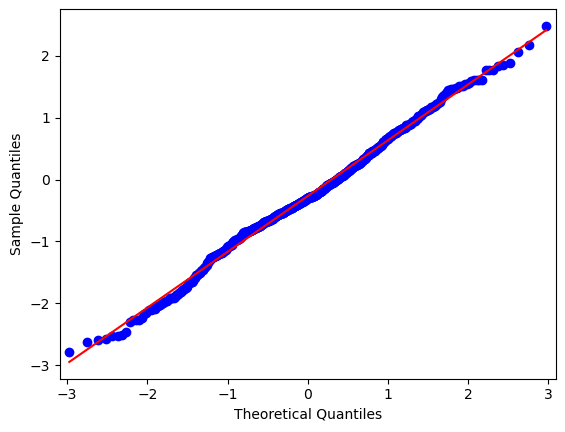

In [59]:
data3 = data[data['grazing_secs'] > 0]
md_tmp = smf.glm(form, data3, family=sm.families.NegativeBinomial())
mdf_tmp = md_tmp.fit()
print(mdf_tmp.summary())

from statsmodels.graphics.api import abline_plot
yhat3 = mdf_tmp.mu
yhat3[yhat3 > 10000] = 10000
fig, ax = plt.subplots()
ax.scatter(yhat3, data3['grazing_secs'])
line_fit = sm.OLS(data3['grazing_secs'], sm.add_constant(yhat3, prepend=True)).fit()
abline_plot(model_results=line_fit, ax=ax)
ax.set_title('Model Fit Plot')
ax.set_ylabel('Observed values')
ax.set_xlabel('Fitted values')
#ax.set_xlim(0, 170)

fig, ax = plt.subplots()

ax.scatter(yhat3, mdf_tmp.resid_pearson)
ax.hlines(0, 0, np.max(yhat3))
#ax.set_xlim(0, 1)
ax.set_title('Residual Dependence Plot')
ax.set_ylabel('Pearson Residuals')
ax.set_xlabel('Fitted values')

from scipy import stats

fig, ax = plt.subplots()
resid = mdf_tmp.resid_deviance.copy()
resid_std = stats.zscore(resid)
ax.hist(resid_std, bins=25)
ax.set_title('Histogram of standardized deviance residuals')

from statsmodels import graphics
graphics.gofplots.qqplot(resid, line='r')

In [98]:
from typing import Optional, Union
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.base import BaseEstimator
from sklearn.utils.estimator_checks import check_estimator
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from lightgbm import LGBMClassifier, LGBMRegressor


class HurdleRegression(BaseEstimator):
    """ Regression model which handles excessive zeros by fitting a two-part model and combining predictions:
            1) binary classifier
            2) continuous regression
    Implementeted as a valid sklearn estimator, so it can be used in pipelines and GridSearch objects.
    Args:
        clf_name: currently supports either 'logistic' or 'LGBMClassifier'
        reg_name: currently supports either 'linear' or 'LGBMRegressor'
        clf_params: dict of parameters to pass to classifier sub-model when initialized
        reg_params: dict of parameters to pass to regression sub-model when initialized
    """

    def __init__(self,
                 clf_name: str = 'logistic',
                 reg_name: str = 'linear',
                 clf_params: Optional[dict] = None,
                 reg_params: Optional[dict] = None):

        self.clf_name = clf_name
        self.reg_name = reg_name
        self.clf_params = clf_params
        self.reg_params = reg_params

    @staticmethod
    def _resolve_estimator(func_name: str):
        """ Lookup table for supported estimators.
        This is necessary because sklearn estimator default arguments
        must pass equality test, and instantiated sub-estimators are not equal. """

        funcs = {'linear': LinearRegression(),
                 'logistic': LogisticRegression(solver='liblinear'),
                 'LGBMRegressor': LGBMRegressor(n_estimators=50),
                 'LGBMClassifier': LGBMClassifier(n_estimators=50)}

        return funcs[func_name]

    def fit(self,
            X: Union[np.ndarray, pd.DataFrame],
            y: Union[np.ndarray, pd.Series]):
        X, y = check_X_y(X, y, dtype=None,
                         accept_sparse=False,
                         accept_large_sparse=False,
                         force_all_finite='allow-nan')

        if X.shape[1] < 2:
            raise ValueError('Cannot fit model when n_features = 1')

        self.clf_ = self._resolve_estimator(self.clf_name)
        if self.clf_params:
            self.clf_.set_params(**self.clf_params)
        self.clf_.fit(X, y > 0)

        self.reg_ = self._resolve_estimator(self.reg_name)
        if self.reg_params:
            self.reg_.set_params(**self.reg_params)
        self.reg_.fit(X[y > 0], y[y > 0])

        self.is_fitted_ = True
        return self

    def predict(self, X: Union[np.ndarray, pd.DataFrame]):
        """ Predict combined response using binary classification outcome """
        X = check_array(X, accept_sparse=False, accept_large_sparse=False)
        check_is_fitted(self, 'is_fitted_')
        return self.clf_.predict(X) * self.reg_.predict(X)

    def predict_expected_value(self, X: Union[np.ndarray, pd.DataFrame]):
        """ Predict combined response using probabilistic classification outcome """
        X = check_array(X, accept_sparse=False, accept_large_sparse=False)
        check_is_fitted(self, 'is_fitted_')
        return self.clf_.predict_proba(X)[:, 1] * self.reg_.predict(X)


def manual_test():
    """ Validate estimator using sklearn's provided utility and ensure it can fit and predict on fake dataset. """
    check_estimator(HurdleRegression)
    from sklearn.datasets import make_regression
    X, y = make_regression()
    reg = HurdleRegression()
    reg.fit(X, y)
    reg.predict(X)


if __name__ == '__main__':
    manual_test()

ModuleNotFoundError: No module named 'lightgbm'

array([[ 524055., 4522725.],
       [ 524055., 4522695.],
       [ 524055., 4522665.],
       ...,
       [ 525525., 4522695.],
       [ 525555., 4522755.],
       [ 525555., 4522725.]])

In [20]:
df_results = pd.DataFrame(columns=['week', 'Pasture', 'Steer_ID', 'model', 'formula', 'AIC', 'logit_acc', 'AIC_logit'])
idx = 0
for group in tqdm(df_wkly_grid.groupby(['week', 'Pasture', 'Steer_ID'])):
    # drop NANs and any pixels within 30m of water tank
    data = group[1].dropna(axis=0, how='any')
    data = data[data['dTank'] > 75]
    data = data[data['dCorner'] > 60]
    # remove any outliers beyond last 5-sec bin with only one pixel
    bins = np.arange(-5, 10000, 30)
    groups = data.groupby(pd.cut(data['grazing_secs'], bins, include_lowest=False))
    one_bins = bins[:-1][(groups.grazing_secs.count() == 1).values] 
    gt_one_bins = bins[:-1][(groups.grazing_secs.count() > 1).values] 
    last_one_bin = np.min([np.max(gt_one_bins) + 10, np.max([np.min(one_bins), np.max(gt_one_bins)])])
    print('\n')
    print(group[0])
    print('Truncating at ' + str(last_one_bin))
    print('Removed ' + str(sum(data['grazing_secs'] >= last_one_bin)) + ' pixels')
    data = data[data['grazing_secs'] < last_one_bin]
    
    # remove any locations related to a class with fewer than 6 observations
    data = data[~data['PC_dmt'].isin(
        data['PC_dmt'].value_counts().index[data['PC_dmt'].value_counts() < 6])]
    data = data[~data['TPC_c'].isin(
        data['TPC_c'].value_counts().index[data['TPC_c'].value_counts() < 6])]
       
    df_results_tmp = pd.DataFrame(columns=['week', 'Pasture', 'Steer_ID', 'model', 'formula', 'AIC', 'logit_acc', 'AIC_logit'])
    
    # run initial models for negative binomial
    for i in model_dict:
        form = model_dict[i]
        #print('NB: ' + form)
        try:
            md_tmp = smf.glm(form, data, family=sm.families.NegativeBinomial())
            mdf_tmp = md_tmp.fit()
            aic_tmp = round(mdf_tmp.aic, 2)
        except (ValueError, np.linalg.LinAlgError):
            acc_tmp = np.nan
            aicl_tmp = np.nan
        df_tmp = pd.DataFrame({
            'week': group[0][0],
            'Pasture': group[0][1],
            'Steer_ID': group[0][2],
            'model': i,
            'formula': form,
            'AIC': aic_tmp,
            'logit_acc': np.nan,
            'AIC_logit': np.nan
        }, index=[idx])
        df_results_tmp = df_results_tmp.append(df_tmp)
        idx += 1
               
    # get best M2 and M3 models for negative binomial and create M4 interaction models
    m2_min_idx = df_results_tmp[df_results_tmp['model'].str.contains('M2')]['AIC'].idxmin()
    m2_min_tmp = df_results_tmp[df_results_tmp['model'].str.contains('M2')]['formula'][m2_min_idx]
    m3_min_idx = df_results_tmp[df_results_tmp['model'].str.contains('M3')]['AIC'].idxmin()
    m3_min_tmp = df_results_tmp[df_results_tmp['model'].str.contains('M3')]['formula'][m3_min_idx]
    m4a_tmp = m0 + re.sub(re.escape(m0), '', m2_min_tmp) + re.sub(re.escape(m0), '', m3_min_tmp)
    m4b_tmp = m4a_tmp + ''
    if ('CP' in m2_min_tmp) | ('DOM' in m2_min_tmp):
        m2f_tmp = m0 + re.sub(re.escape(m0), '', m2_min_tmp) + ' + np.log(Biomass)'
        m2g_tmp = m0 + re.sub(re.escape(m0), '', m2_min_tmp) + ' + np.log(Biomass) + I(np.log(Biomass)**2)'
        if 'CP' in m2_min_tmp:
            m2f_tmp = m2f_tmp + ' + np.log(Biomass):CP'
            m2g_tmp = m2g_tmp + ' + np.log(Biomass):CP'
        if 'DOM' in m2_min_tmp:
            m2f_tmp = m2f_tmp + ' + np.log(Biomass):DOM'
            m2g_tmp = m2g_tmp + ' + np.log(Biomass):DOM'
        if 'PC_dmt' in m4b_tmp:
            if 'CP' in m4b_tmp:
                m4b_tmp = m4b_tmp + ' + CP:C(PC_dmt, Treatment(reference="C3_C4_mix"))'
            if 'DOM' in m4b_tmp:
                m4b_tmp = m4b_tmp + ' + DOM:C(PC_dmt, Treatment(reference="C3_C4_mix"))'
    else:
        m2f_tmp = None
        m2g_tmp = None
    
    if m4a_tmp == m4b_tmp:
        m4b_tmp = None
    
    model_dict2 = {'M2f': m2f_tmp, 'M2g': m2g_tmp, 'M4a': m4a_tmp, 'M4b': m4b_tmp}
    
    # run M2, M4 interaction models for negative binomial
    for i in model_dict2:
        form = model_dict2[i]
        if form is None:
            df_tmp = pd.DataFrame({
            'week': group[0][0],
            'Pasture': group[0][1],
            'Steer_ID': group[0][2],
            'model': i,
            'formula': '',
            'AIC': np.nan
            }, index=[idx])
            df_results_tmp = df_results_tmp.append(df_tmp)
            idx += 1
        else:
            #print('NB: ' + form)
            try:
                md_tmp = smf.glm(form, data, family=sm.families.NegativeBinomial())
                mdf_tmp = md_tmp.fit()
                aic_tmp = round(mdf_tmp.aic, 2)
            except (ValueError, np.linalg.LinAlgError):
                aic_tmp = np.nan
            df_tmp = pd.DataFrame({
                'week': group[0][0],
                'Pasture': group[0][1],
                'Steer_ID': group[0][2],
                'model': i,
                'formula': form,
                'AIC': aic_tmp
            }, index=[idx])
            df_results_tmp = df_results_tmp.append(df_tmp)
            idx += 1
      
    # run M5 model for negative binomial
    m2_min_idx = df_results_tmp[df_results_tmp['model'].str.contains('M2')]['AIC'].idxmin()
    m2_min_tmp = df_results_tmp[df_results_tmp['model'].str.contains('M2')]['formula'][m2_min_idx]
    m3_min_idx = df_results_tmp[df_results_tmp['model'].str.contains('M3')]['AIC'].idxmin()
    m3_min_tmp = df_results_tmp[df_results_tmp['model'].str.contains('M3')]['formula'][m3_min_idx]
    m5a_tmp = m1 + re.sub(re.escape(m0), '', m2_min_tmp)
    m5b_tmp = m1 + re.sub(re.escape(m0), '', m3_min_tmp)
    try:
        m4_min_idx = df_results_tmp[df_results_tmp['model'].str.contains('M4')]['AIC'].idxmin()
        m4_min_tmp = df_results_tmp[df_results_tmp['model'].str.contains('M4')]['formula'][m4_min_idx]
        m5c_tmp = m1 + re.sub(re.escape(m0), '', m4_min_tmp)
        model_dict3 = {'M5a': m5a_tmp, 'M5b': m5b_tmp, 'M5c': m5c_tmp}
    except KeyError:
         model_dict3 = {'M5a': m5a_tmp, 'M5b': m5b_tmp, 'M5c': None}
    for i in model_dict3:
        form = model_dict3[i]
        if form is None:
            df_tmp = pd.DataFrame({
            'week': group[0][0],
            'Pasture': group[0][1],
            'Steer_ID': group[0][2],
            'model': i,
            'formula': '',
            'AIC': np.nan
            }, index=[idx])
            df_results_tmp = df_results_tmp.append(df_tmp)
            idx += 1
        else:
            #print('NB: ' + form)
            try:
                md_tmp = smf.glm(form, data, family=sm.families.NegativeBinomial())
                mdf_tmp = md_tmp.fit()
                aic_tmp = round(mdf_tmp.aic, 2)
            except (ValueError, np.linalg.LinAlgError):
                aic_tmp = np.nan
            df_tmp = pd.DataFrame({
                'week': group[0][0],
                'Pasture': group[0][1],
                'Steer_ID': group[0][2],
                'model': i,
                'formula': form,
                'AIC': aic_tmp,
                'logit_acc': np.nan,
                'AIC_logit': np.nan
            }, index=[idx])
            df_results_tmp = df_results_tmp.append(df_tmp)
            idx += 1
        
    df_results = df_results.append(df_results_tmp)

  0%|          | 0/71 [00:00<?, ?it/s]



(21, '15E', '3772_D1_2017')
Truncating at 1645
Removed 15 pixels


(21, '15E', '3773_D1_2017')
Truncating at 1645
Removed 13 pixels


(21, '17N', '2289_D1_2017')
Truncating at 1735
Removed 5 pixels


(21, '17N', '2290_D1_2017')
Truncating at 2095
Removed 8 pixels


(21, '20SE', '2293_D1_2017')
Truncating at 1585
Removed 17 pixels


(21, '20SE', '2294_D1_2017')
Truncating at 2155
Removed 3 pixels


(21, '26E', '3775_D1_2017')
Truncating at 2125
Removed 12 pixels


(21, '31E', '4598_D1_2017')
Truncating at 1855
Removed 5 pixels


(21, '7NW', '2287_D1_2017')
Truncating at 1885
Removed 7 pixels


(21, '7NW', '2288_D1_2017')
Truncating at 1405
Removed 8 pixels


C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\genmod\families\family.py:1227: RuntimeWarning: invalid value encountered in true_divide
  endog_mu = self._clean(endog / mu)




(22, '15E', '3772_D1_2017')
Truncating at 2005
Removed 7 pixels


(22, '15E', '3773_D1_2017')
Truncating at 1615
Removed 9 pixels


(22, '17N', '2289_D1_2017')
Truncating at 1555
Removed 7 pixels


(22, '17N', '2290_D1_2017')
Truncating at 2485
Removed 3 pixels


(22, '20SE', '2293_D1_2017')
Truncating at 1735
Removed 13 pixels


(22, '20SE', '2294_D1_2017')
Truncating at 1615
Removed 12 pixels


(22, '26E', '3775_D1_2017')
Truncating at 2245
Removed 14 pixels


(22, '31E', '4598_D1_2017')
Truncating at 1405
Removed 5 pixels


(22, '7NW', '2287_D1_2017')
Truncating at 1345
Removed 6 pixels


(22, '7NW', '2288_D1_2017')
Truncating at 1255
Removed 10 pixels


(23, '15E', '3772_D1_2017')
Truncating at 1975
Removed 10 pixels


(23, '15E', '3773_D1_2017')
Truncating at 2875
Removed 3 pixels


(23, '17N', '2289_D1_2017')
Truncating at 1105
Removed 12 pixels


C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\genmod\families\links.py:517: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\genmod\families\family.py:1227: RuntimeWarning: divide by zero encountered in true_divide
  endog_mu = self._clean(endog / mu)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\genmod\families\family.py:1231: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\genmod\families\varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\genmod\families\family.py:134: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\s



(23, '17N', '2290_D1_2017')
Truncating at 2215
Removed 9 pixels


(23, '20SE', '2293_D1_2017')
Truncating at 1615
Removed 14 pixels


(23, '20SE', '2294_D1_2017')
Truncating at 2095
Removed 6 pixels


(23, '26E', '3775_D1_2017')
Truncating at 1765
Removed 20 pixels


(23, '31E', '4598_D1_2017')
Truncating at 1465
Removed 9 pixels


(23, '7NW', '2287_D1_2017')
Truncating at 1345
Removed 11 pixels


(23, '7NW', '2288_D1_2017')
Truncating at 1525
Removed 8 pixels


(28, '15E', '3772_D2_2017')
Truncating at 1585
Removed 15 pixels


(28, '15E', '3773_D2_2017')
Truncating at 2425
Removed 4 pixels


(28, '17N', '2289_D2_2017')
Truncating at 1615
Removed 12 pixels


(28, '17N', '2290_D2_2017')
Truncating at 1795
Removed 9 pixels


(28, '20SE', '2294_D2_2017')
Truncating at 1495
Removed 9 pixels


(28, '26E', '3775_D2_2017')
Truncating at 1765
Removed 11 pixels


(28, '31E', '4598_D2_2017')
Truncating at 1495
Removed 12 pixels


(28, '7NW', '2288_D2_2017')
Truncating at 1315
Removed 7 pixels


C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\genmod\families\family.py:1279: RuntimeWarning: divide by zero encountered in log
  ll_obs = endog * np.log(self.alpha * mu)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\genmod\families\family.py:1279: RuntimeWarning: invalid value encountered in multiply
  ll_obs = endog * np.log(self.alpha * mu)




(31, '26E', '3775_D2_2017')
Truncating at 2245
Removed 7 pixels


(31, '31E', '4598_D2_2017')
Truncating at 2035
Removed 10 pixels


(31, '7NW', '2288_D2_2017')
Truncating at 1585
Removed 4 pixels


(37, '15E', '3772_D3_2017')
Truncating at 2065
Removed 4 pixels


(37, '15E', '3773_D3_2017')
Truncating at 1705
Removed 10 pixels


(37, '17N', '2289_D3_2017')
Truncating at 2155
Removed 6 pixels


(37, '17N', '2290_D3_2017')
Truncating at 1945
Removed 7 pixels


(37, '20SE', '2293_D3_2017')
Truncating at 3115
Removed 4 pixels


(37, '20SE', '2294_D3_2017')
Truncating at 2485
Removed 4 pixels


(37, '26E', '3775_D3_2017')
Truncating at 2245
Removed 7 pixels


(37, '31E', '4598_D3_2017')
Truncating at 2755
Removed 3 pixels


(37, '7NW', '2287_D3_2017')
Truncating at 2035
Removed 3 pixels


(37, '7NW', '2288_D3_2017')
Truncating at 1345
Removed 12 pixels


(38, '15E', '3772_D3_2017')
Truncating at 2305
Removed 5 pixels


(38, '15E', '3773_D3_2017')
Truncating at 1825
Removed 8 pixels


(38

In [21]:
aicw_func = lambda x: np.exp(-0.5 * (x - x.min())) / np.sum(np.exp(-0.5 * (x - x.min())))
acc_diff_func = lambda x: x - x.max()
df_results['AICw'] = df_results.groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicw_func)
df_results['AICd'] = df_results.groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    lambda x: x - x.min())
df_results['top_model'] = df_results.groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    lambda x: [int(i) for i in x == x.min()])
df_results['candidate_model'] = df_results.groupby(['week', 'Pasture', 'Steer_ID'])['AICw'].transform(
    lambda x: [int(i) for i in x > 0.05])

In [22]:
# calculate AIC weights for within-driver hypotheses for negative binomial 
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M1', 'M5'])), 
               'AICw_Hw1'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M1', 'M5']))].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicw_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2'])), 
               'AICw_Hw2_3_5_6'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2']))].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicw_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2a', 'M2b'])), 
               'AICw_Hw4a'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2a', 'M2b']))].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicw_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2f', 'M2g'])), 
               'AICw_Hw4b'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2f', 'M2g']))].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicw_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M3'])), 
               'AICw_Hw7_8_9'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M3']))].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicw_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M0', 'M1', 'M2', 'M3'])), 
               'AICw_Ha1'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M0', 'M1', 'M2', 'M3']))].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicw_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M0', 'M1', 'M2', 'M3', 'M4'])), 
               'AICw_Ha2_3_4'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M0', 'M1', 'M2', 'M3', 'M4']))].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicw_func)

In [25]:
df_hypotheses = pd.DataFrame(columns=['Driver', 'ID', 'mean_AICw', 'ct_AICw_gt05',
                                      'mean_AICw_logit', 'ct_AICw_logit_gt05', 'mean_logit_acc_diff', 'ct_acc_min'])

df_hypotheses = df_hypotheses.append(pd.DataFrame({
    'Driver': 'Topography',
    'ID': 'Hw1',
    'mean_AICw': df_results[df_results['model'] == 'M1']['AICw_Hw1'].round(2).mean(),
    'ct_AICw_gt05': sum(df_results[df_results['model'] == 'M1']['AICw_Hw1'] > 0.05),
    'mean_AICw_logit': df_results[df_results['model'] == 'M1']['AICw_logit_Hw1'].round(2).mean(),
    'ct_AICw_logit_gt05': sum(df_results[df_results['model'] == 'M1']['AICw_logit_Hw1'] > 0.05),
    'mean_logit_acc_diff': df_results[df_results['model'] == 'M1']['logit_acc_diff_Hw1'].round(2).mean(),
    'ct_acc_min': sum(df_results[df_results['model'] == 'M1']['logit_acc_diff_Hw1'] > -0.50)
}, index=[0]))

df_hypotheses = df_hypotheses.append(pd.DataFrame({
    'Driver': 'Forage conditions',
    'ID': 'Hw2',
    'mean_AICw': df_results[df_results['model'] == 'M2a']['AICw_Hw2_3_5_6'].round(2).mean(),
    'ct_AICw_gt05': sum(df_results[df_results['model'] == 'M2a']['AICw_Hw2_3_5_6'] > 0.05),
    'mean_AICw_logit': df_results[df_results['model'] == 'M2a']['AICw_logit_Hw2_3_5_6'].round(2).mean(),
    'ct_AICw_logit_gt05': sum(df_results[df_results['model'] == 'M2a']['AICw_logit_Hw2_3_5_6'] > 0.05),
    'mean_logit_acc_diff': df_results[df_results['model'] == 'M2a']['logit_acc_diff_Hw2_3_5_6'].round(2).mean(),
    'ct_acc_min': sum(df_results[df_results['model'] == 'M2a']['logit_acc_diff_Hw2_3_5_6'] > -0.50)
}, index=[1]))

df_hypotheses = df_hypotheses.append(pd.DataFrame({
    'Driver': 'Forage conditions',
    'ID': 'Hw3',
    'mean_AICw': df_results[df_results['model'] == 'M2b']['AICw_Hw2_3_5_6'].round(2).mean(),
    'ct_AICw_gt05': sum(df_results[df_results['model'] == 'M2b']['AICw_Hw2_3_5_6'] > 0.05),
    'ct_AICw_logit_gt05': sum(df_results[df_results['model'] == 'M2b']['AICw_logit_Hw2_3_5_6'] > 0.05),
    'mean_AICw_logit': df_results[df_results['model'] == 'M2b']['AICw_logit_Hw2_3_5_6'].round(2).mean(),
    'mean_logit_acc_diff': df_results[df_results['model'] == 'M2b']['logit_acc_diff_Hw2_3_5_6'].round(2).mean(),
    'ct_acc_min': sum(df_results[df_results['model'] == 'M2b']['logit_acc_diff_Hw2_3_5_6'] > -0.50)
}, index=[2]))

df_hypotheses = df_hypotheses.append(pd.DataFrame({
    'Driver': 'Forage conditions',
    'ID': 'Hw4',
    'mean_AICw': df_results[(df_results['Steer_ID'].isin(df_results[(df_results['model'] == 'M2b') & 
                                                                    (df_results['AICw_Hw4a'] > 0.05)]['Steer_ID'])) & 
                            (df_results['model'] == 'M2f')]['AICw_Hw4b'].round(2).mean(),
    'ct_AICw_gt05': sum(df_results[(df_results['Steer_ID'].isin(df_results[(df_results['model'] == 'M2b') & 
                                                                    (df_results['AICw_Hw4a'] > 0.05)]['Steer_ID'])) & 
                            (df_results['model'] == 'M2f')]['AICw_Hw4b'] > 0.05),
    'mean_AICw_logit': df_results[(df_results['Steer_ID'].isin(df_results[(df_results['model'] == 'M2b') & 
                                                                    (df_results['AICw_logit_Hw4a'] > 0.05)]['Steer_ID'])) & 
                            (df_results['model'] == 'M2f')]['AICw_logit_Hw4b'].round(2).mean(),
    'ct_AICw_logit_gt05': sum(df_results[(df_results['Steer_ID'].isin(df_results[(df_results['model'] == 'M2b') & 
                                                                    (df_results['AICw_logit_Hw4a'] > 0.05)]['Steer_ID'])) & 
                            (df_results['model'] == 'M2f')]['AICw_logit_Hw4b'] > 0.05),
    'mean_logit_acc_diff': df_results[(df_results['Steer_ID'].isin(df_results[(df_results['model'] == 'M2b') & 
                                                                (df_results['AICw_logit_Hw4a'] > 0.05)]['Steer_ID'])) & 
                        (df_results['model'] == 'M2f')]['logit_acc_diff_Hw4b'].round(2).mean(),
    'ct_acc_min': sum(df_results[(df_results['Steer_ID'].isin(df_results[(df_results['model'] == 'M2b') & 
                                                                    (df_results['AICw_logit_Hw4a'] > 0.05)]['Steer_ID'])) & 
                            (df_results['model'] == 'M2f')]['logit_acc_diff_Hw4b'] > -0.50)
}, index=[3]))

df_hypotheses = df_hypotheses.append(pd.DataFrame({
    'Driver': 'Forage conditions',
    'ID': 'Hw5',
    'mean_AICw': df_results[df_results['model'].str.contains('|'.join(['M2c', 'M2d', 'M2e']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['AICw_Hw2_3_5_6'].sum().round(2).mean(),
    'ct_AICw_gt05': sum(df_results[df_results['model'].str.contains('|'.join(['M2c', 'M2d', 'M2e']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['AICw_Hw2_3_5_6'].sum() > 0.05),
    'mean_AICw_logit': df_results[df_results['model'].str.contains('|'.join(['M2c', 'M2d', 'M2e']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['AICw_logit_Hw2_3_5_6'].sum().round(2).mean(),
    'ct_AICw_logit_gt05': sum(df_results[df_results['model'].str.contains('|'.join(['M2c', 'M2d', 'M2e']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['AICw_logit_Hw2_3_5_6'].sum() > 0.05),
    'mean_logit_acc_diff': df_results[df_results['model'].str.contains('|'.join(['M2c', 'M2d', 'M2e']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['logit_acc_diff_Hw2_3_5_6'].max().round(2).mean(),
    'ct_acc_min': sum(df_results[df_results['model'].str.contains('|'.join(['M2c', 'M2d', 'M2e']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['logit_acc_diff_Hw2_3_5_6'].max() > -0.50)
}, index=[4]))

df_hypotheses = df_hypotheses.append(pd.DataFrame({
    'Driver': 'Forage conditions',
    'ID': 'Hw6',
    'mean_AICw': df_results[df_results['model'].str.contains('|'.join(['M2f', 'M2g']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['AICw_Hw2_3_5_6'].sum().round(2).mean(),
    'ct_AICw_gt05': sum(df_results[df_results['model'].str.contains('|'.join(['M2f', 'M2g']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['AICw_Hw2_3_5_6'].sum() > 0.05),
    'mean_AICw_logit': df_results[df_results['model'].str.contains('|'.join(['M2f', 'M2g']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['AICw_logit_Hw2_3_5_6'].sum().round(2).mean(),
    'ct_AICw_logit_gt05': sum(df_results[df_results['model'].str.contains('|'.join(['M2f', 'M2g']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['AICw_logit_Hw2_3_5_6'].sum() > 0.05),
    'mean_logit_acc_diff': df_results[df_results['model'].str.contains('|'.join(['M2f', 'M2g']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['logit_acc_diff_Hw2_3_5_6'].max().round(2).mean(),
    'ct_acc_min': sum(df_results[df_results['model'].str.contains('|'.join(['M2f', 'M2g']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['logit_acc_diff_Hw2_3_5_6'].max() > -0.50)
}, index=[5]))

df_hypotheses = df_hypotheses.append(pd.DataFrame({
    'Driver': 'Forage conditions',
    'ID': 'Hw7',
    'mean_AICw': df_results[df_results['model'].str.contains('|'.join(['M3a', 'M3b']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['AICw_Hw7_8_9'].sum().round(2).mean(),
    'ct_AICw_gt05': sum(df_results[df_results['model'].str.contains('|'.join(['M3a', 'M3b']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['AICw_Hw7_8_9'].sum() > 0.05),
    'mean_AICw_logit': df_results[df_results['model'].str.contains('|'.join(['M3a', 'M3b']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['AICw_logit_Hw7_8_9'].sum().round(2).mean(),
    'ct_AICw_logit_gt05': sum(df_results[df_results['model'].str.contains('|'.join(['M3a', 'M3b']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['AICw_logit_Hw7_8_9'].sum() > 0.05),
    'mean_logit_acc_diff': df_results[df_results['model'].str.contains('|'.join(['M3a', 'M3b']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['logit_acc_diff_Hw7_8_9'].max().round(2).mean(),
    'ct_acc_min': sum(df_results[df_results['model'].str.contains('|'.join(['M3a', 'M3b']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['logit_acc_diff_Hw7_8_9'].max() > -0.50)
}, index=[6]))

df_hypotheses = df_hypotheses.append(pd.DataFrame({
    'Driver': 'Forage conditions',
    'ID': 'Hw8',
    'mean_AICw': df_results[df_results['model'].str.contains('|'.join(['M3c']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['AICw_Hw7_8_9'].sum().round(2).mean(),
    'ct_AICw_gt05': sum(df_results[df_results['model'].str.contains('|'.join(['M3c']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['AICw_Hw7_8_9'].sum() > 0.05),
    'mean_AICw_logit': df_results[df_results['model'].str.contains('|'.join(['M3c']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['AICw_logit_Hw7_8_9'].sum().round(2).mean(),
    'ct_AICw_logit_gt05': sum(df_results[df_results['model'].str.contains('|'.join(['M3c']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['AICw_logit_Hw7_8_9'].sum() > 0.05),
    'mean_logit_acc_diff': df_results[df_results['model'].str.contains('|'.join(['M3c']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['logit_acc_diff_Hw7_8_9'].max().round(2).mean(),
    'ct_acc_min': sum(df_results[df_results['model'].str.contains('|'.join(['M3c']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['logit_acc_diff_Hw7_8_9'].max() > -0.50)
}, index=[7]))

df_hypotheses = df_hypotheses.append(pd.DataFrame({
    'Driver': 'Forage conditions',
    'ID': 'Hw9',
    'mean_AICw': df_results[df_results['model'].str.contains('|'.join(['M3d', 'M3e']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['AICw_Hw7_8_9'].sum().round(2).mean(),
    'ct_AICw_gt05': sum(df_results[df_results['model'].str.contains('|'.join(['M3d', 'M3e']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['AICw_Hw7_8_9'].sum() > 0.05),
    'mean_AICw_logit': df_results[df_results['model'].str.contains('|'.join(['M3d', 'M3e']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['AICw_logit_Hw7_8_9'].sum().round(2).mean(),
    'ct_AICw_logit_gt05': sum(df_results[df_results['model'].str.contains('|'.join(['M3d', 'M3e']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['AICw_logit_Hw7_8_9'].sum() > 0.05),
    'mean_logit_acc_diff': df_results[df_results['model'].str.contains('|'.join(['M3d', 'M3e']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['logit_acc_diff_Hw7_8_9'].max().round(2).mean(),
    'ct_acc_min': sum(df_results[df_results['model'].str.contains('|'.join(['M3d', 'M3e']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['logit_acc_diff_Hw7_8_9'].max() > -0.50)
}, index=[8]))

df_hypotheses = df_hypotheses.append(pd.DataFrame({
    'Driver': 'Forage conditions',
    'ID': 'Ha1',
    'mean_AICw': df_results[df_results['model'].str.contains('|'.join(['M0']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['AICw_Ha1'].sum().round(2).mean(),
    'ct_AICw_gt05': sum(df_results[df_results['model'].str.contains('|'.join(['M0']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['AICw_Ha1'].sum() > 0.05),
    'mean_AICw_logit': df_results[df_results['model'].str.contains('|'.join(['M0']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['AICw_logit_Ha1'].sum().round(2).mean(),
    'ct_AICw_logit_gt05': sum(df_results[df_results['model'].str.contains('|'.join(['M0']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['AICw_logit_Ha1'].sum() > 0.05),
    'mean_logit_acc_diff': df_results[df_results['model'].str.contains('|'.join(['M0']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['logit_acc_diff_Ha1'].max().round(2).mean(),
    'ct_acc_min': sum(df_results[df_results['model'].str.contains('|'.join(['M0']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['logit_acc_diff_Ha1'].max() > -0.50)
}, index=[9]))

df_hypotheses = df_hypotheses.append(pd.DataFrame({
    'Driver': 'Forage conditions',
    'ID': 'Ha2',
    'mean_AICw': df_results[df_results['model'].str.contains('|'.join(['M1']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['AICw_Ha2_3_4'].sum().round(2).mean(),
    'ct_AICw_gt05': sum(df_results[df_results['model'].str.contains('|'.join(['M1']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['AICw_Ha2_3_4'].sum() > 0.05),
    'mean_AICw_logit': df_results[df_results['model'].str.contains('|'.join(['M1']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['AICw_logit_Ha2_3_4'].sum().round(2).mean(),
    'ct_AICw_logit_gt05': sum(df_results[df_results['model'].str.contains('|'.join(['M1']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['AICw_logit_Ha2_3_4'].sum() > 0.05),
    'mean_logit_acc_diff': df_results[df_results['model'].str.contains('|'.join(['M1']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['logit_acc_diff_Ha2_3_4'].max().round(2).mean(),
    'ct_acc_min': sum(df_results[df_results['model'].str.contains('|'.join(['M1']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['logit_acc_diff_Ha2_3_4'].max() > -0.50)
}, index=[10]))

df_hypotheses = df_hypotheses.append(pd.DataFrame({
    'Driver': 'Forage conditions',
    'ID': 'Ha3',
    'mean_AICw': df_results[df_results['model'].str.contains('|'.join(['M2']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['AICw_Ha2_3_4'].sum().round(2).mean(),
    'ct_AICw_gt05': sum(df_results[df_results['model'].str.contains('|'.join(['M2']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['AICw_Ha2_3_4'].sum() > 0.05),
    'mean_AICw_logit': df_results[df_results['model'].str.contains('|'.join(['M2']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['AICw_logit_Ha2_3_4'].sum().round(2).mean(),
    'ct_AICw_logit_gt05': sum(df_results[df_results['model'].str.contains('|'.join(['M2']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['AICw_logit_Ha2_3_4'].sum() > 0.05),
    'mean_logit_acc_diff': df_results[df_results['model'].str.contains('|'.join(['M2']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['logit_acc_diff_Ha2_3_4'].max().round(2).mean(),
    'ct_acc_min': sum(df_results[df_results['model'].str.contains('|'.join(['M2']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['logit_acc_diff_Ha2_3_4'].max() > -0.50)
}, index=[11]))

df_hypotheses = df_hypotheses.append(pd.DataFrame({
    'Driver': 'Forage conditions',
    'ID': 'Ha4',
    'mean_AICw': df_results[df_results['model'].str.contains('|'.join(['M3']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['AICw_Ha2_3_4'].sum().round(2).mean(),
    'ct_AICw_gt05': sum(df_results[df_results['model'].str.contains('|'.join(['M3']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['AICw_Ha2_3_4'].sum() > 0.05),
    'mean_AICw_logit': df_results[df_results['model'].str.contains('|'.join(['M3']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['AICw_logit_Ha2_3_4'].sum().round(2).mean(),
    'ct_AICw_logit_gt05': sum(df_results[df_results['model'].str.contains('|'.join(['M3']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['AICw_logit_Ha2_3_4'].sum() > 0.05),
    'mean_logit_acc_diff': df_results[df_results['model'].str.contains('|'.join(['M3']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['logit_acc_diff_Ha2_3_4'].max().round(2).mean(),
    'ct_acc_min': sum(df_results[df_results['model'].str.contains('|'.join(['M3']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['logit_acc_diff_Ha2_3_4'].max() > -0.50)
}, index=[12]))

df_hypotheses = df_hypotheses.append(pd.DataFrame({
    'Driver': 'Forage conditions',
    'ID': 'Ha5',
    'mean_AICw': df_results[df_results['model'].str.contains('|'.join(['M4']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['AICw'].sum().round(2).mean(),
    'ct_AICw_gt05': sum(df_results[df_results['model'].str.contains('|'.join(['M4']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['AICw'].sum() > 0.05),
    'mean_AICw_logit': df_results[df_results['model'].str.contains('|'.join(['M4']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['AICw_logit'].sum().round(2).mean(),
    'ct_AICw_logit_gt05': sum(df_results[df_results['model'].str.contains('|'.join(['M4']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['AICw_logit'].sum() > 0.05),
    'mean_logit_acc_diff': df_results[df_results['model'].str.contains('|'.join(['M4']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['logit_acc_diff'].max().round(2).mean(),
    'ct_acc_min': sum(df_results[df_results['model'].str.contains('|'.join(['M4']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['logit_acc_diff'].max() > -0.50)
}, index=[13]))

df_hypotheses = df_hypotheses.append(pd.DataFrame({
    'Driver': 'Forage conditions',
    'ID': 'Ha6',
    'mean_AICw': df_results[df_results['model'].str.contains('|'.join(['M5']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['AICw'].sum().round(2).mean(),
    'ct_AICw_gt05': sum(df_results[df_results['model'].str.contains('|'.join(['M5']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['AICw'].sum() > 0.05),
    'mean_AICw_logit': df_results[df_results['model'].str.contains('|'.join(['M5']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['AICw_logit'].sum().round(2).mean(),
    'ct_AICw_logit_gt05': sum(df_results[df_results['model'].str.contains('|'.join(['M5']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['AICw_logit'].sum() > 0.05),
    'mean_logit_acc_diff': df_results[df_results['model'].str.contains('|'.join(['M5']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['logit_acc_diff'].max().round(2).mean(),
    'ct_acc_min': sum(df_results[df_results['model'].str.contains('|'.join(['M5']))].groupby(
    ['week', 'Pasture', 'Steer_ID'])['logit_acc_diff'].max() > -0.50)
}, index=[13]))

In [26]:
df_hypotheses

,Driver,ID,mean_AICw,ct_AICw_gt05,mean_AICw_logit,ct_AICw_logit_gt05,mean_logit_acc_diff,ct_acc_min
0,Topography,Hw1,0.000000,0,NaN,0,NaN,0
1,Forage conditions,Hw2,0.103662,13,NaN,0,NaN,0
2,Forage conditions,Hw3,0.458451,41,NaN,0,NaN,0
3,Forage conditions,Hw4,0.222667,15,NaN,0,NaN,0
4,Forage conditions,Hw5,0.035211,6,0.0,0,NaN,0
5,Forage conditions,Hw6,0.402817,30,0.0,0,NaN,0
6,Forage conditions,Hw7,0.041972,8,0.0,0,NaN,0
7,Forage conditions,Hw8,0.012535,2,0.0,0,NaN,0
8,Forage conditions,Hw9,0.945493,70,0.0,0,NaN,0
9,Forage conditions,Ha1,0.000000,0,0.0,0,NaN,0


In [27]:
df_results.groupby('model')['candidate_model'].sum().sort_values()

model
M0      0
M3e     0
M3d     0
M3c     0
M3b     0
M2g     0
M2f     0
M3a     0
M2d     0
M2c     0
M2b     0
M2a     0
M1      0
M2e     0
M4b     2
M4a     3
M5b     4
M5a     4
M5c    66
Name: candidate_model, dtype: int64

In [28]:
import seaborn as sns
for m in ['M0', 'M1', 'M2', 'M3', 'M4', 'M5']:
    df_results.loc[df_results['model'].str.contains(m), 'model_group'] = m
plt.figure()
sns.pointplot(x='week', y='AICw', hue='model_group', 
            data=df_results.groupby(['week', 'Pasture', 'Steer_ID', 'model_group']).sum().reset_index())
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper center', borderaxespad=0)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [39]:
plt.figure()
sns.pointplot(x='week', y='AICw_Hw2_3_5_6', 
              hue='model', 
              data=df_results[df_results['model_group'] == 'M2'].groupby(['week', 'Pasture', 'Steer_ID', 'model']).sum().reset_index())
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper center', borderaxespad=0)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [42]:
plt.figure()
sns.barplot(x='Pasture',
            y='AICw_Hw2_3_5_6', 
            hue='model', errwidth=0.1, 
            data=df_results[df_results['model_group'] == 'M2'].groupby(['week', 'Pasture', 'Steer_ID', 'model']).sum().reset_index())
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper center', borderaxespad=0)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [44]:
plt.figure()
sns.barplot(x='Pasture',
            y='AICw_Hw7_8_9', 
            hue='model', errwidth=0.1, 
            data=df_results[df_results['model_group'] == 'M3'].groupby(['week', 'Pasture', 'Steer_ID', 'model']).sum().reset_index())
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper center', borderaxespad=0)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [43]:
df_results.columns

Index(['week', 'Pasture', 'Steer_ID', 'model', 'formula', 'AIC', 'logit_acc',
       'AIC_logit', 'AICw', 'AICd', 'AICw_logit', 'AICd_logit',
       'logit_acc_diff', 'top_model', 'candidate_model', 'top_model_logit',
       'candidate_model_logit', 'AICw_Hw1', 'AICw_Hw2_3_5_6', 'AICw_Hw4a',
       'AICw_Hw4b', 'AICw_Hw7_8_9', 'AICw_Ha1', 'AICw_Ha2_3_4',
       'AICw_logit_Hw1', 'AICw_logit_Hw2_3_5_6', 'AICw_logit_Hw4a',
       'AICw_logit_Hw4b', 'AICw_logit_Hw7_8_9', 'AICw_logit_Ha1',
       'AICw_logit_Ha2_3_4', 'logit_acc_diff_Hw1', 'logit_acc_diff_Hw2_3_5_6',
       'logit_acc_diff_Hw4a', 'logit_acc_diff_Hw4b', 'logit_acc_diff_Hw7_8_9',
       'logit_acc_diff_Ha1', 'logit_acc_diff_Ha2_3_4', 'model_group'],
      dtype='object')

In [ ]:
form = m0 + 
md_tmp = smf.glm(m5c_tmp, df_wkly_grid, family=sm.families.NegativeBinomial())
mdf_tmp = md_tmp.fit()
aic_tmp = round(mdf_tmp.aic, 2)
df_tmp = pd.DataFrame({
    'week': group[0][0],
    'Pasture': group[0][1],
    'Steer_ID': group[0][2],
    'model': i,
    'formula': form,
    'AIC': aic_tmp,
    'logit_acc': np.nan,
    'AIC_logit': np.nan
}, index=[idx])


In [37]:
df_results.columns

Index(['week', 'Pasture', 'Steer_ID', 'model', 'formula', 'AIC', 'logit_acc',
       'AIC_logit', 'AICw', 'AICd', 'AICw_logit', 'AICd_logit',
       'logit_acc_diff', 'top_model', 'candidate_model', 'top_model_logit',
       'candidate_model_logit', 'AICw_Hw1', 'AICw_Hw2_3_5_6', 'AICw_Hw4a',
       'AICw_Hw4b', 'AICw_Hw7_8_9', 'AICw_Ha1', 'AICw_Ha2_3_4',
       'AICw_logit_Hw1', 'AICw_logit_Hw2_3_5_6', 'AICw_logit_Hw4a',
       'AICw_logit_Hw4b', 'AICw_logit_Hw7_8_9', 'AICw_logit_Ha1',
       'AICw_logit_Ha2_3_4', 'logit_acc_diff_Hw1', 'logit_acc_diff_Hw2_3_5_6',
       'logit_acc_diff_Hw4a', 'logit_acc_diff_Hw4b', 'logit_acc_diff_Hw7_8_9',
       'logit_acc_diff_Ha1', 'logit_acc_diff_Ha2_3_4', 'model_group'],
      dtype='object')

In [41]:
df_results[df_results['model'] == 'M2g']['formula'].value_counts()

                                                                                                                                                            41
grazing_secs ~ dFence + I(dFence**2) + dTank + I(dTank**2) + CP*DOM + np.log(Biomass) + I(np.log(Biomass)**2) + np.log(Biomass):CP + np.log(Biomass):DOM    26
grazing_secs ~ dFence + I(dFence**2) + dTank + I(dTank**2) + CP + np.log(Biomass) + I(np.log(Biomass)**2) + np.log(Biomass):CP                               4
Name: formula, dtype: int64

In [136]:
for m in ['M0', 'M1', 'M2', 'M3', 'M4', 'M5']:
    df_results.loc[df_results['model'].str.contains(m), 'model_group'] = m
plt.figure()
sns.pointplot(x='week', y='AICw_logit', hue='model_group', 
            data=df_results.groupby(['week', 'Pasture', 'Steer_ID', 'model_group']).sum().reset_index())
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper center', borderaxespad=0)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [138]:
plt.figure()
sns.pointplot(y='logit_acc', x='week', hue='model_group', 
            data=df_results.groupby(['week', 'Pasture', 'Steer_ID', 'model_group']).max().reset_index())

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

C:\Users\SEAN~1.KEA\AppData\Local\Temp/ipykernel_20240/3486574005.py:3: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  data=df_results.groupby(['week', 'Pasture', 'Steer_ID', 'model_group']).max().reset_index())


<AxesSubplot:xlabel='week', ylabel='logit_acc'>

In [184]:
import seaborn as sns
plt.figure()
sns.barplot(x='Pasture', y='candidate_model', hue='model', errwidth=0.1, 
            data=df_results)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper center', borderaxespad=0)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [143]:
import seaborn as sns
plt.figure()
sns.barplot(x='week', y='candidate_model', hue='model', errwidth=0.1, 
            data=df_results)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper center', borderaxespad=0)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [45]:
df_results.groupby(['week', 'Pasture', 'Steer_ID', 'model_group']).sum()

AIC           AICw      AICd  \
week Pasture Steer_ID     model_group                                       
21   15E     3772_D1_2017 M0            40198.18   0.000000e+00   8518.02   
                          M1            37972.04   0.000000e+00   6291.88   
                          M2           273754.35   0.000000e+00  51993.23   
                          M3           178894.93   0.000000e+00  20494.13   
                          M4            66297.47  1.445790e-278   2937.15   
...                                          ...            ...       ...   
38   7NW     2287_D3_2017 M1            49795.72   0.000000e+00   4806.03   
                          M2           342858.09   0.000000e+00  27930.26   
                          M3           194515.24   0.000000e+00  14556.48   
                          M4            91148.96   6.034861e-30   1169.58   
                          M5           139896.16   1.000000e+00   4927.09   

                                       top_model  candidate_model  AICw_Hw1  \
week Pasture Steer_ID     model_group                                         
21   15E     3772_D1_2017 M0                   0                0       0.0   
                          M1                   0                0       0.0   
                          M2                   0                0       0.0   
                          M3                   0                0       0.0   
                          M4                   0                0       0.0   
...                                          ...              ...       ...   
38   7NW     2287_D3_2017 M1                   0                0       0.0   
                          M2                   0                0       0.0   
                          M3                   0                0       0.0   
                          M4                   0                0       0.0   
                          M5                   1                1       1.0   

                                       AICw_Hw2_3_5_6  AICw_Hw4a  AICw_Hw4b  \
week Pasture Steer_ID     model_group                                         
21   15E     3772_D1_2017 M0                      0.0        0.0        0.0   
                          M1                      0.0        0.0        0.0   
                          M2                      1.0        1.0        1.0   
                          M3                      0.0        0.0        0.0   
                          M4                      0.0        0.0        0.0   
...                                               ...        ...        ...   
38   7NW     2287_D3_2017 M1                      0.0        0.0        0.0   
                          M2                      1.0        1.0        1.0   
                          M3                      0.0        0.0        0.0   
                          M4                      0.0        0.0        0.0   
                          M5                      0.0        0.0        0.0   

                                       AICw_Hw7_8_9       AICw_Ha1  \
week Pasture Steer_ID     model_group                                
21   15E     3772_D1_2017 M0                    0.0   0.000000e+00   
                          M1                    0.0   0.000000e+00   
                          M2                    0.0   0.000000e+00   
                          M3                    1.0   1.000000e+00   
                          M4                    0.0   0.000000e+00   
...                                             ...            ...   
38   7NW     2287_D3_2017 M1                    0.0   0.000000e+00   
                          M2                    0.0  2.330527e-101   
                          M3                    1.0   1.000000e+00   
                          M4                    0.0   0.000000e+00   
                          M5                    0.0   0.000000e+00   

                                       AICw_Ha2_3_4  
week Pasture Steer_ID 

In [131]:
plt.figure()
plt.scatter(x=data['Biomass'], y=mdf2b.predict(data))
#plt.plot(np.arange(0, 1000, 10), mdf0.predict(pd.DataFrame({'dFence': np.arange(0, 1000, 10),
#                                                           'dTank': np.arange(0, 1000, 10),
#                                                           'TPC_c': 'Highlands'})))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [82]:
mdf1.predict(pd.DataFrame({'dFence': np.arange(0, 1000, 10)}))

0     10.682137
1     10.909593
2     11.112469
3     11.289225
4     11.438505
        ...    
95     0.000589
96     0.000468
97     0.000371
98     0.000293
99     0.000231
Length: 100, dtype: float64

In [79]:
pd.DataFrame({'dFence': np.arange(0, 1000, 10)})

,dFence
0,0
1,10
2,20
3,30
4,40
...,...
95,950
96,960
97,970
98,980
